In [1]:
import pandas as pd
from plot_params import *
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import warnings
from tqdm import trange, tqdm_notebook
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import os

## Read output from score_fa_nomask.py 
- See: score_with_model-30bp.smk
- input: fasta file of sequences
- output: *.score.csv where:
  - score contains the dlogodds prediction (liklihood of RBP binding this sequence?) for each sequence, in csv format
  - join and aggregate prediction scores with hotspot/motif sequences
  - score.csv format:
```
,dlogodds_pred,ID
0,-0.045130283,0
1,0.03233305,1
2,-0.03293328,2
```

In [2]:
data=pd.read_csv(outdir / 'Human_annotated_30bp.csv.gz', index_col=0)  # from 0_join_data-human-30bp.ipynb

print(f"Read in {data.shape[0]} entries")
basedir = Path('/tscc/nfs/home/hsher/ps-yeolab5/karen_data/eclip_model_scores_human_30bp/output/')  # See analysis_snake
all_scores = basedir.glob('*.score.csv')
for f in all_scores:
    name = f.name.split('.')[0]
    df = pd.read_csv(f,
                    index_col = 0)
    df.set_index('ID', inplace = True)
    df.rename({'dlogodds_pred': name}, axis = 1, inplace = True)

    data[name]=df[name]

Read in 6969886 entries


In [3]:
data.head()

transcript_id  deletion_index_start  deletion_index_end  difference  \
0  ENST00000000233                     0                  30    0.000000   
1  ENST00000000233                    15                  45    0.000000   
2  ENST00000000233                    30                  60    0.000000   
3  ENST00000000233                    45                  75    0.000000   
4  ENST00000000233                    60                  90   -0.001953   

   synapse_probability start_annotation end_annotation  \
0             0.044434             UTR5           UTR5   
1             0.044434             UTR5           UTR5   
2             0.044434             UTR5           UTR5   
3             0.044434             UTR5           UTR5   
4             0.042480             UTR5            CDS   

                           subseq  DDX41_K562_5081  AQR_HepG2_ENCSR018WPY  \
0  CTGCTGCTGCTGCGCCCCATCCCCCCGCGG         0.621414               1.272295   
1  CCCATCCCCCCGCGGCCGGCCAGTTCCAGC         0.645101               1.239188   
2  CCGGCCAGTTCCAGCCCGCACCCCGCGTCG         0.677037               1.241189   
3  CCGCACCCCGCGTCGGTGCCCGCGCCCCTC         0.608661               1.243805   
4  GTGCCCGCGCCCCTCCCCGGGCCCCGCCAT         0.578035               1.230869   

   ...  GTF2F1_HepG2_ENCSR265ZIS  PSMA1_K562_4017  HNRNPM_HepG2_ENCSR267UCX  \
0  ...                  0.238074         1.265944                  0.788839   
1  ...                  0.212154         1.280311                  0.744100   
2  ...                  0.191797         1.280807                  0.761853   
3  ...                  0.203500         1.258870                  0.796313   
4  ...                  0.198462         1.257003                  0.743185   

   DDX5_K562_5094  EIF2B5_K562_5020  GRSF1_HepG2_ENCSR668MJX  CTCF_K562_4065  \
0        0.518209          0.925792                 1.056194        0.848789   
1        0.567221          0.867844                 1.051970        0.834800   
2        0.599932          0.889403                 1.038438        0.839993   
3        0.547680          0.841227                 1.048819        0.860952   
4        0.501922          0.834412                 1.037641        0.829843   

   PTBP1_K562_5015  BUD13_K562_ENCSR663WES  ZNF800_K562_ENCSR586DGV  
0         1.077255                0.794077                 1.044325  
1         1.078154                0.808794                 1.022958  
2         1.041651                0.784075                 1.021055  
3         1.044563                0.765088                 1.027494  
4         1.026855                0.763847                 1.003426  

[5 rows x 181 columns]

## Annotate and categorize motifs

In [4]:
data['annotation']=data.apply(
    lambda row: 'UTR5' if row['start_annotation']=='UTR5' and row['end_annotation']=='UTR5' else
     'UTR3' if row['start_annotation']=='UTR3' and row['end_annotation']=='UTR3' else 'CDS', axis = 1)
data.head()

transcript_id  deletion_index_start  deletion_index_end  difference  \
0  ENST00000000233                     0                  30    0.000000   
1  ENST00000000233                    15                  45    0.000000   
2  ENST00000000233                    30                  60    0.000000   
3  ENST00000000233                    45                  75    0.000000   
4  ENST00000000233                    60                  90   -0.001953   

   synapse_probability start_annotation end_annotation  \
0             0.044434             UTR5           UTR5   
1             0.044434             UTR5           UTR5   
2             0.044434             UTR5           UTR5   
3             0.044434             UTR5           UTR5   
4             0.042480             UTR5            CDS   

                           subseq  DDX41_K562_5081  AQR_HepG2_ENCSR018WPY  \
0  CTGCTGCTGCTGCGCCCCATCCCCCCGCGG         0.621414               1.272295   
1  CCCATCCCCCCGCGGCCGGCCAGTTCCAGC         0.645101               1.239188   
2  CCGGCCAGTTCCAGCCCGCACCCCGCGTCG         0.677037               1.241189   
3  CCGCACCCCGCGTCGGTGCCCGCGCCCCTC         0.608661               1.243805   
4  GTGCCCGCGCCCCTCCCCGGGCCCCGCCAT         0.578035               1.230869   

   ...  PSMA1_K562_4017  HNRNPM_HepG2_ENCSR267UCX  DDX5_K562_5094  \
0  ...         1.265944                  0.788839        0.518209   
1  ...         1.280311                  0.744100        0.567221   
2  ...         1.280807                  0.761853        0.599932   
3  ...         1.258870                  0.796313        0.547680   
4  ...         1.257003                  0.743185        0.501922   

   EIF2B5_K562_5020  GRSF1_HepG2_ENCSR668MJX  CTCF_K562_4065  PTBP1_K562_5015  \
0          0.925792                 1.056194        0.848789         1.077255   
1          0.867844                 1.051970        0.834800         1.078154   
2          0.889403                 1.038438        0.839993         1.041651   
3          0.841227                 1.048819        0.860952         1.044563   
4          0.834412                 1.037641        0.829843         1.026855   

   BUD13_K562_ENCSR663WES  ZNF800_K562_ENCSR586DGV  annotation  
0                0.794077                 1.044325        UTR5  
1                0.808794                 1.022958        UTR5  
2                0.784075                 1.021055        UTR5  
3                0.765088                 1.027494        UTR5  
4                0.763847                 1.003426         CDS  

[5 rows x 182 columns]

<Axes: >

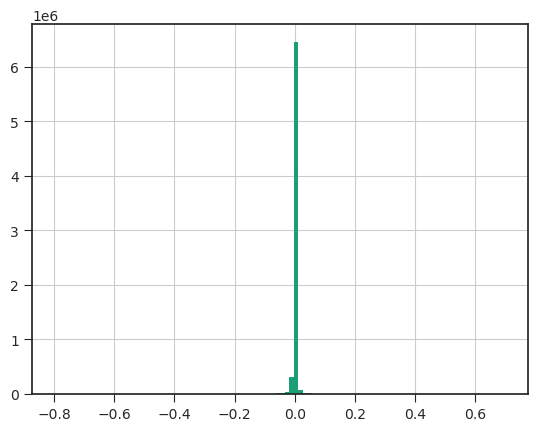

In [5]:
data['difference'].hist(bins = 100)

In [6]:
data['difference_bin'] = pd.cut(
    data['difference'], 
    bins=[-np.inf, -0.1, 0.1, np.inf],
    labels=['<-0.1', 'middle', '>0.1']
)
data.head()

transcript_id  deletion_index_start  deletion_index_end  difference  \
0  ENST00000000233                     0                  30    0.000000   
1  ENST00000000233                    15                  45    0.000000   
2  ENST00000000233                    30                  60    0.000000   
3  ENST00000000233                    45                  75    0.000000   
4  ENST00000000233                    60                  90   -0.001953   

   synapse_probability start_annotation end_annotation  \
0             0.044434             UTR5           UTR5   
1             0.044434             UTR5           UTR5   
2             0.044434             UTR5           UTR5   
3             0.044434             UTR5           UTR5   
4             0.042480             UTR5            CDS   

                           subseq  DDX41_K562_5081  AQR_HepG2_ENCSR018WPY  \
0  CTGCTGCTGCTGCGCCCCATCCCCCCGCGG         0.621414               1.272295   
1  CCCATCCCCCCGCGGCCGGCCAGTTCCAGC         0.645101               1.239188   
2  CCGGCCAGTTCCAGCCCGCACCCCGCGTCG         0.677037               1.241189   
3  CCGCACCCCGCGTCGGTGCCCGCGCCCCTC         0.608661               1.243805   
4  GTGCCCGCGCCCCTCCCCGGGCCCCGCCAT         0.578035               1.230869   

   ...  HNRNPM_HepG2_ENCSR267UCX  DDX5_K562_5094  EIF2B5_K562_5020  \
0  ...                  0.788839        0.518209          0.925792   
1  ...                  0.744100        0.567221          0.867844   
2  ...                  0.761853        0.599932          0.889403   
3  ...                  0.796313        0.547680          0.841227   
4  ...                  0.743185        0.501922          0.834412   

   GRSF1_HepG2_ENCSR668MJX  CTCF_K562_4065  PTBP1_K562_5015  \
0                 1.056194        0.848789         1.077255   
1                 1.051970        0.834800         1.078154   
2                 1.038438        0.839993         1.041651   
3                 1.048819        0.860952         1.044563   
4                 1.037641        0.829843         1.026855   

   BUD13_K562_ENCSR663WES  ZNF800_K562_ENCSR586DGV  annotation  difference_bin  
0                0.794077                 1.044325        UTR5          middle  
1                0.808794                 1.022958        UTR5          middle  
2                0.784075                 1.021055        UTR5          middle  
3                0.765088                 1.027494        UTR5          middle  
4                0.763847                 1.003426         CDS          middle  

[5 rows x 183 columns]

## Mann Whitney U test (score distribution significant impact vs no impact motifs)
- Iterate over RBPs
- Iterate over negative (< -0.1) and positive (> 0.1) impact

In [7]:
exp_list = data.columns[8:-2]  # should contain full list of RBPs
exp_list

Index(['DDX41_K562_5081', 'AQR_HepG2_ENCSR018WPY', 'HNRNPU_HepG2_ENCSR240MVJ',
       'PUM2_K562_ENCSR661ICQ', 'GARS_HepG2_4108', 'PRK2_K562_5064',
       'U2AF1_HepG2_ENCSR328LLU', 'EIF3A_K562_4138', 'SUGP2_HepG2_ENCSR506UPY',
       'KHSRP_HepG2_ENCSR366DGX',
       ...
       'GTF2F1_HepG2_ENCSR265ZIS', 'PSMA1_K562_4017',
       'HNRNPM_HepG2_ENCSR267UCX', 'DDX5_K562_5094', 'EIF2B5_K562_5020',
       'GRSF1_HepG2_ENCSR668MJX', 'CTCF_K562_4065', 'PTBP1_K562_5015',
       'BUD13_K562_ENCSR663WES', 'ZNF800_K562_ENCSR586DGV'],
      dtype='object', length=173)

In [8]:
fdr_thres = 0.05
stat_all = []
progress = trange(len(data.columns[8:-2]), leave=False, position=0)

for exp in exp_list:
    progress.set_description(f"{exp}")
    for cat in ['<-0.1', '>0.1']:
        sample = data.loc[(data['difference_bin']==cat), exp]  # scores for tiles with difference < -0.1 for a given expt (eg. AQR_HepG2_ENCSR018WPY)
        bg = data.loc[(data['difference_bin']=='middle'), exp]  # scores for tiles with difference between -0.1 and 0.1 for a given expt (eg. AQR_HepG2_ENCSR018WPY)
        mw, pv = mannwhitneyu(
            sample, 
            bg, 
            alternative='greater'
        )
        median_difference = sample.median() - bg.median()
        stat_all.append([mw, pv, exp, cat, median_difference])
    progress.update(1)
    
stat_all = pd.DataFrame(
    stat_all, 
    columns = ['MannwhitneyU', 'pvalue', 'RBPNet_model', 'category', 'median difference']
)
stat_all.head()

ZNF800_K562_ENCSR586DGV: 100%|██████████| 173/173 [38:59<00:00, 13.62s/it]   

MannwhitneyU         pvalue              RBPNet_model category  \
0  6.597080e+10  2.219896e-254           DDX41_K562_5081    <-0.1   
1  1.850529e+10  2.244043e-126           DDX41_K562_5081     >0.1   
2  6.836932e+10   0.000000e+00     AQR_HepG2_ENCSR018WPY    <-0.1   
3  1.605133e+10   2.265465e-08     AQR_HepG2_ENCSR018WPY     >0.1   
4  6.151416e+10   2.720064e-63  HNRNPU_HepG2_ENCSR240MVJ    <-0.1   

   median difference  
0           0.007828  
1           0.011556  
2           0.005530  
3           0.001083  
4           0.004376

# Sanity check (DDX41)

(16462,) (6949014,)
result and median difference with alternative=GREATER: MannwhitneyuResult(statistic=78933621996.5, pvalue=0.0), 0.05993004999999996
result and median difference with alternative=LESS: MannwhitneyuResult(statistic=78933621996.5, pvalue=1.0), 0.05993004999999996
result and median difference with alternative=two-tailed: MannwhitneyuResult(statistic=78933621996.5, pvalue=0.0), 0.05993004999999996


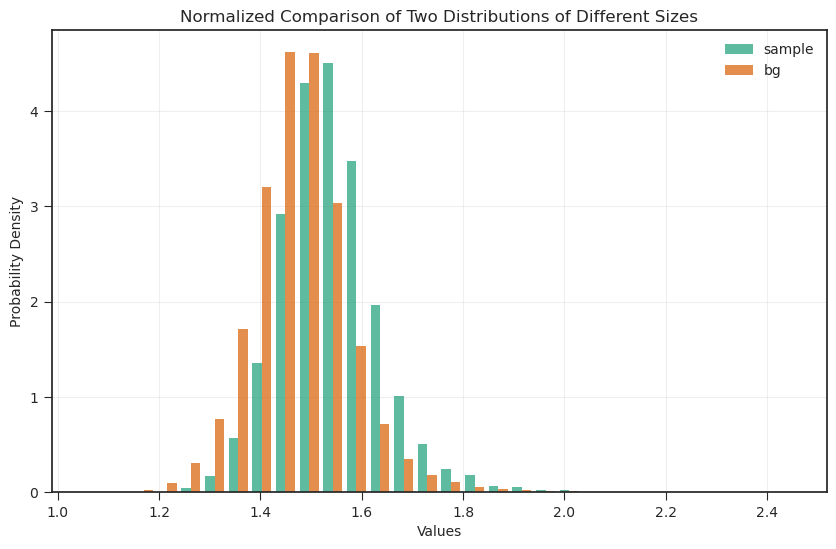

In [9]:
exp='TARDBP_HepG2_4110'
sample = data.loc[(data['difference_bin']=='<-0.1'), exp]
bg = data.loc[(data['difference_bin']=='middle'), exp] # .sample(n=len(sample), random_state=42)

print(sample.shape, bg.shape)
# Create a single figure
plt.figure(figsize=(10, 6))

# Plot both series on the same histogram (overlapping)
x = plt.hist([sample, bg], bins=30, alpha=0.7, 
         label=['sample', 'bg'], density=True)
# Add labels and title
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.title('Normalized Comparison of Two Distributions of Different Sizes')
plt.legend()
plt.grid(alpha=0.3)

res = mannwhitneyu(
    sample, 
    bg, 
    alternative='greater',
)
median_difference = sample.median() - bg.median()
res, median_difference, sample.mean() - bg.mean()
print(f"result and median difference with alternative=GREATER: {res}, {median_difference}")

res = mannwhitneyu(
    sample, 
    bg, 
    alternative='less',
)
median_difference = sample.median() - bg.median()
res, median_difference, sample.mean() - bg.mean()
print(f"result and median difference with alternative=LESS: {res}, {median_difference}")

res = mannwhitneyu(
    sample, 
    bg, 
    alternative='two-sided',
)
median_difference = sample.median() - bg.median()
res, median_difference, sample.mean() - bg.mean()
print(f"result and median difference with alternative=two-tailed: {res}, {median_difference}")

In [10]:
data.head()[['transcript_id', 'deletion_index_start', 'deletion_index_end', 'difference', 'synapse_probability']]

transcript_id  deletion_index_start  deletion_index_end  difference  \
0  ENST00000000233                     0                  30    0.000000   
1  ENST00000000233                    15                  45    0.000000   
2  ENST00000000233                    30                  60    0.000000   
3  ENST00000000233                    45                  75    0.000000   
4  ENST00000000233                    60                  90   -0.001953   

   synapse_probability  
0             0.044434  
1             0.044434  
2             0.044434  
3             0.044434  
4             0.042480

In [11]:
stat_all['sig'],stat_all['FDR'] = fdrcorrection(stat_all['pvalue'], alpha = fdr_thres)
#stat_all['l2or'] = np.log2(stat_all['odds ratio'])
stat_all['-log10 FDR']= -np.log10(stat_all['FDR']+stat_all.loc[stat_all['pvalue']>0, 'pvalue'].min())

In [12]:
stat_all.head()

MannwhitneyU         pvalue              RBPNet_model category  \
0  6.597080e+10  2.219896e-254           DDX41_K562_5081    <-0.1   
1  1.850529e+10  2.244043e-126           DDX41_K562_5081     >0.1   
2  6.836932e+10   0.000000e+00     AQR_HepG2_ENCSR018WPY    <-0.1   
3  1.605133e+10   2.265465e-08     AQR_HepG2_ENCSR018WPY     >0.1   
4  6.151416e+10   2.720064e-63  HNRNPU_HepG2_ENCSR240MVJ    <-0.1   

   median difference   sig            FDR  -log10 FDR  
0           0.007828  True  6.797203e-254  253.167670  
1           0.011556  True  5.074765e-126  125.294584  
2           0.005530  True   0.000000e+00  310.080093  
3           0.001083  True   2.969133e-08    7.527370  
4           0.004376  True   4.705711e-63   62.327375

In [13]:
tabledir=Path('/tscc/nfs/home/hsher/ps-yeolab5/ENCODE_paper_tables')
annotation = pd.read_csv(tabledir/'Hierachial_class.csv')
syngo = pd.read_excel('synGo/syngo_genes.xlsx')

In [14]:
stat_all['RBP_official']=stat_all['RBPNet_model'].map(annotation.set_index('id')['RBP_official'])
stat_all['is_SynGo'] = stat_all['RBP_official'].isin(syngo['hgnc_symbol'])
stat_all.to_csv(outdir / 'neural_network_enrichment_human_30bp.csv')

In [15]:
stat_all['sig'].value_counts()

sig
True     280
False     66
Name: count, dtype: int64

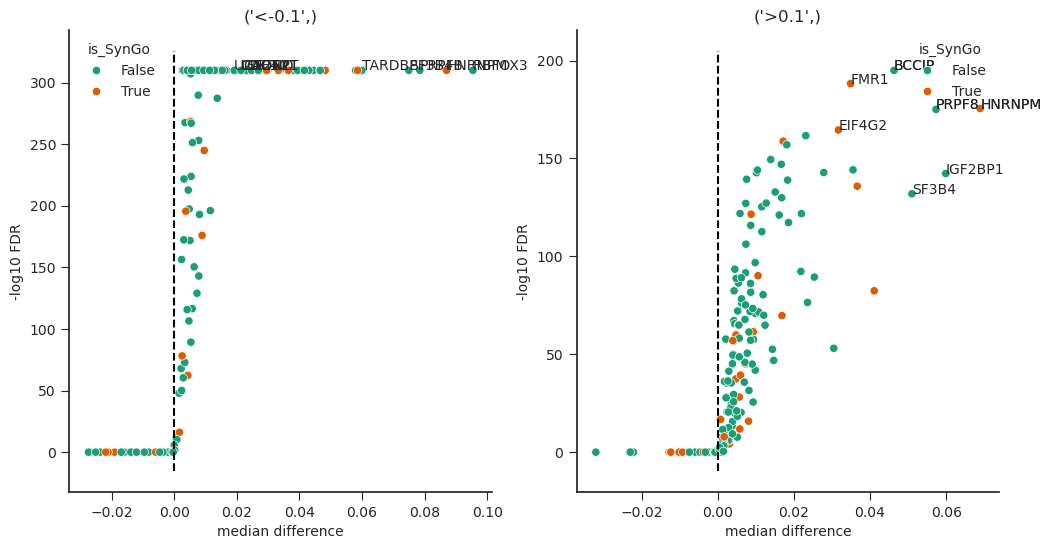

In [16]:
f, axes = plt.subplots(1,2, figsize = (12,6))
for ax, (name, group) in zip(axes.flatten(),stat_all.groupby(by = ['category'])):
    sns.scatterplot(data = group, x = 'median difference', y = '-log10 FDR', ax = ax, hue = 'is_SynGo')
    ax.set_title(name)
    sig1 = group.loc[(group['sig'])].sort_values(by = 'median difference', ascending = False).iloc[:5]
    sig2 = group.loc[(group['sig'])].sort_values(by = '-log10 FDR', ascending = False).iloc[:5]
    sig = pd.concat([sig1, sig2], axis = 0)
    for index, row in sig.iterrows():
        ax.text(row['median difference'], row['-log10 FDR'], row['RBPNet_model'].split('_')[0])
    ax.vlines(x = 0, ymin = ax.get_ylim()[0],ymax = ax.get_ylim()[1], linestyle = 'dashed', color = 'black')
sns.despine()

In [17]:
stat_all.loc[(stat_all['category']=='<-0.1')&(stat_all['sig'])].sort_values(by = 'median difference')

MannwhitneyU        pvalue             RBPNet_model category  \
280  5.839361e+10  1.721809e-06  TAF15_HepG2_ENCSR841EQA    <-0.1   
86   5.898825e+10  1.825965e-12          CXXC1_K562_4088    <-0.1   
256  5.886952e+10  4.311975e-11          SF3A1_K562_4048    <-0.1   
36   6.096951e+10  7.948629e-49           LARS_K562_5082    <-0.1   
250  5.933743e+10  4.986925e-17        ELAVL1_HepG2_4083    <-0.1   
..            ...           ...                      ...      ...   
300  7.893362e+10  0.000000e+00        TARDBP_HepG2_4110    <-0.1   
70   7.609456e+10  0.000000e+00  SF3B4_HepG2_ENCSR279UJF    <-0.1   
84   7.684796e+10  0.000000e+00  PRPF8_HepG2_ENCSR121NVA    <-0.1   
40   7.554450e+10  0.000000e+00  HNRNPM_K562_ENCSR412NOW    <-0.1   
120  7.869679e+10  0.000000e+00        RBFOX3_HepG2_4023    <-0.1   

     median difference   sig           FDR  -log10 FDR RBP_official  is_SynGo  
280           0.000023  True  2.214669e-06    5.654691        TAF15     False  
86            0.000682  True  2.458303e-12   11.609365        CXXC1     False  
256           0.000851  True  5.738243e-11   10.241221        SF3A1     False  
36            0.001553  True  1.255811e-48   47.901076        LARS1     False  
250           0.001723  True  6.874406e-17   16.162765       ELAVL1      True  
..                 ...   ...           ...         ...          ...       ...  
300           0.059930  True  0.000000e+00  310.080093       TARDBP     False  
70            0.074914  True  0.000000e+00  310.080093        SF3B4     False  
84            0.078450  True  0.000000e+00  310.080093        PRPF8     False  
40            0.086982  True  0.000000e+00  310.080093       HNRNPM      True  
120           0.095387  True  0.000000e+00  310.080093       RBFOX3     False  

[144 rows x 10 columns]

In [18]:
stat_all.loc[stat_all['RBPNet_model'].str.contains('FMR')]

MannwhitneyU         pvalue           RBPNet_model category  \
266  7.205950e+10   0.000000e+00  FMR1_K562_ENCSR331VNX    <-0.1   
267  1.923083e+10  2.234510e-189  FMR1_K562_ENCSR331VNX     >0.1   

     median difference   sig            FDR  -log10 FDR RBP_official  is_SynGo  
266           0.033256  True   0.000000e+00  310.080093         FMR1      True  
267           0.034897  True  6.235005e-189  188.205163         FMR1      True

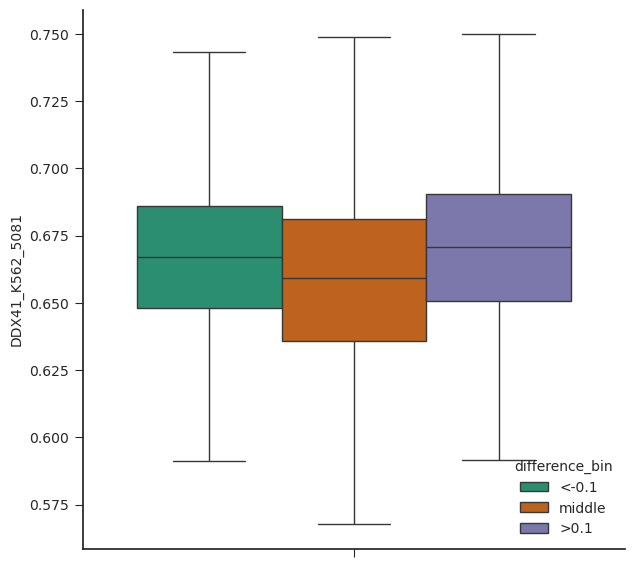

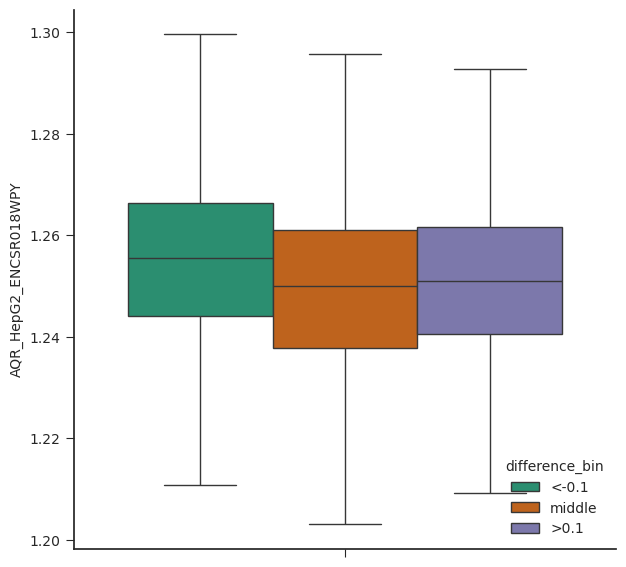

In [19]:
for exp in exp_list[:2]:
    fig, ax = plt.subplots(figsize=(7,7))
    sns.boxplot(data,  
                y = exp, 
                hue = 'difference_bin', 
                showfliers=False, ax=ax)
    sns.despine()
    sns.move_legend(ax, "lower right")
    fig.savefig(os.path.join('/tscc/nfs/home/bay001/projects/karen_synapse_20240529/permanent_data/charlene_work/box_plots_all', f"{exp}.boxplot.png"))

 12%|█▏        | 20/173 [02:41<20:42,  8.12s/it]                          /tmp/ipykernel_227596/2295104344.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(7,7))
100%|██████████| 173/173 [23:10<00:00,  7.94s/it]

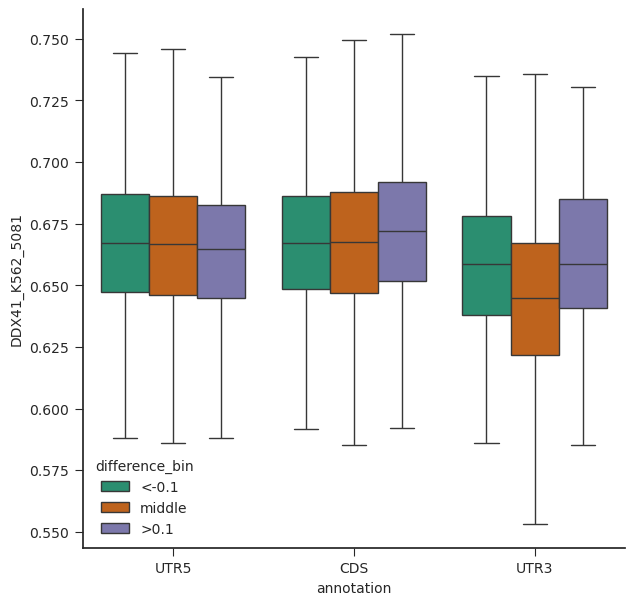

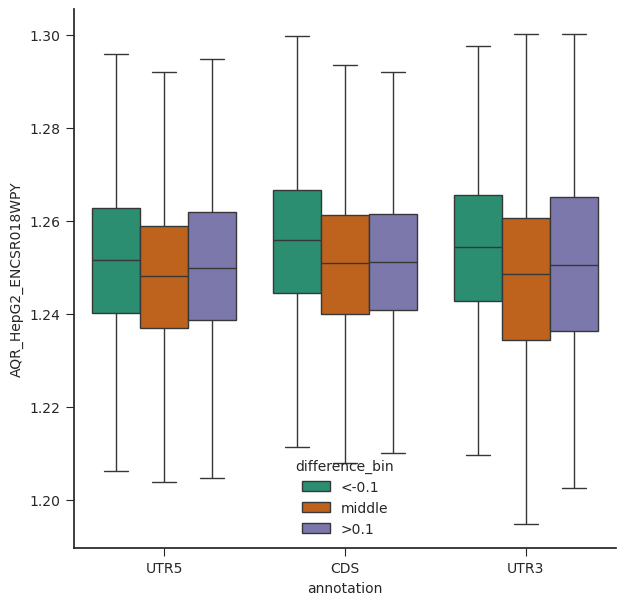

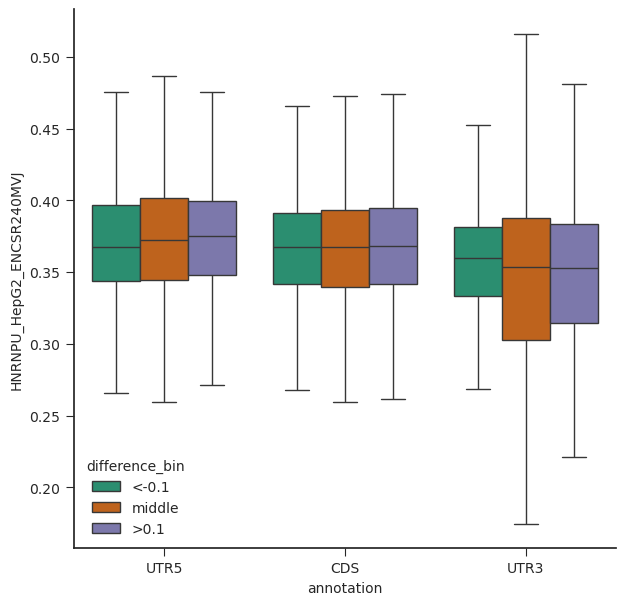

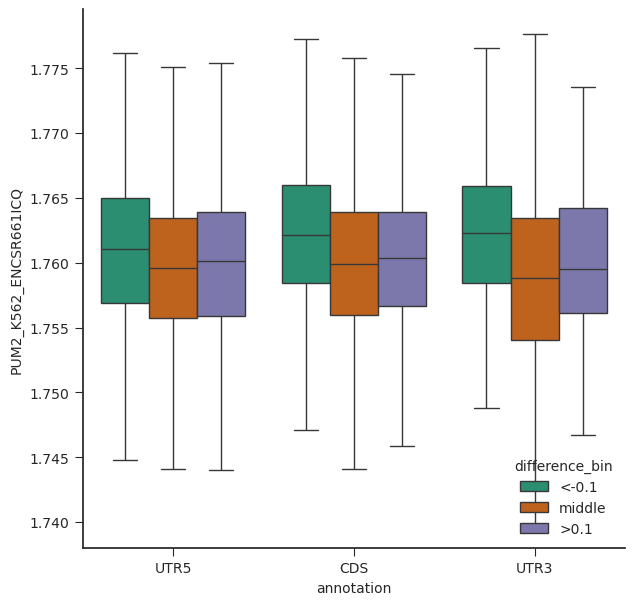

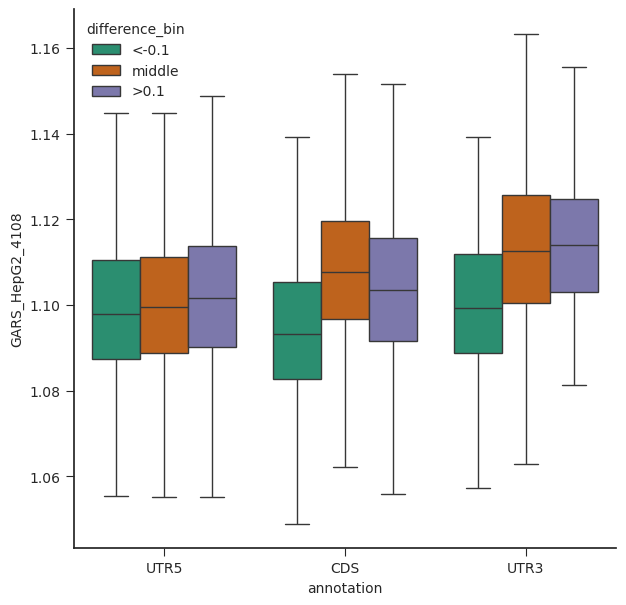

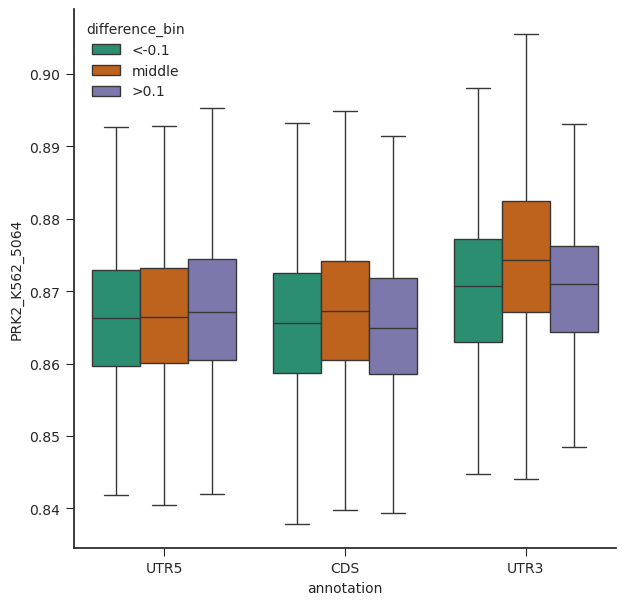

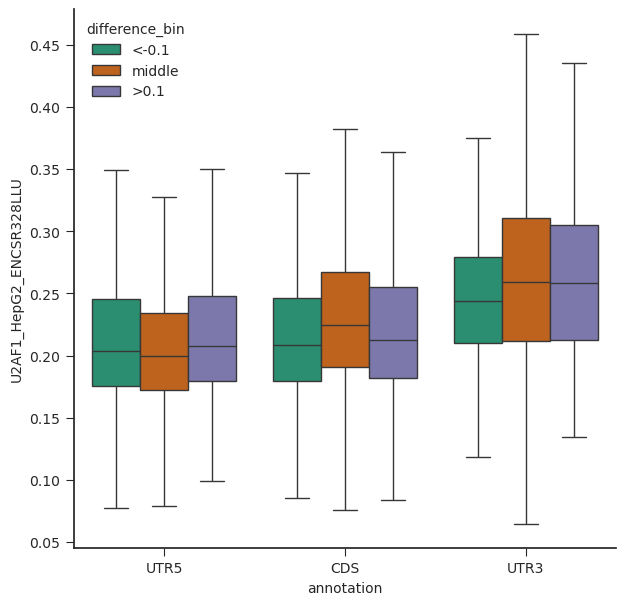

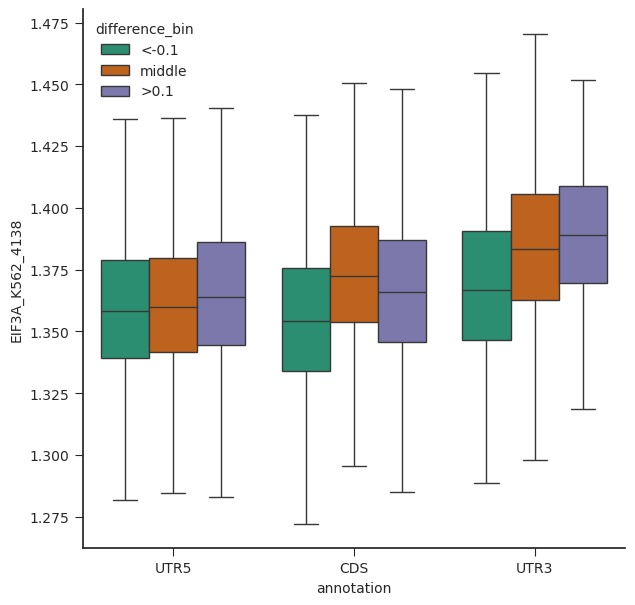

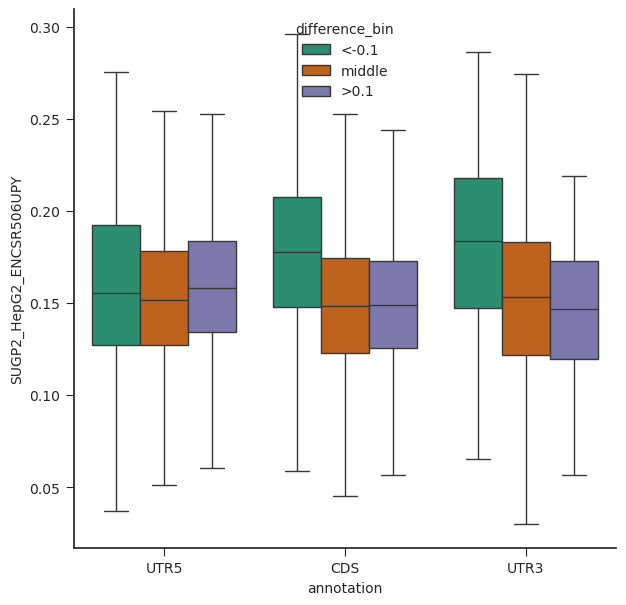

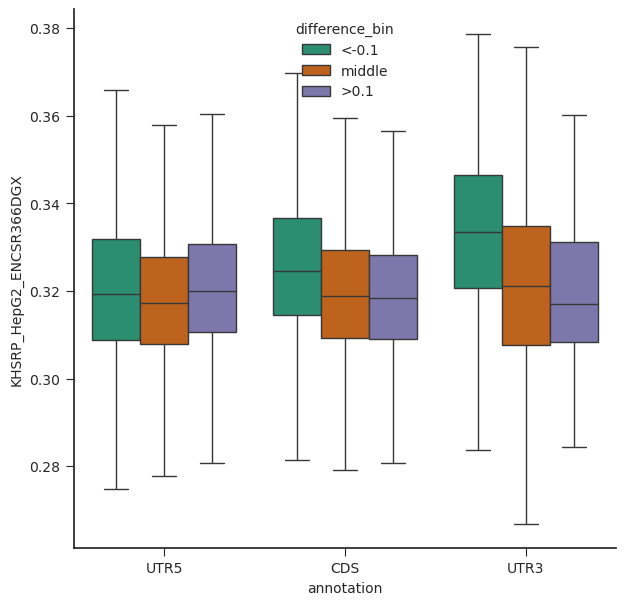

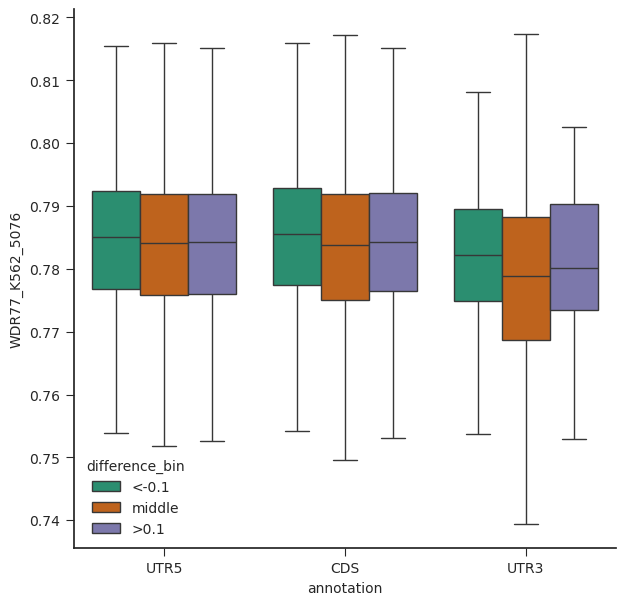

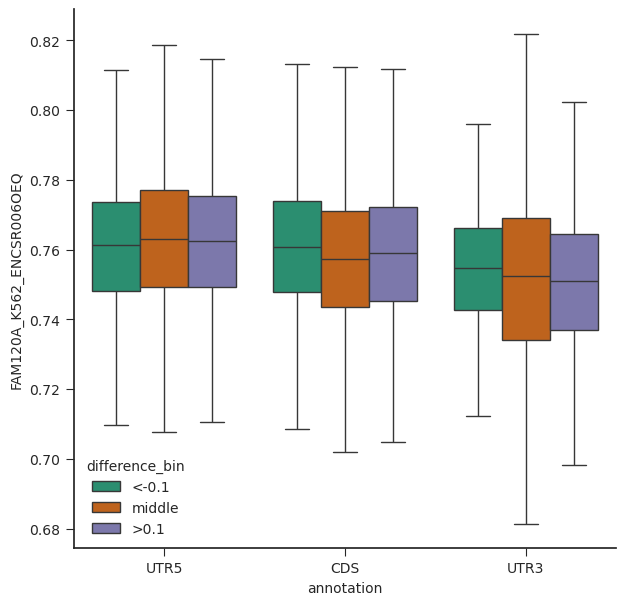

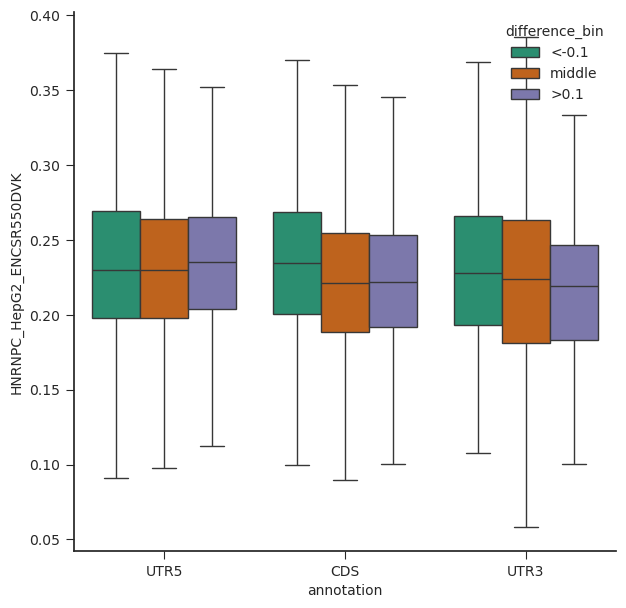

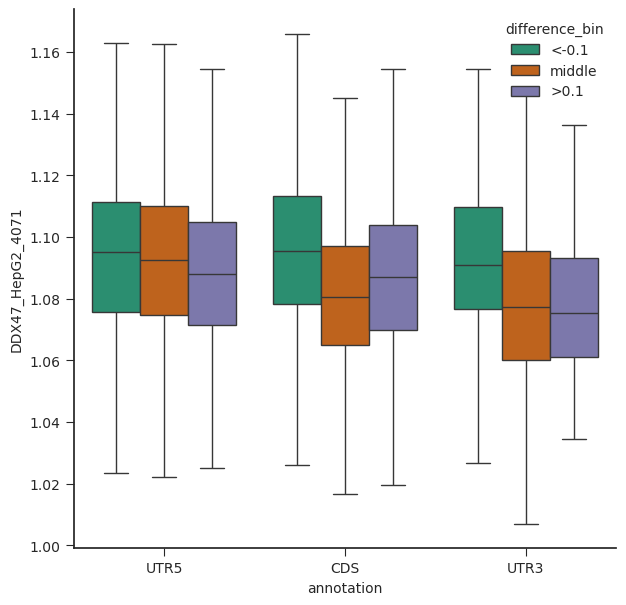

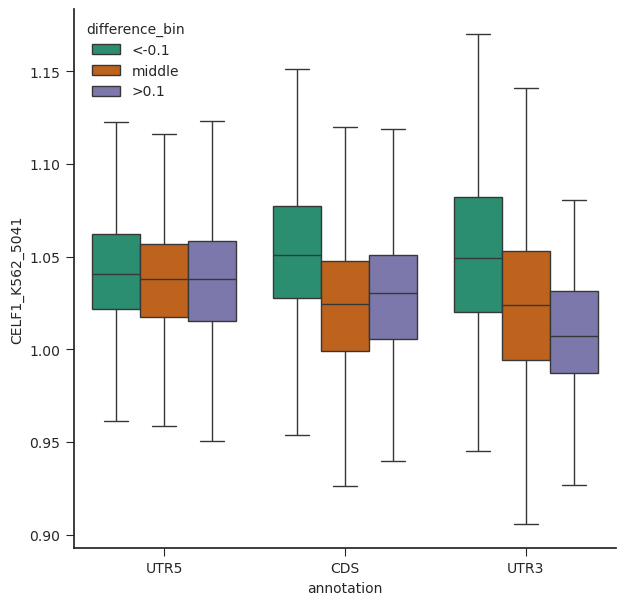

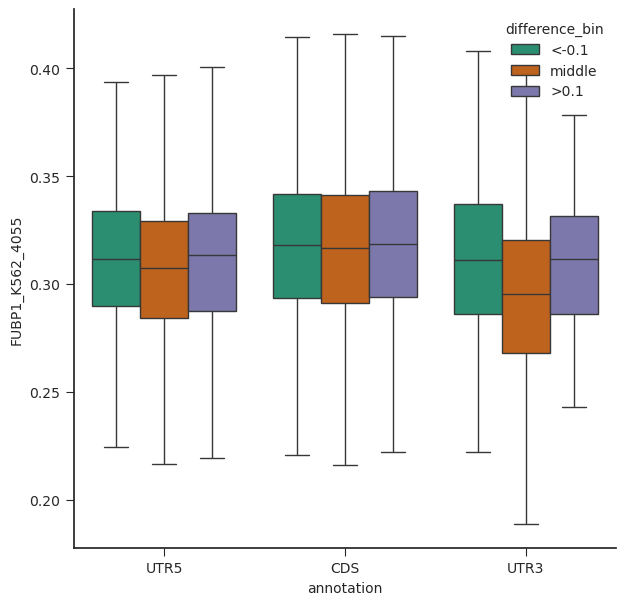

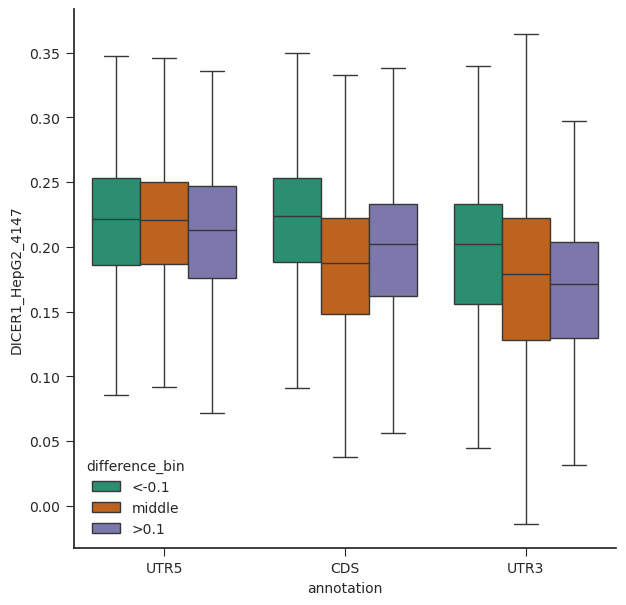

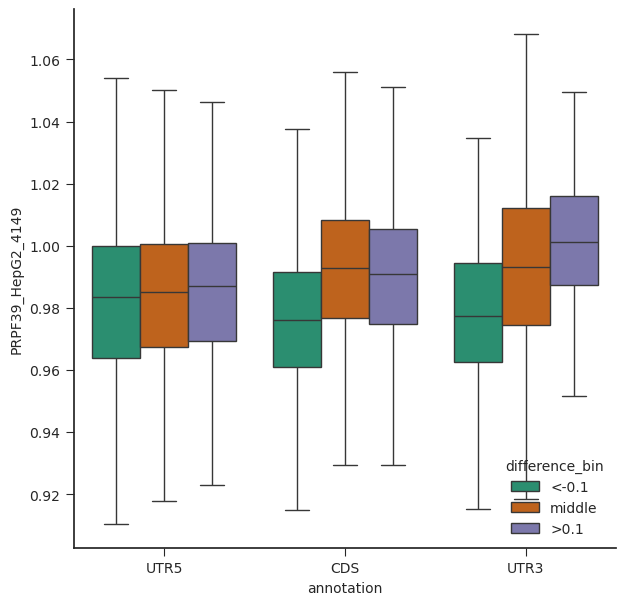

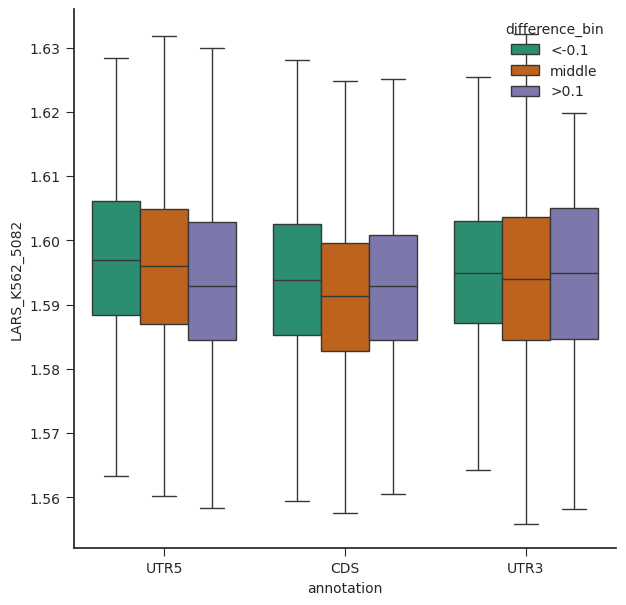

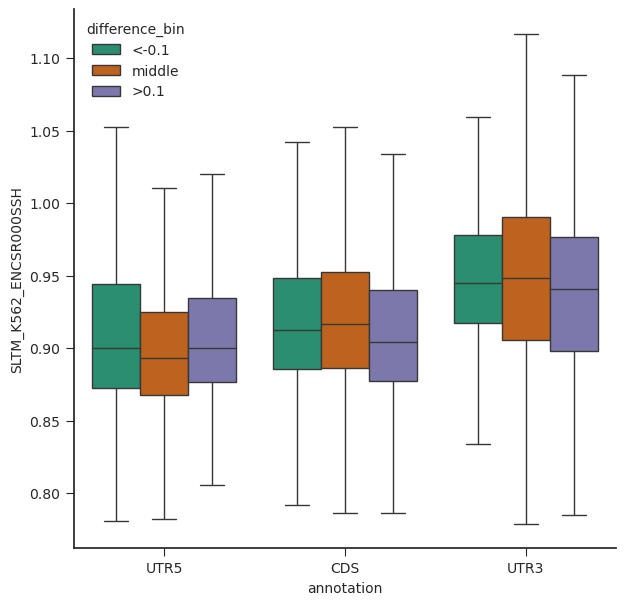

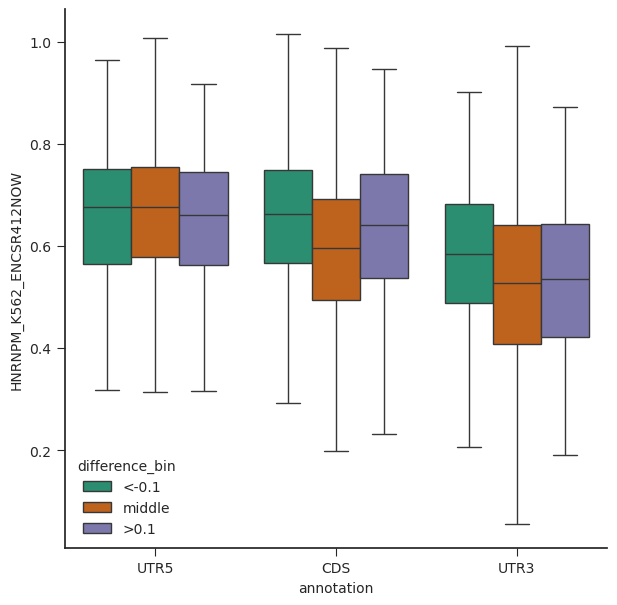

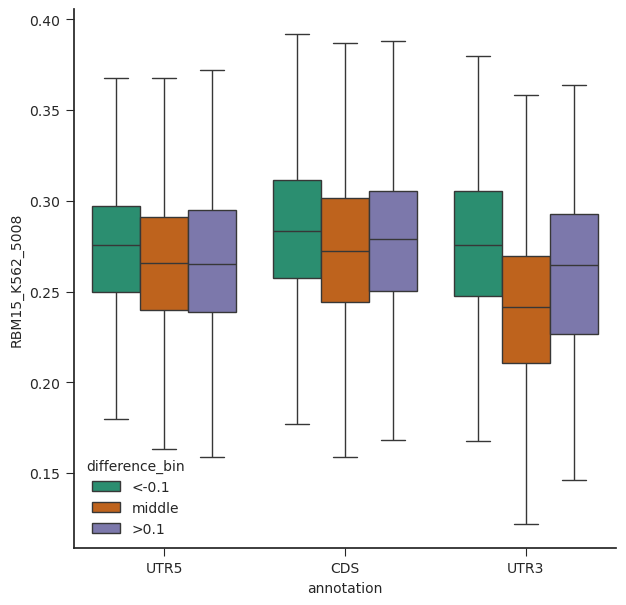

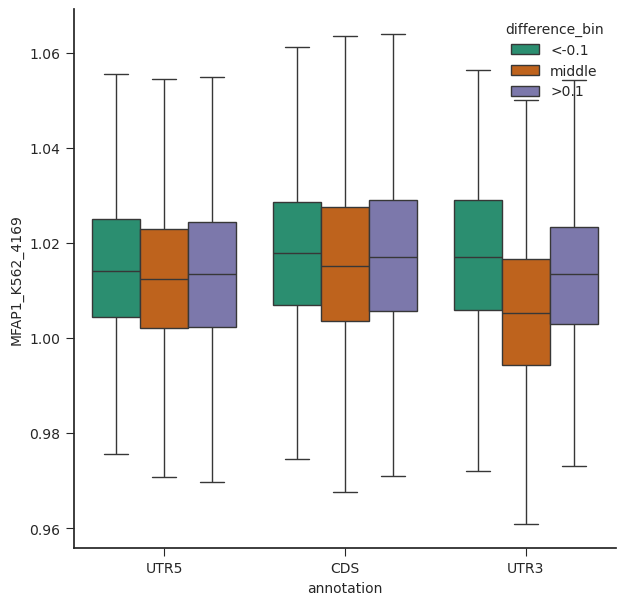

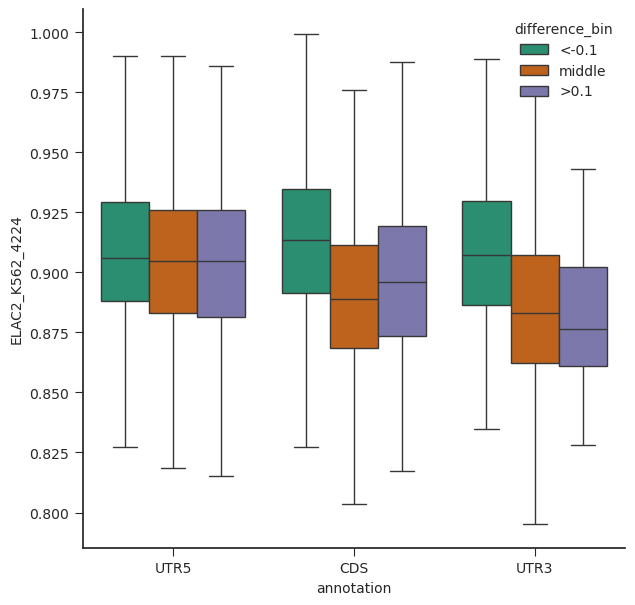

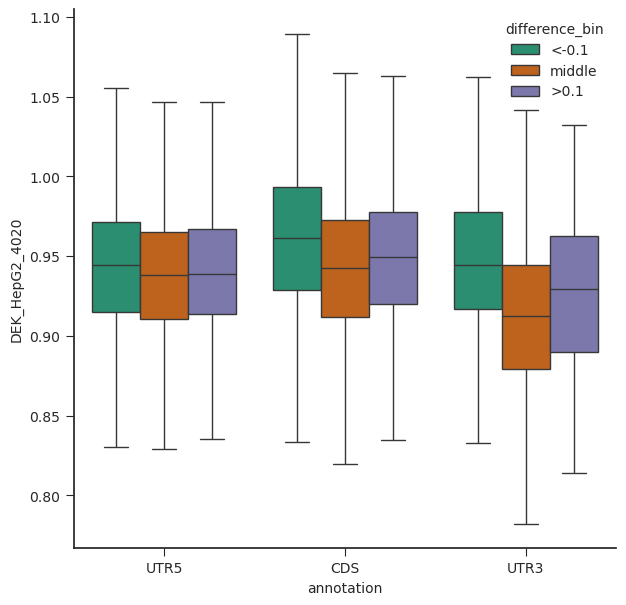

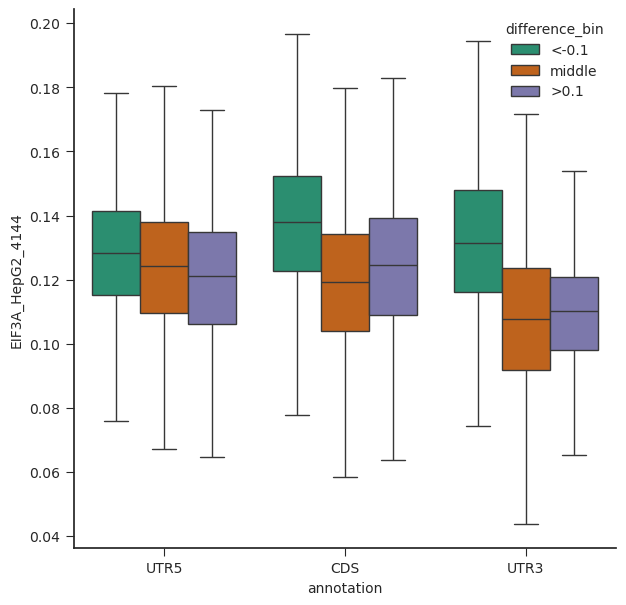

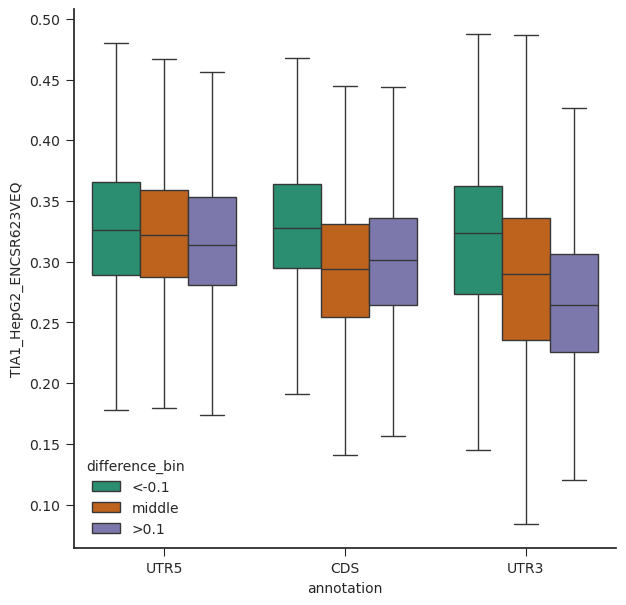

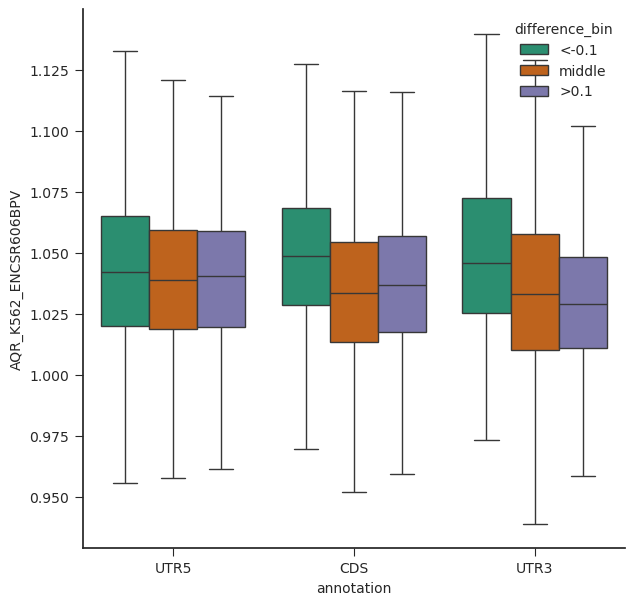

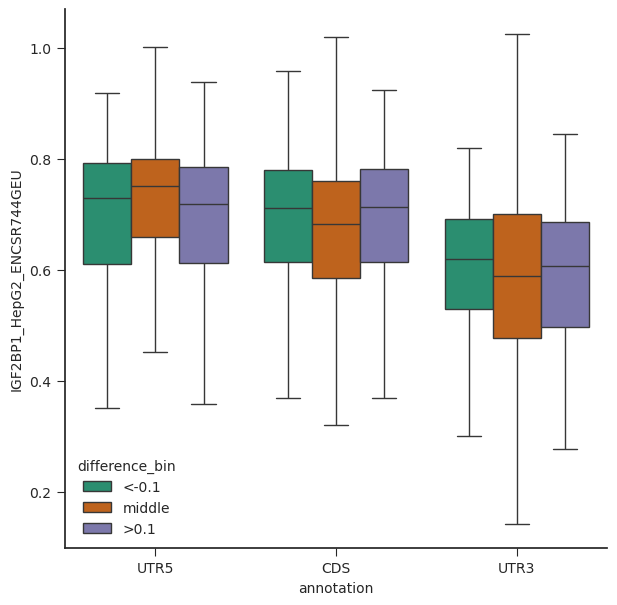

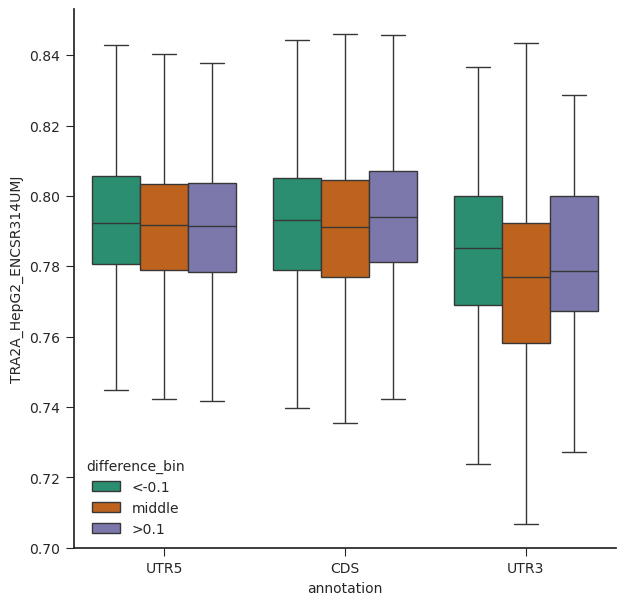

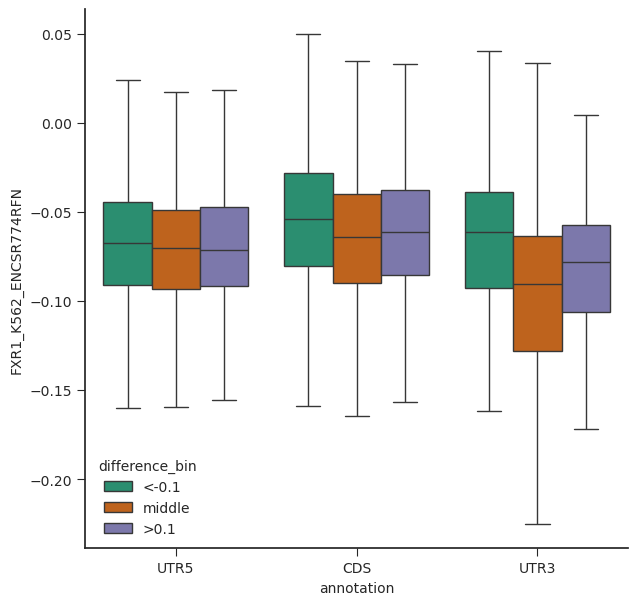

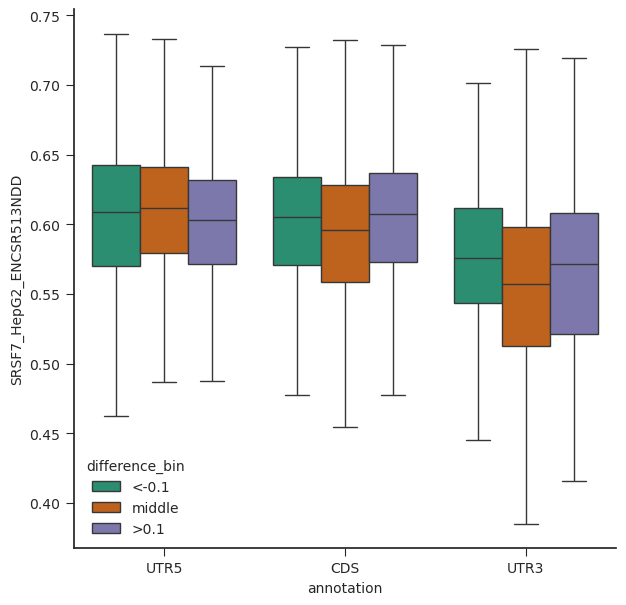

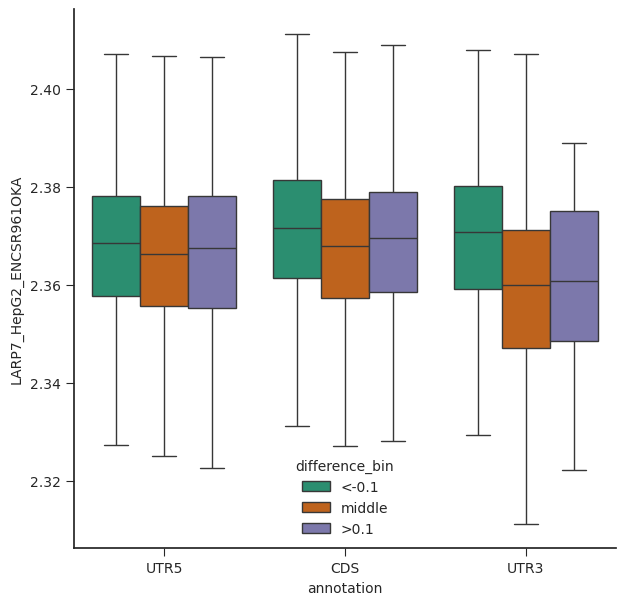

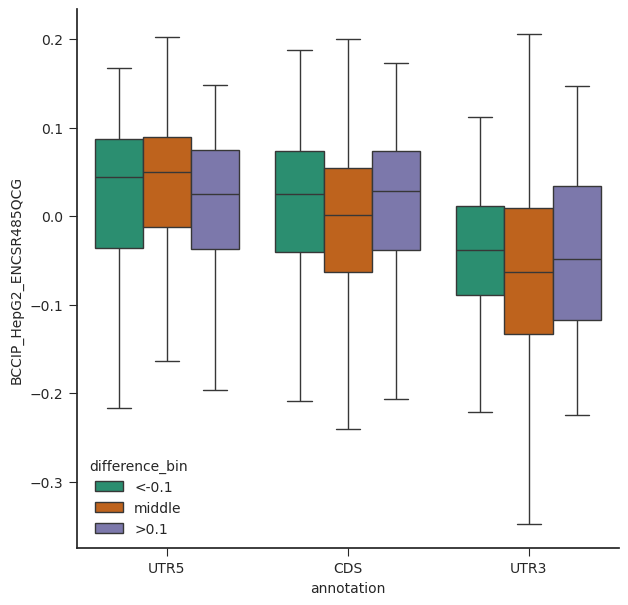

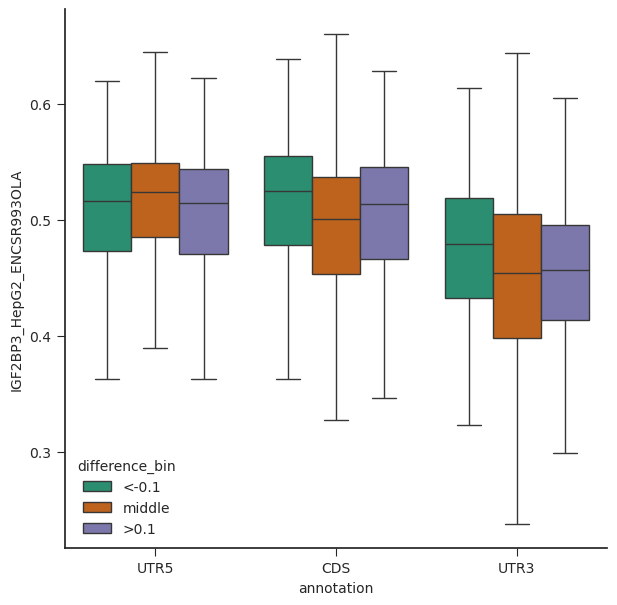

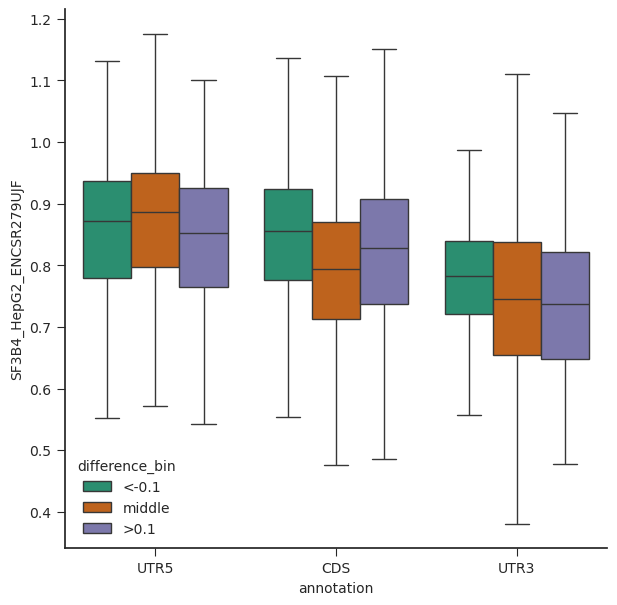

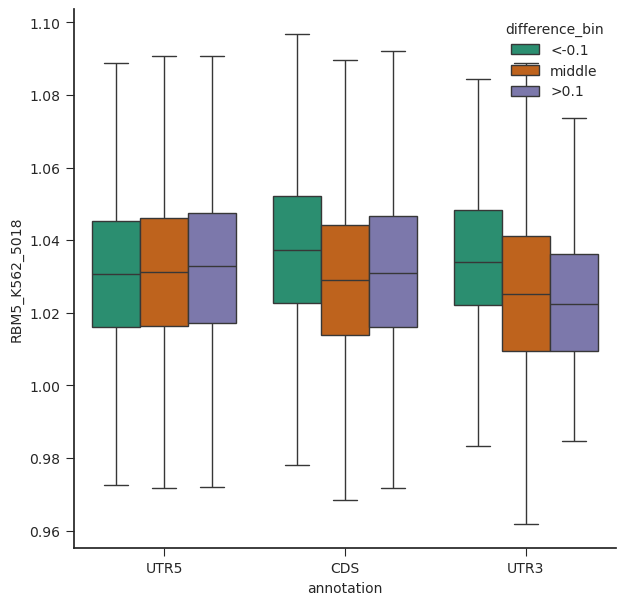

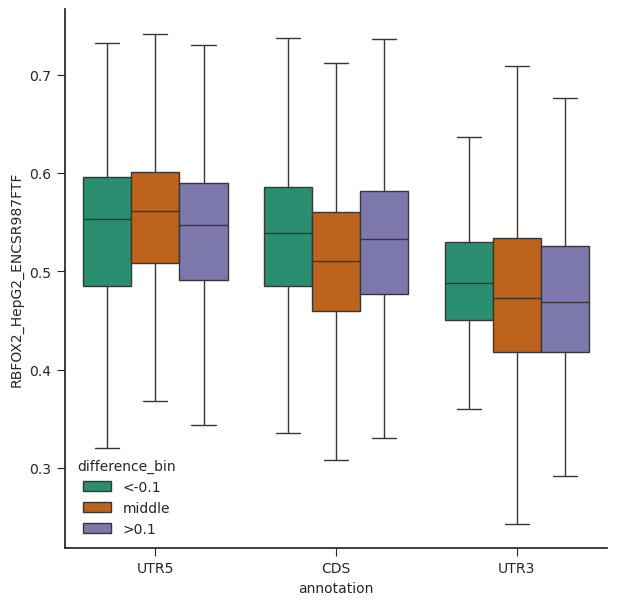

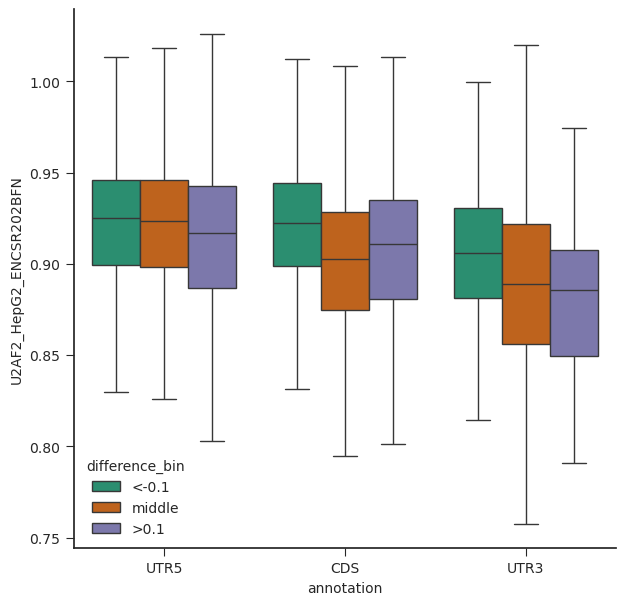

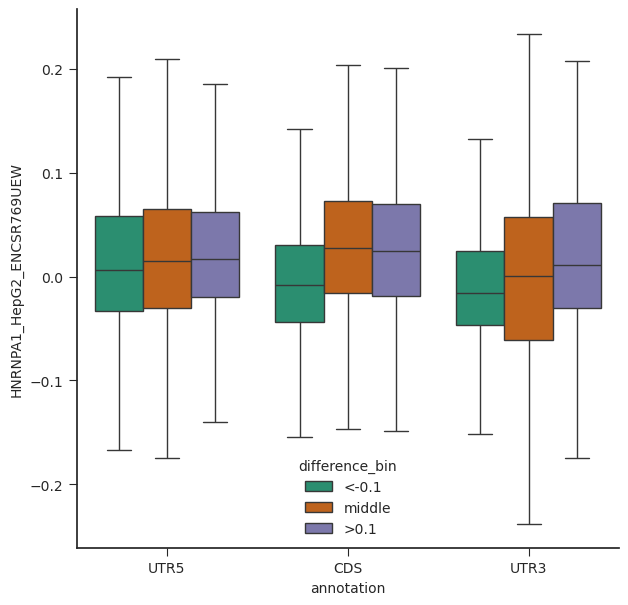

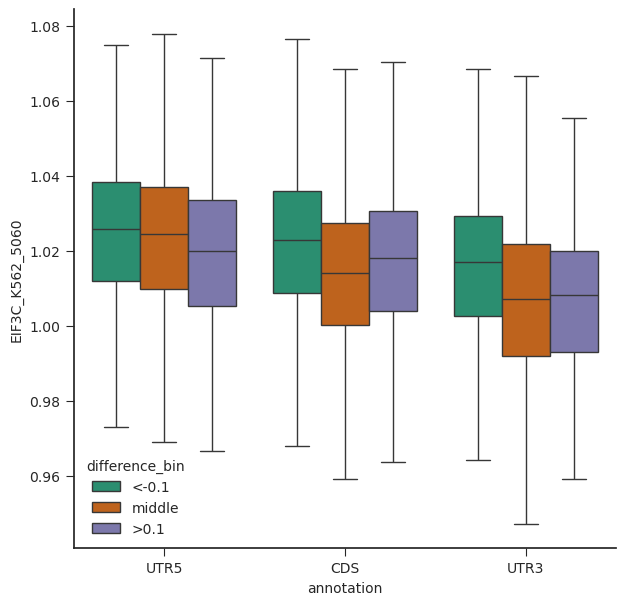

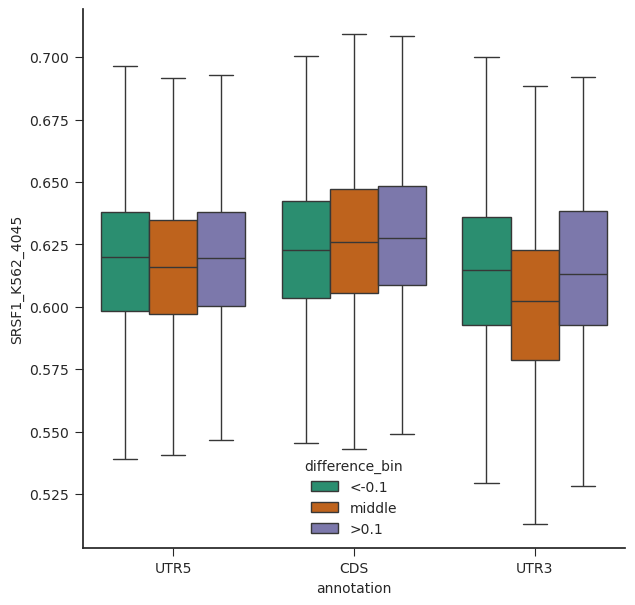

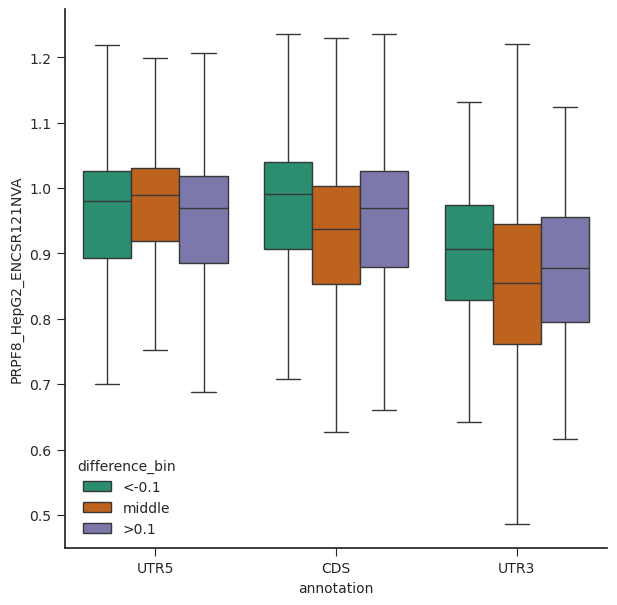

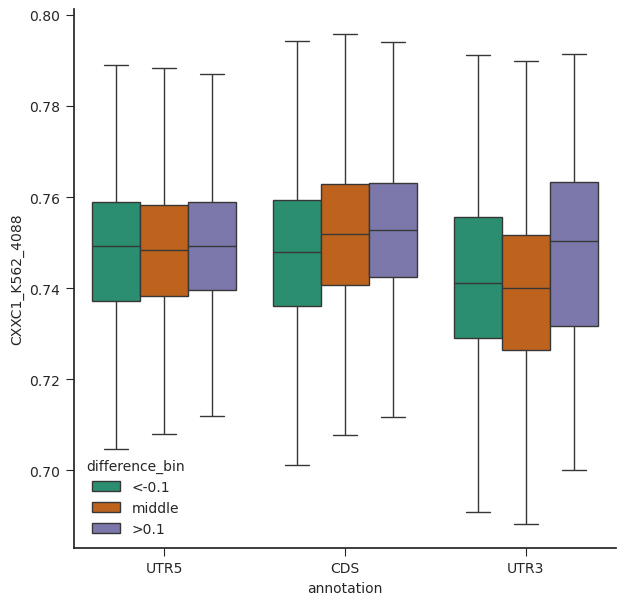

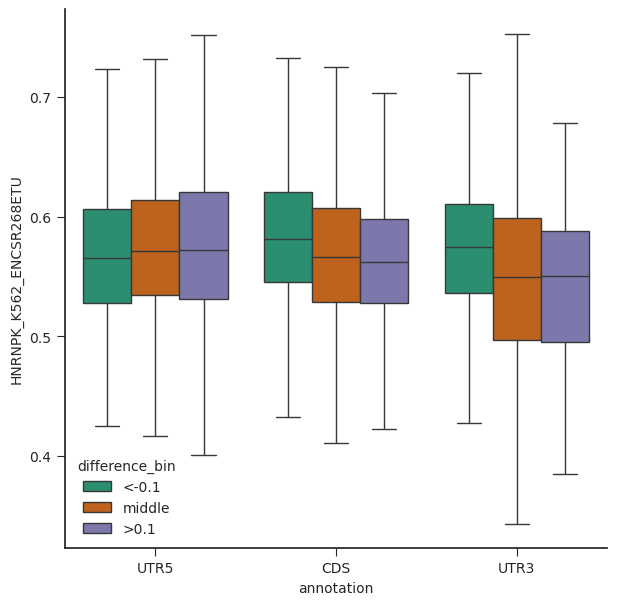

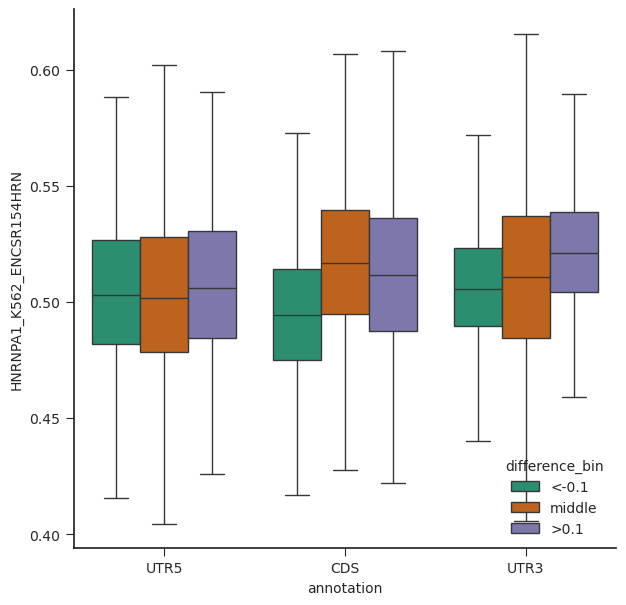

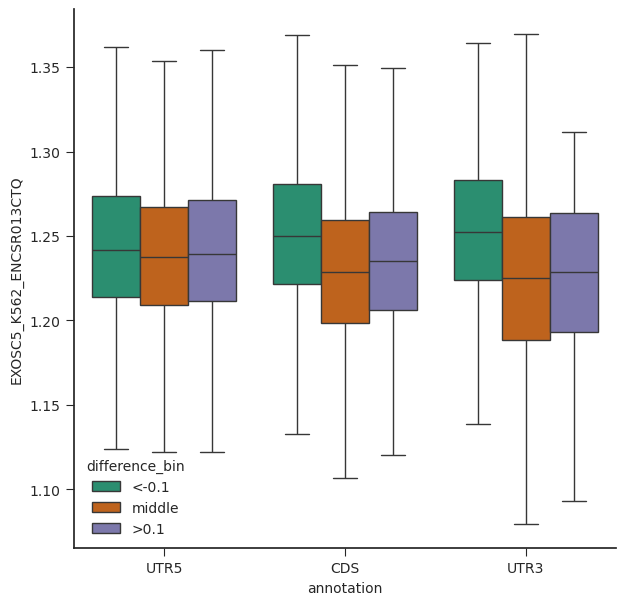

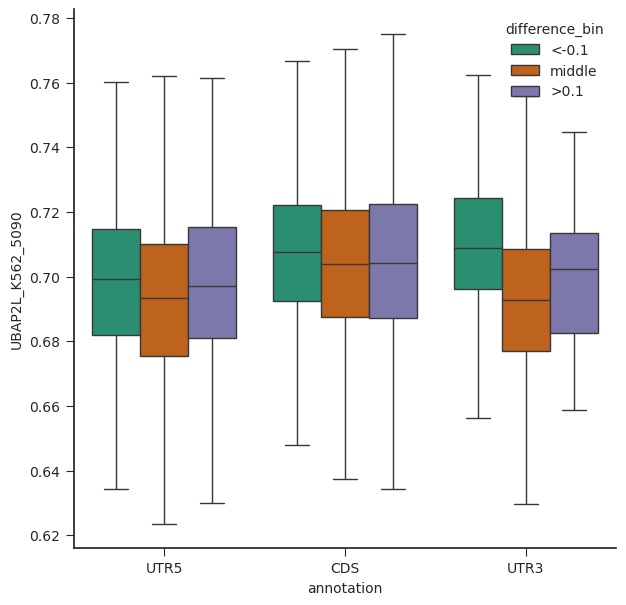

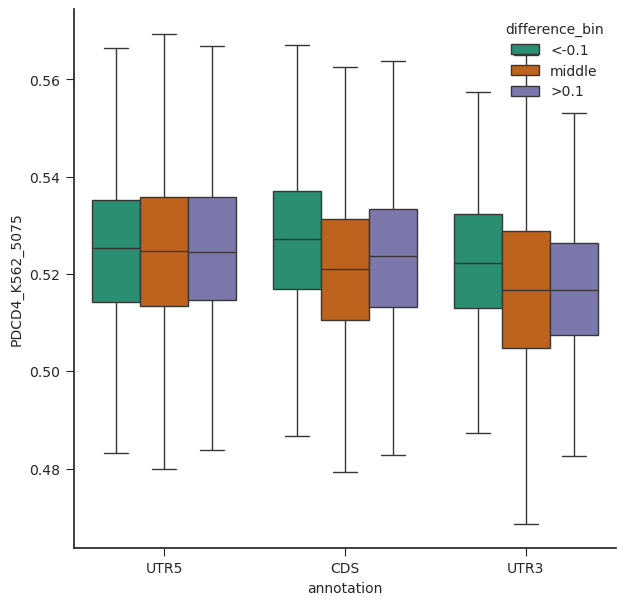

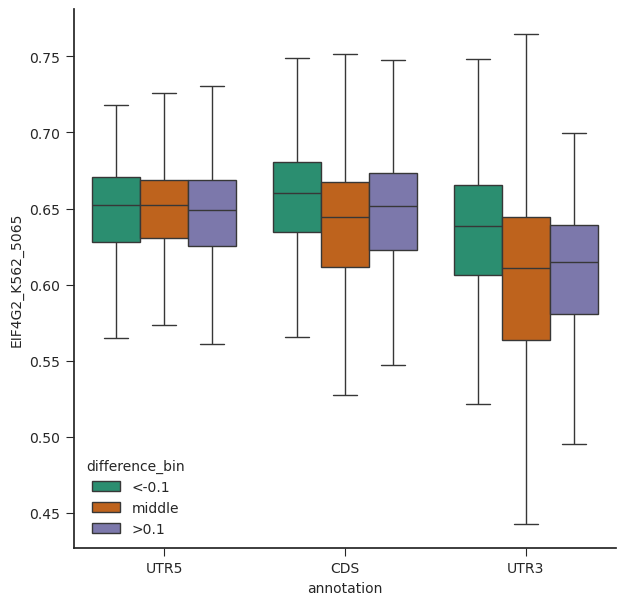

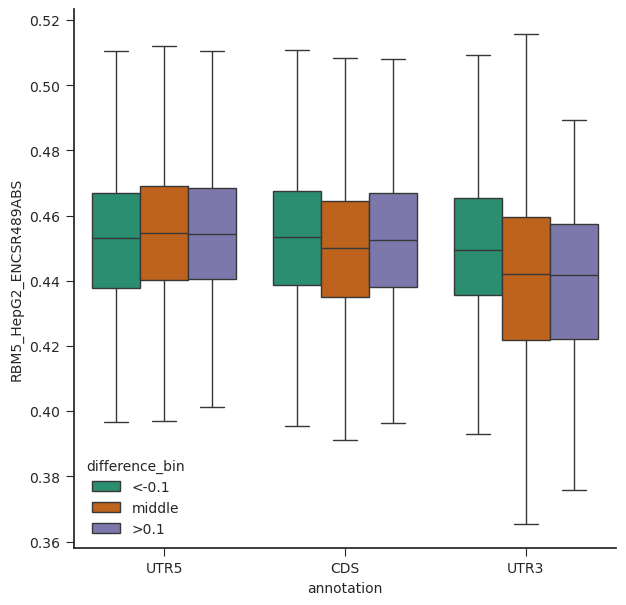

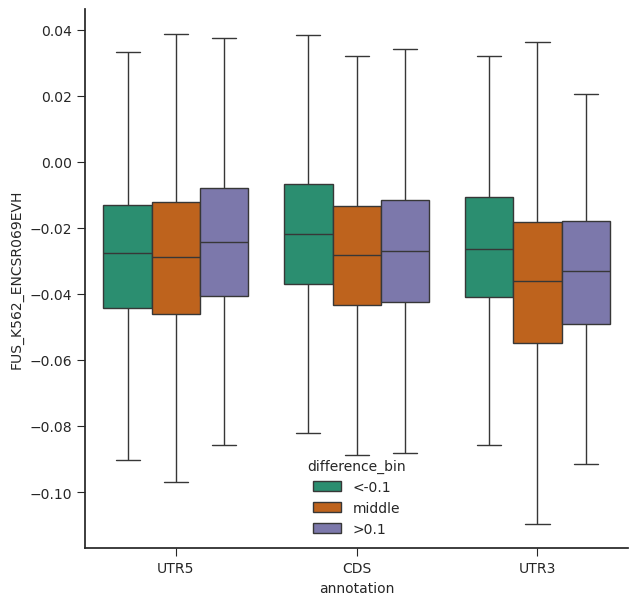

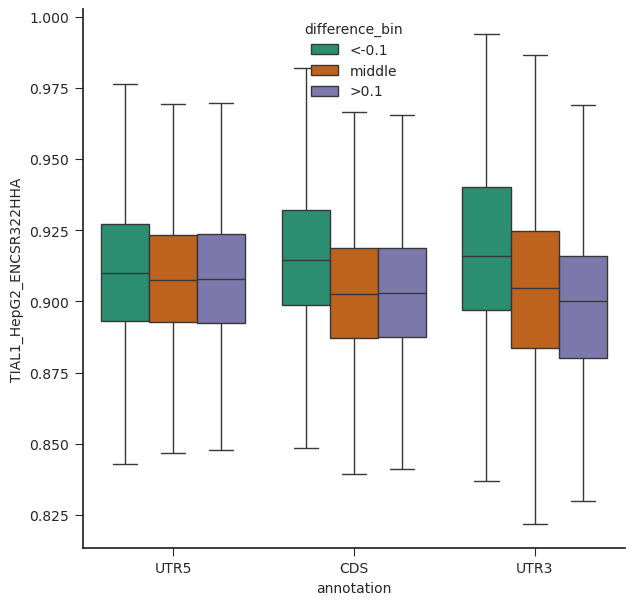

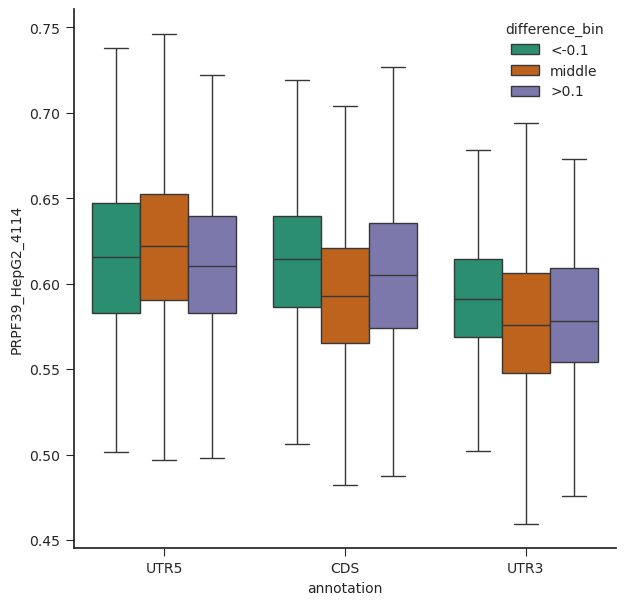

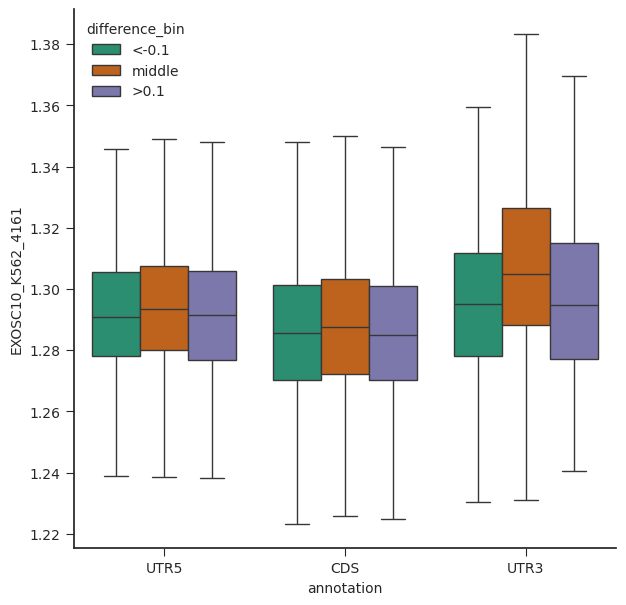

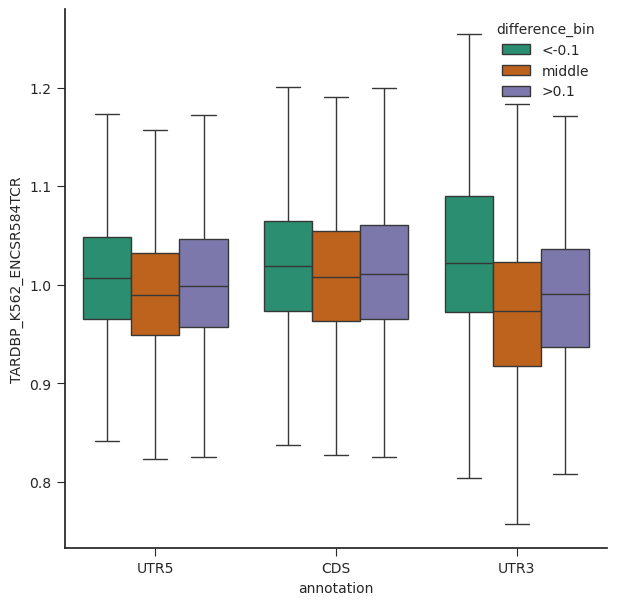

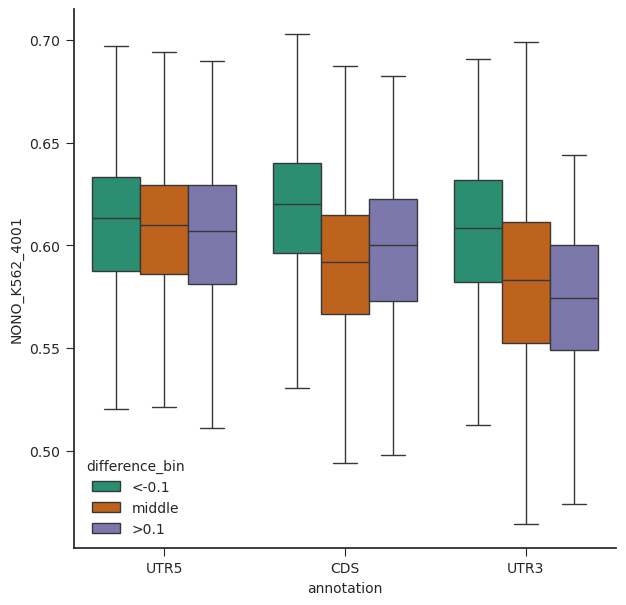

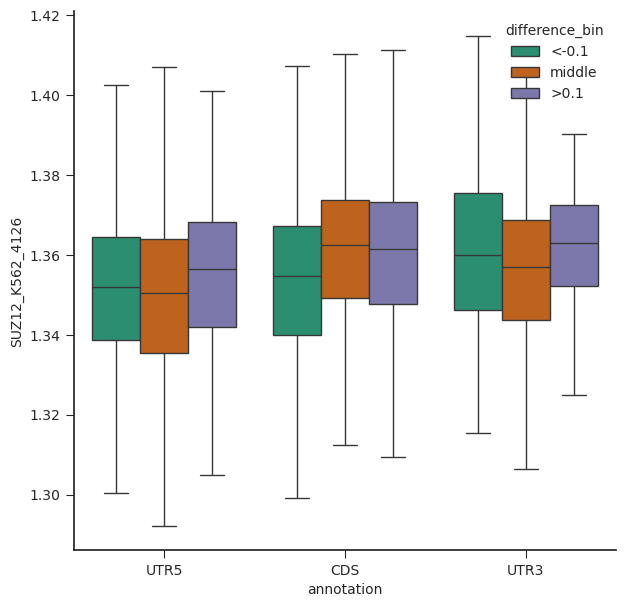

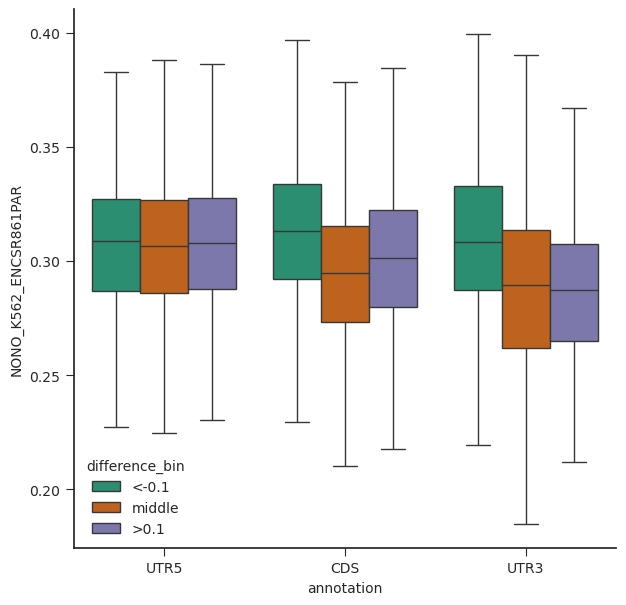

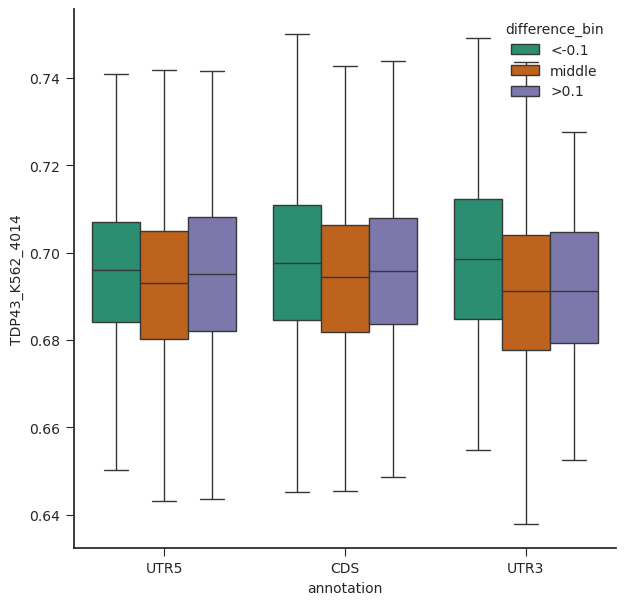

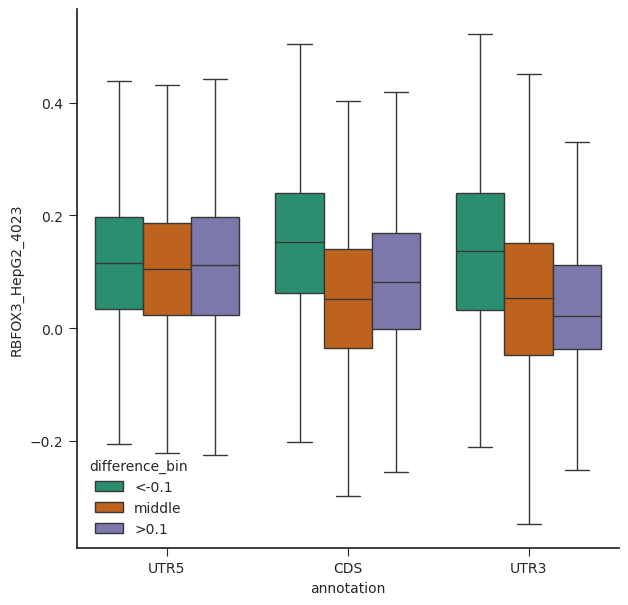

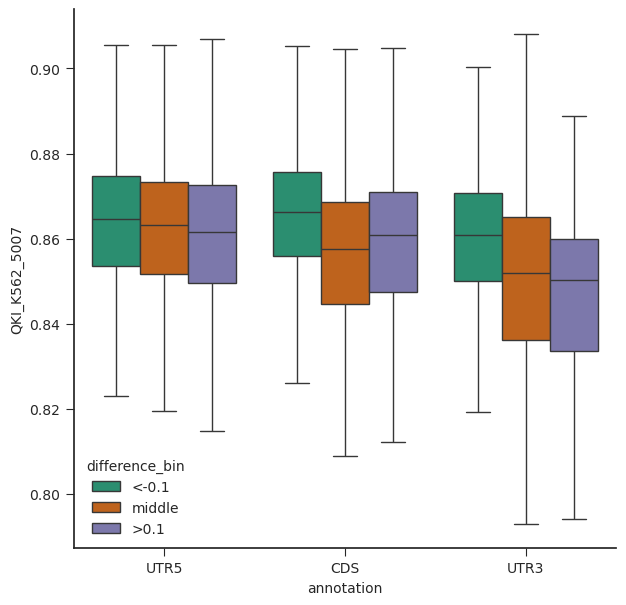

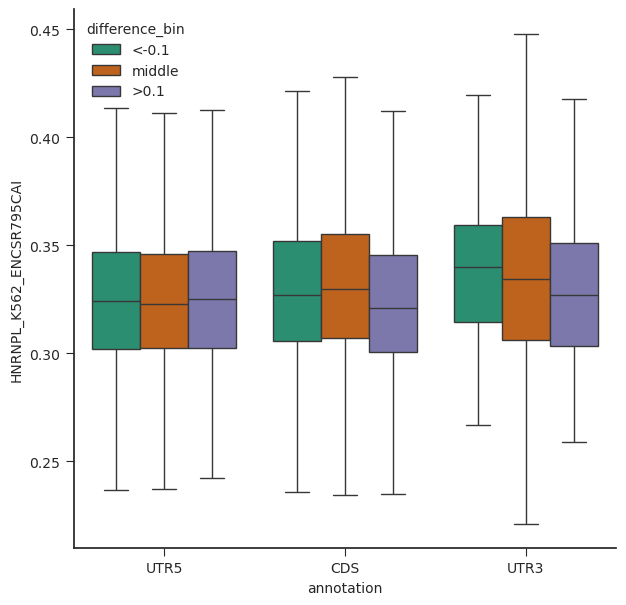

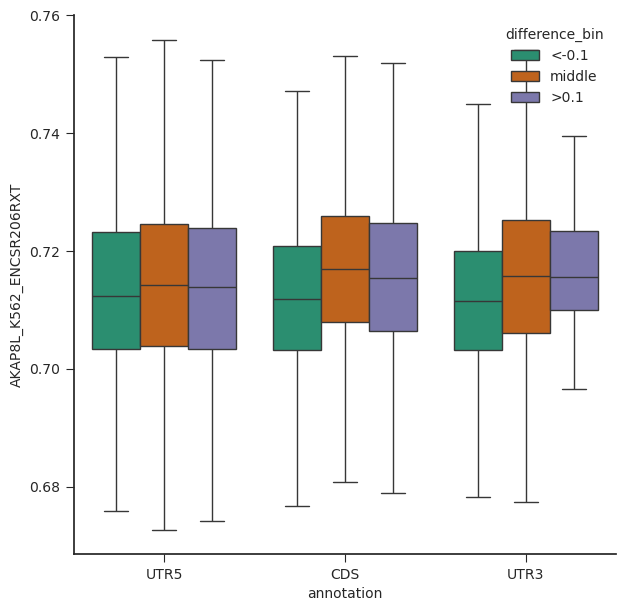

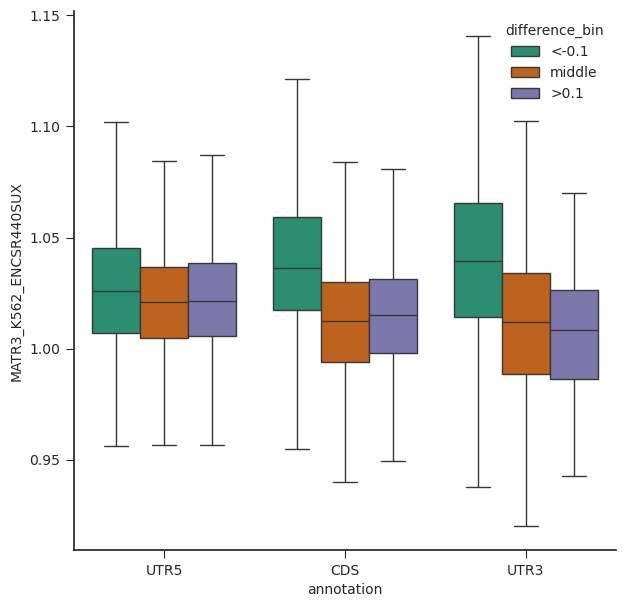

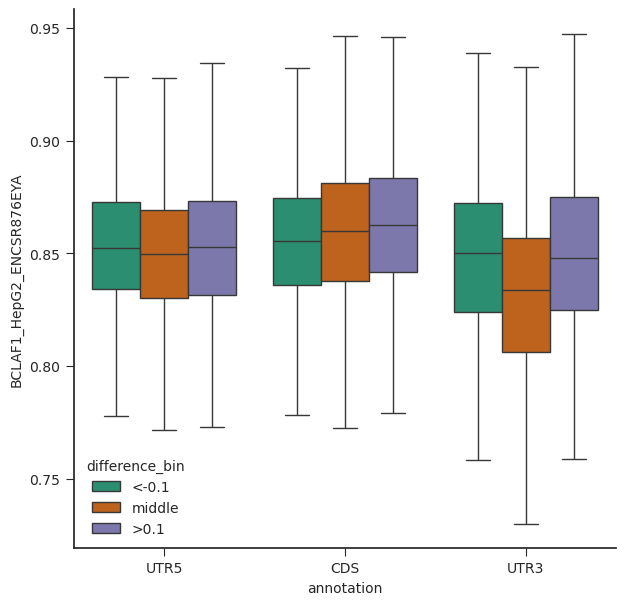

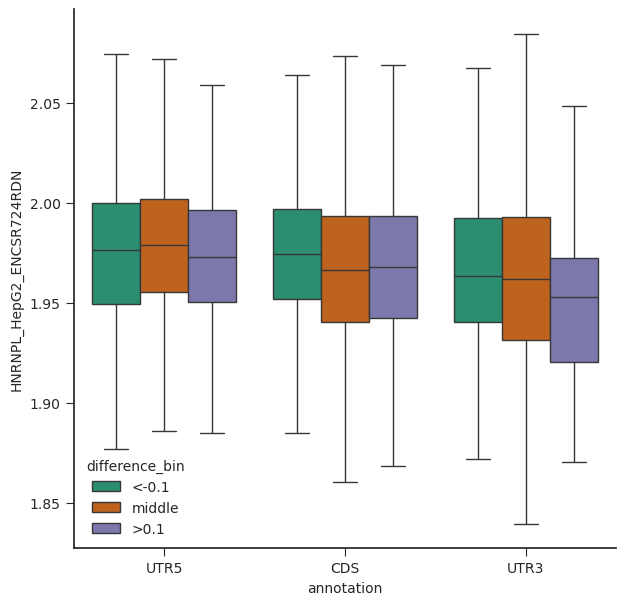

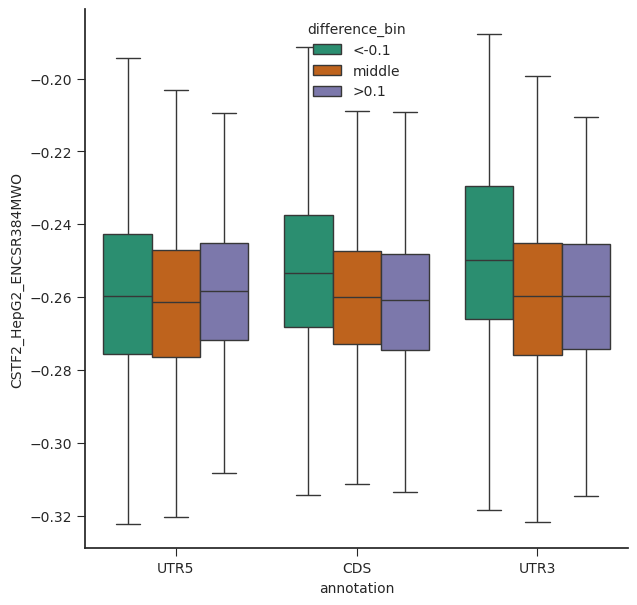

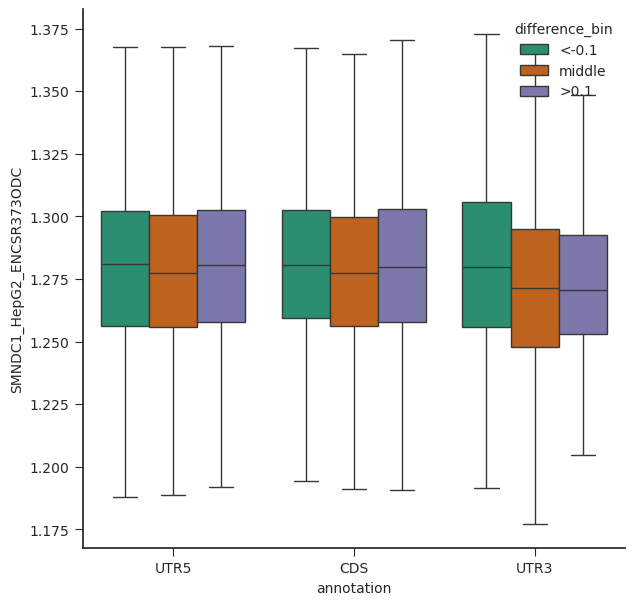

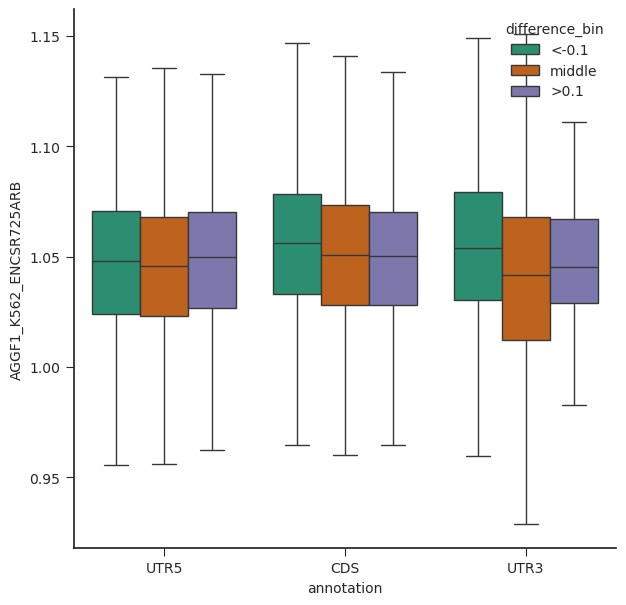

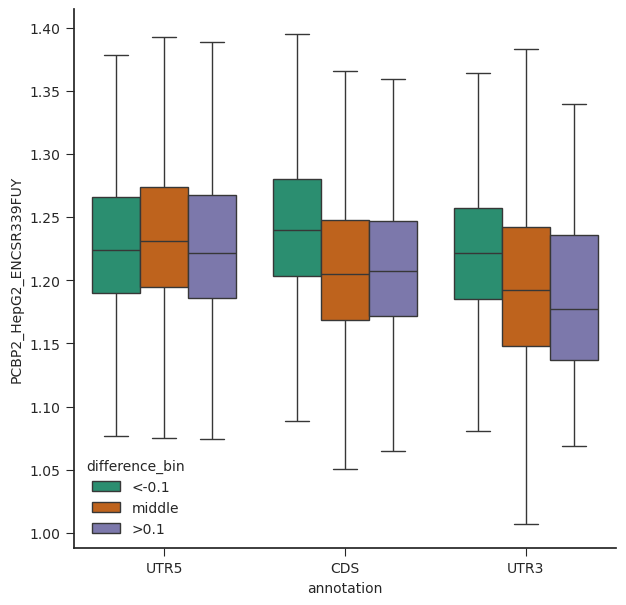

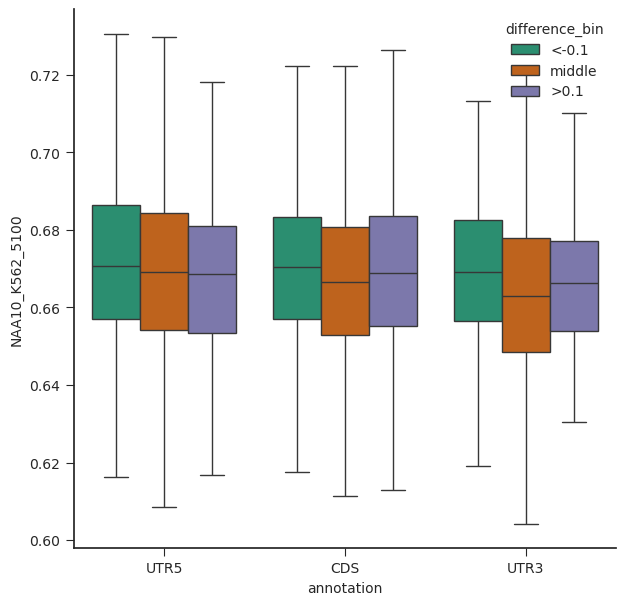

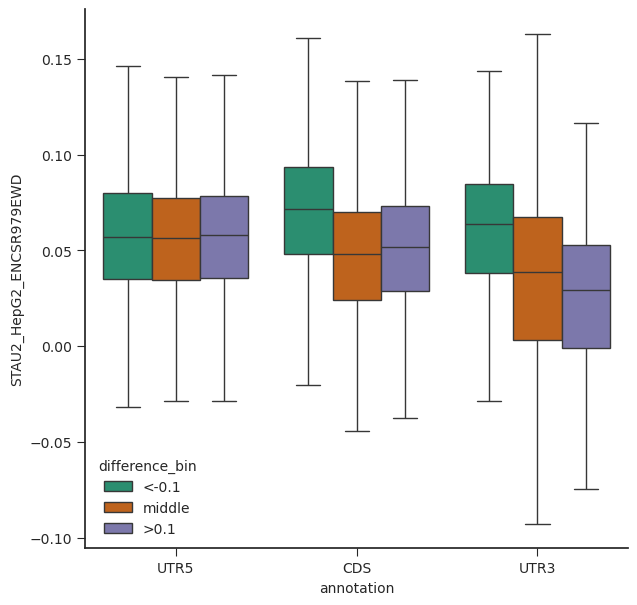

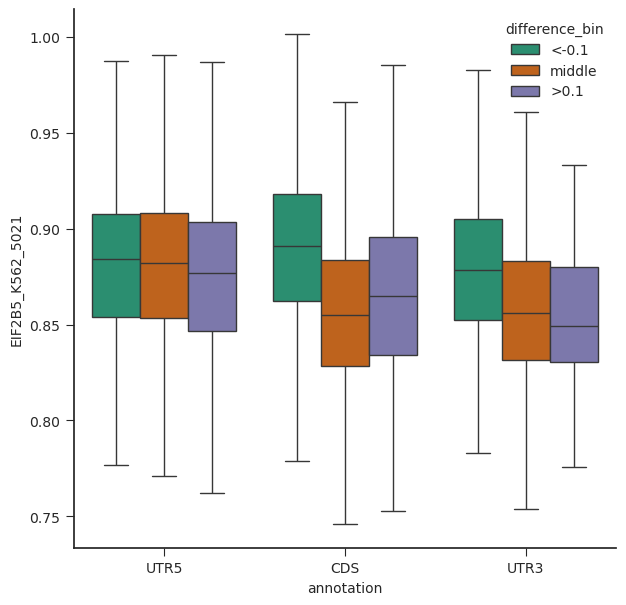

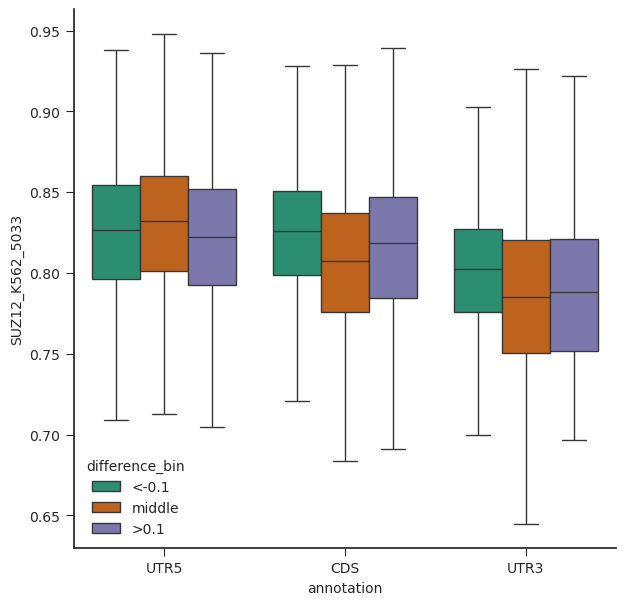

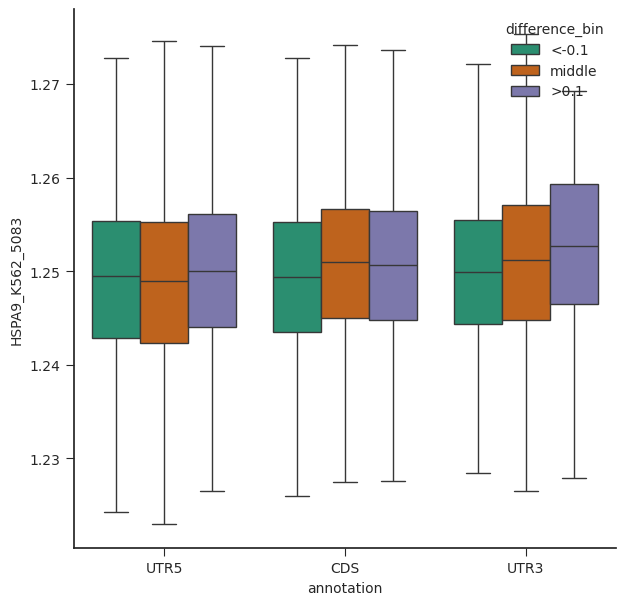

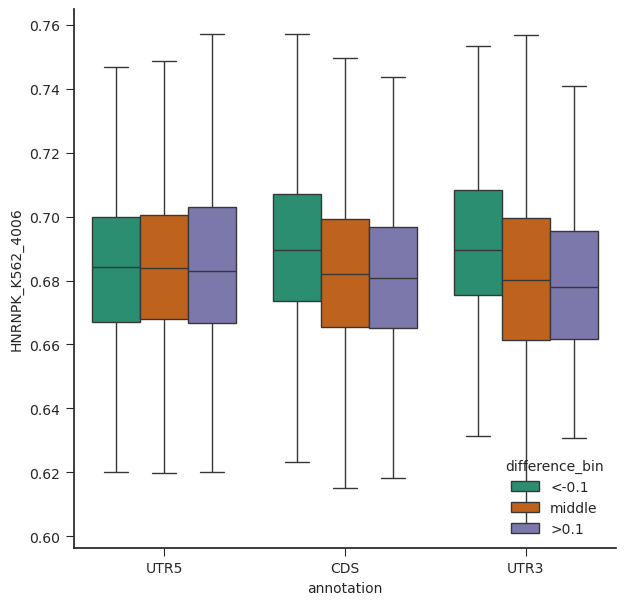

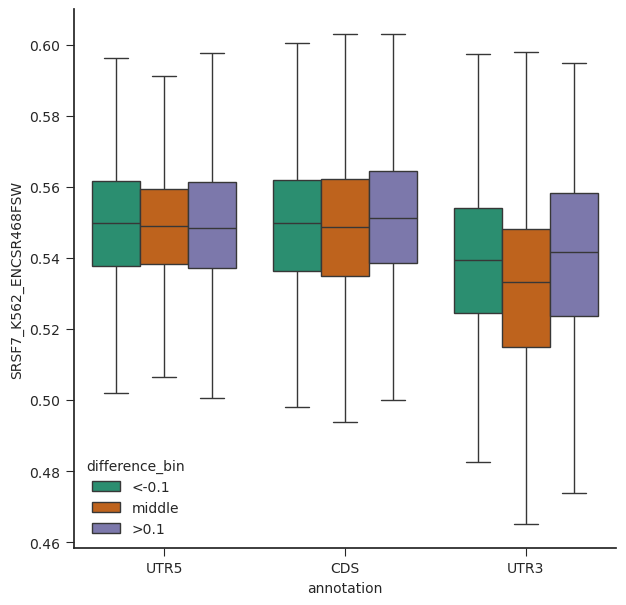

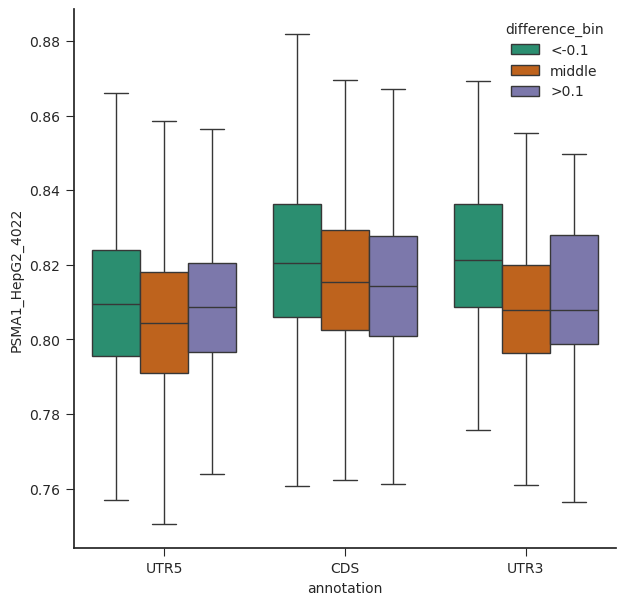

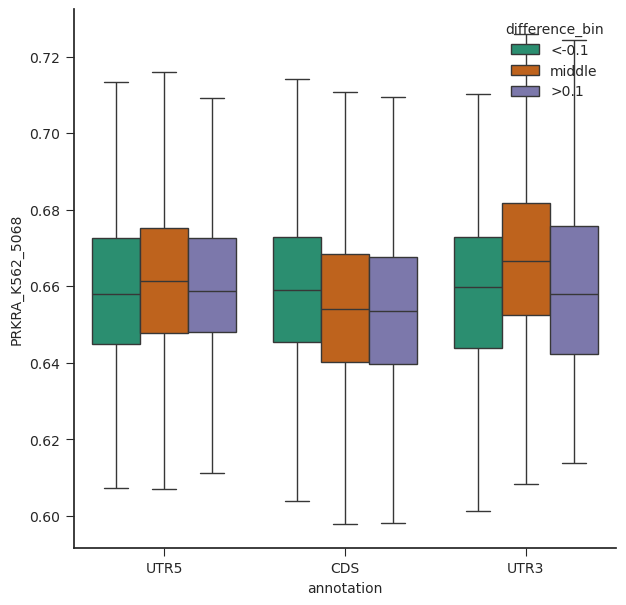

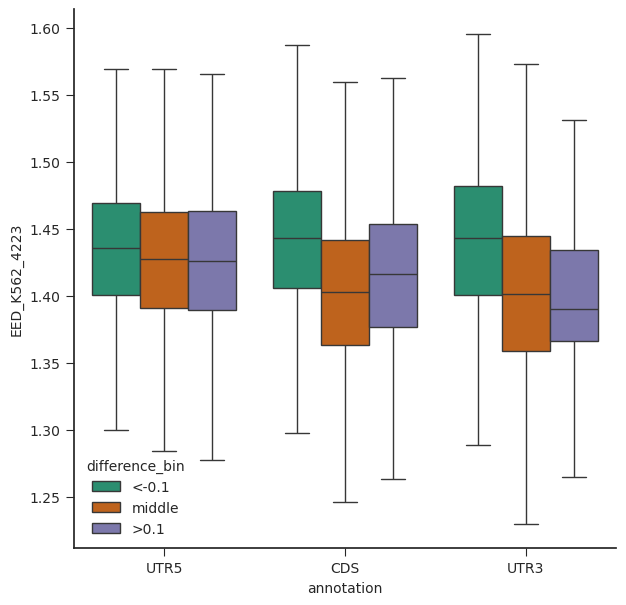

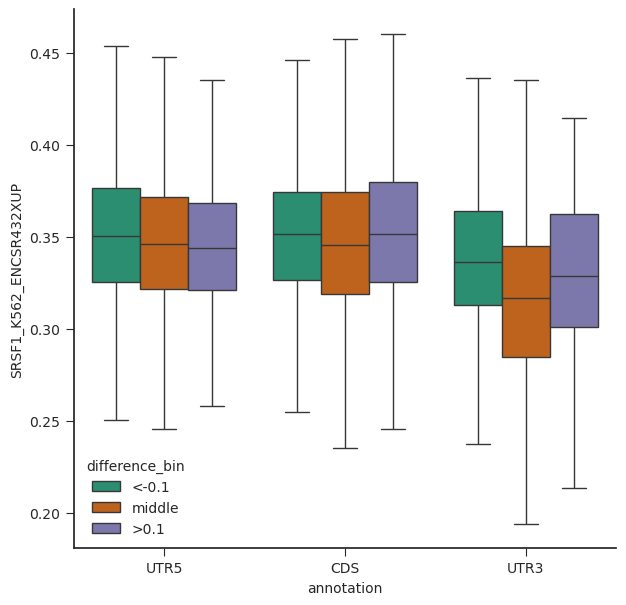

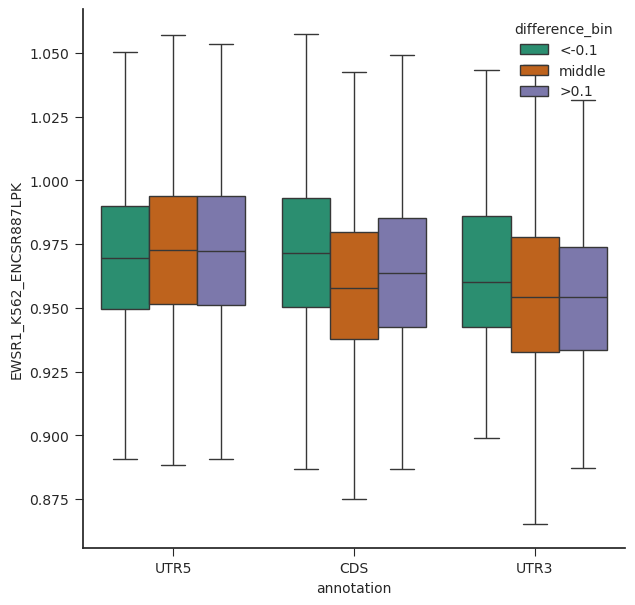

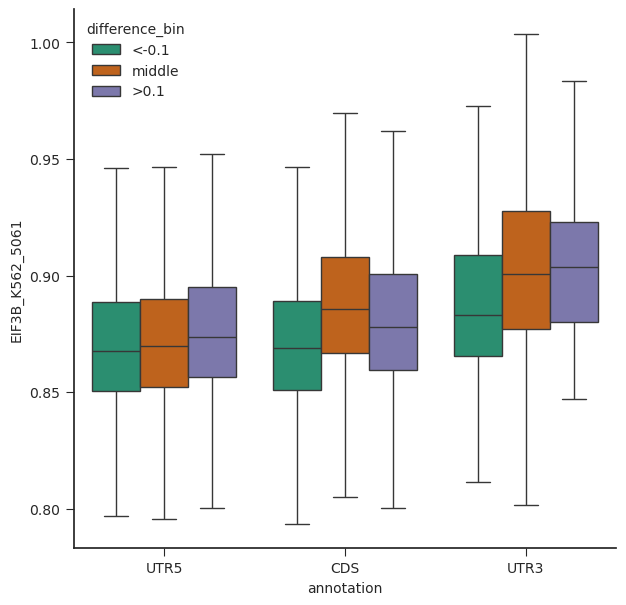

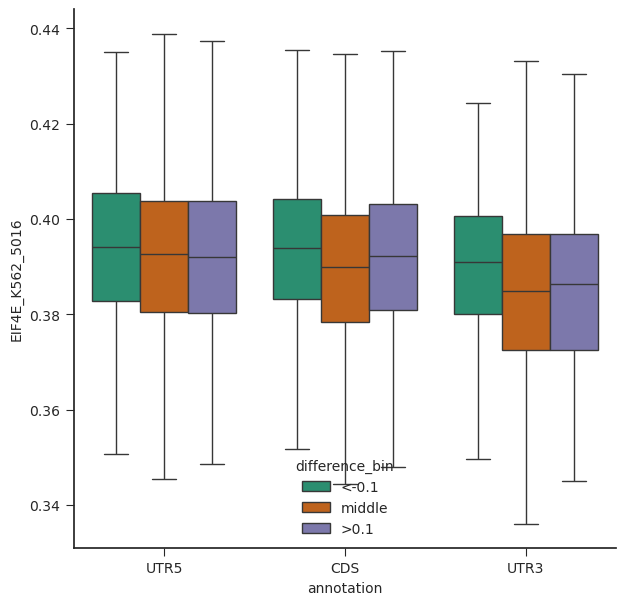

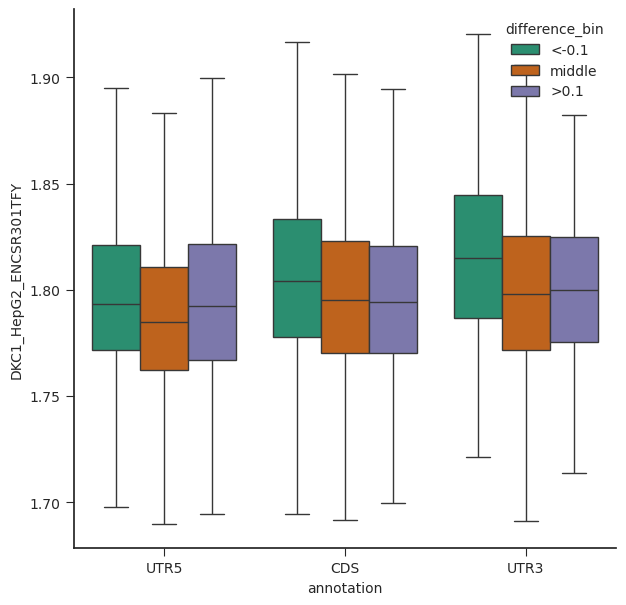

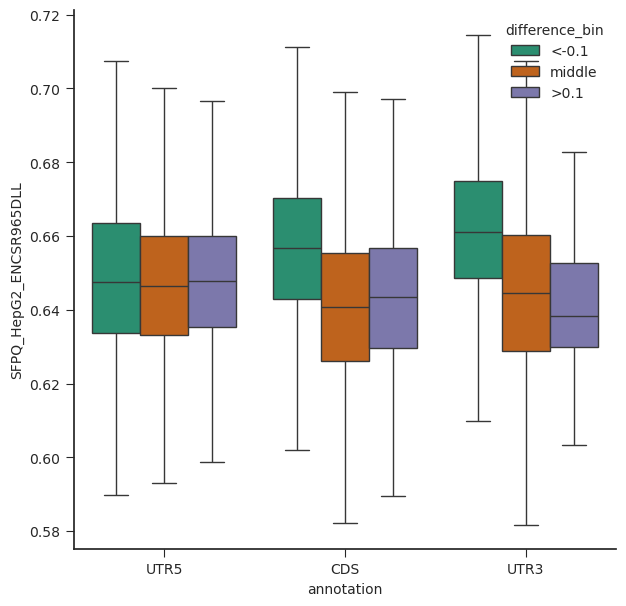

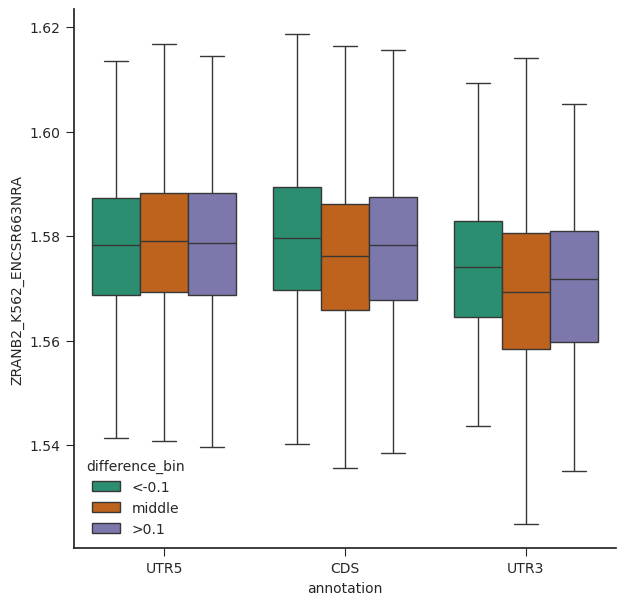

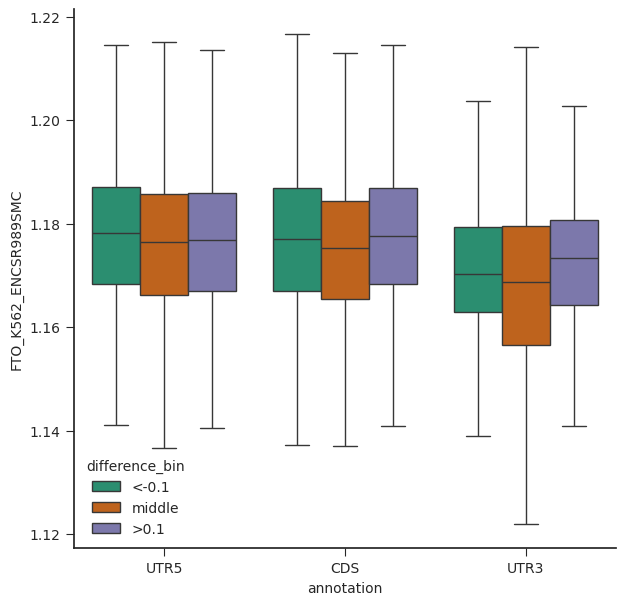

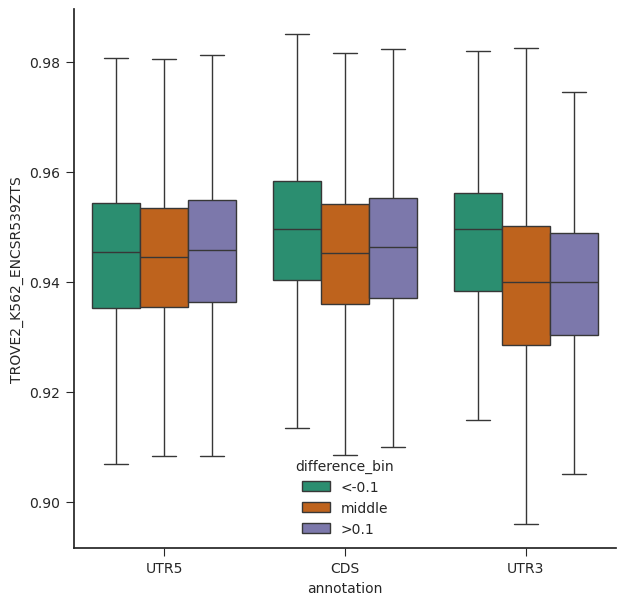

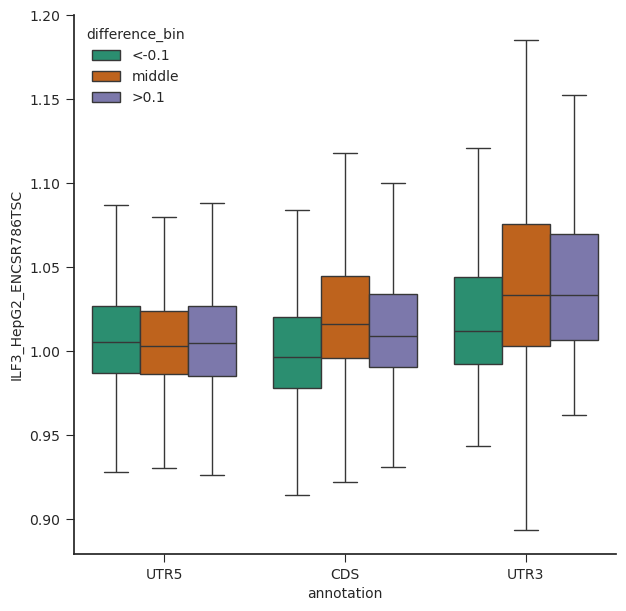

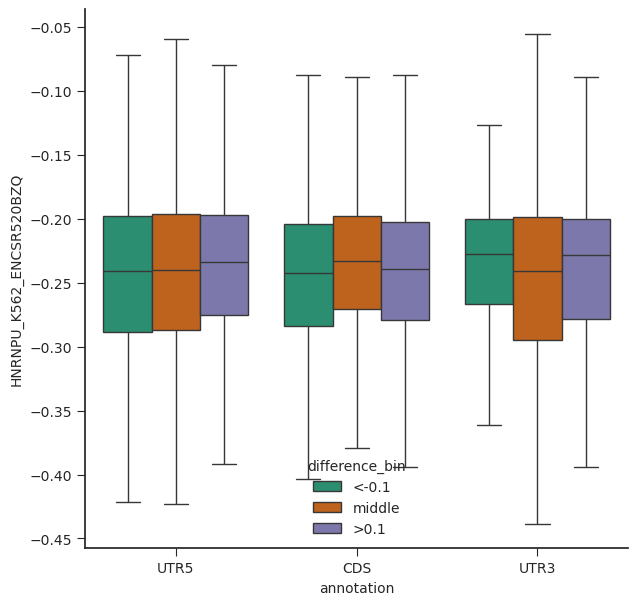

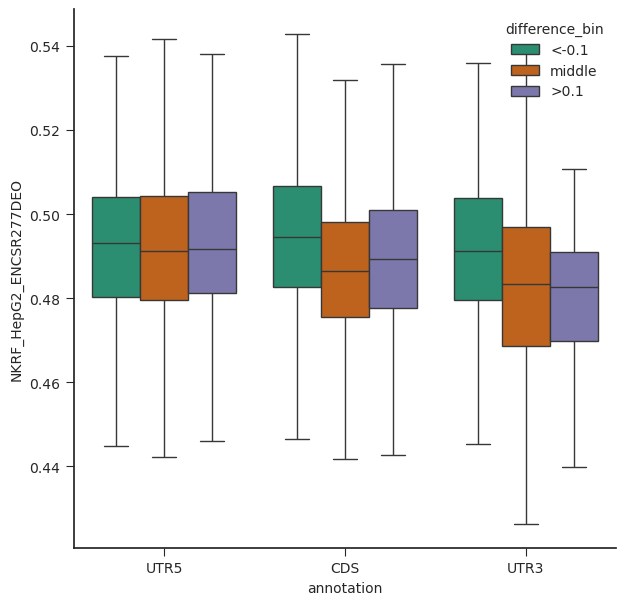

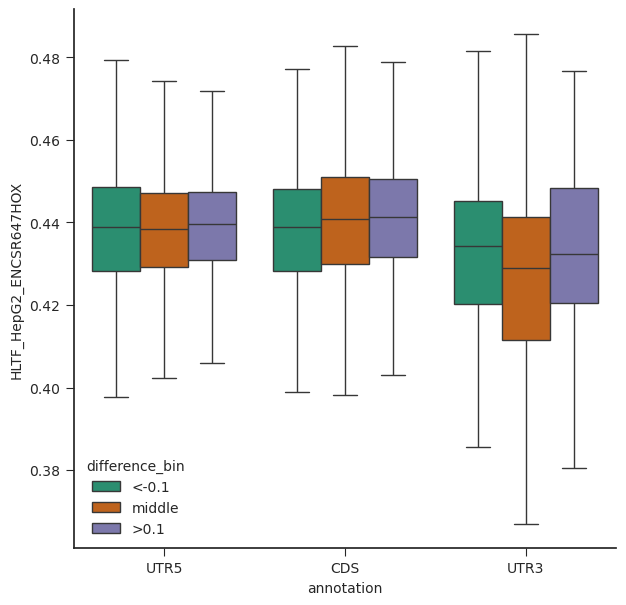

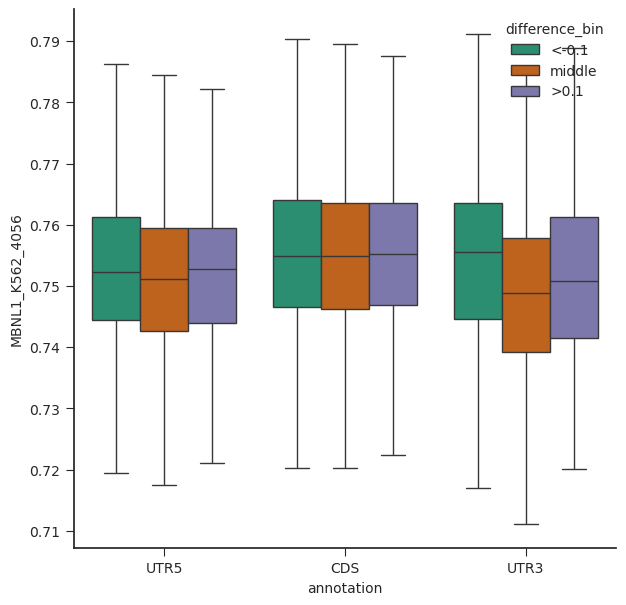

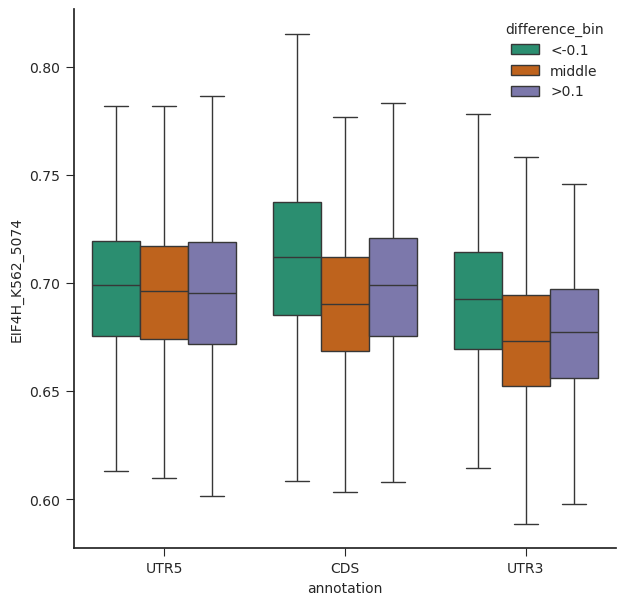

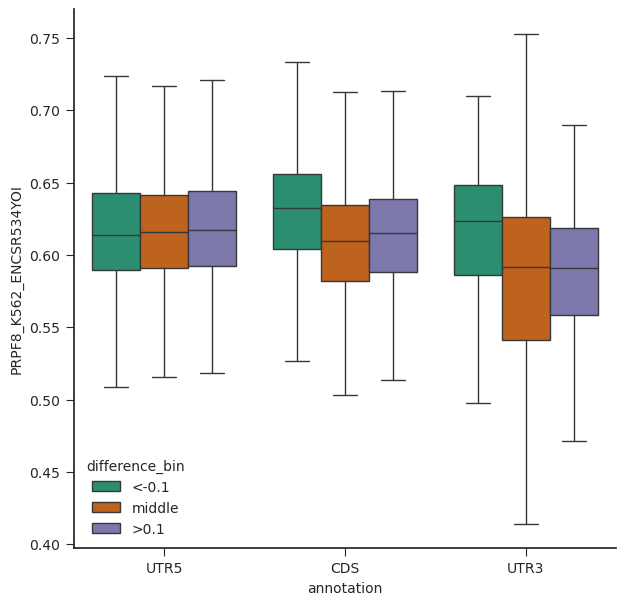

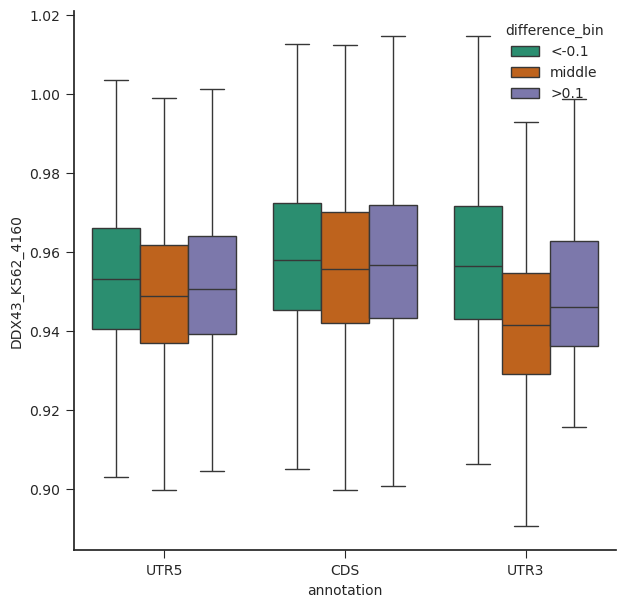

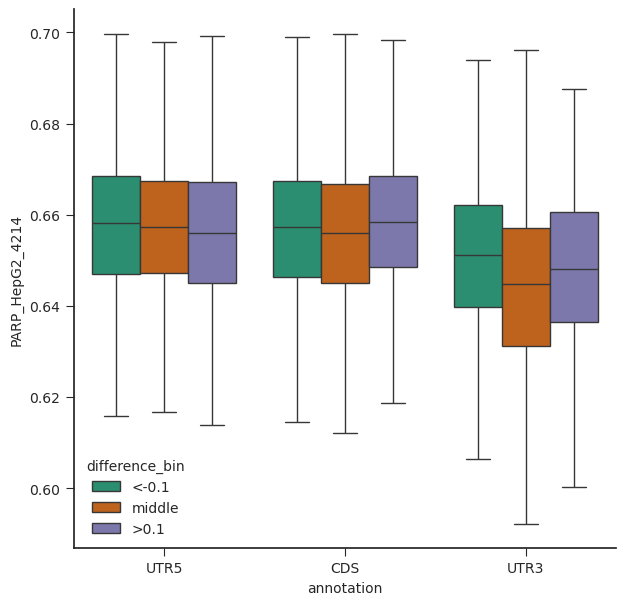

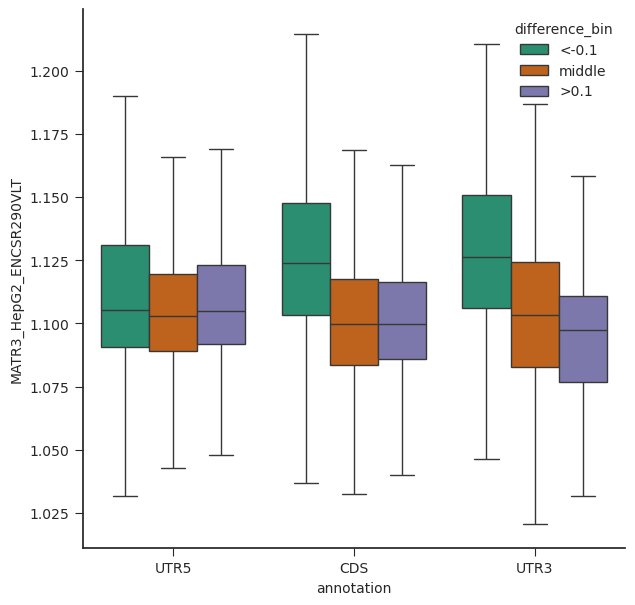

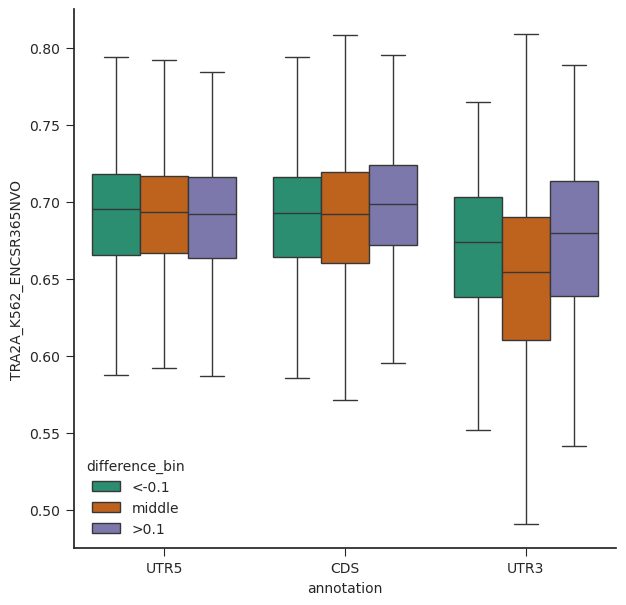

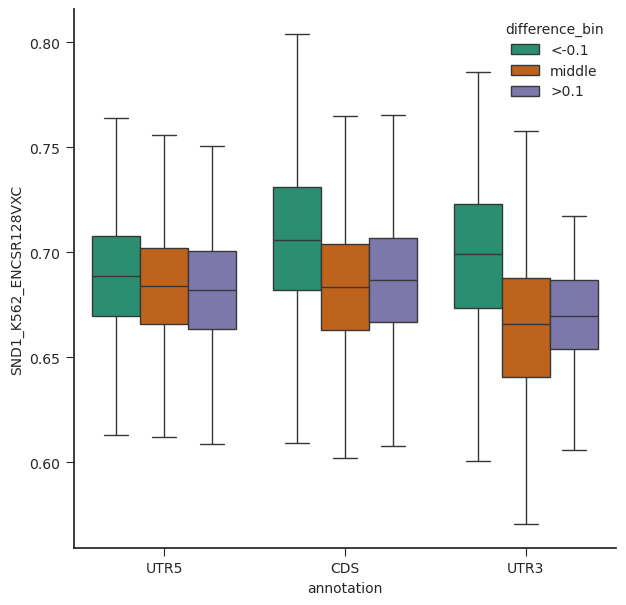

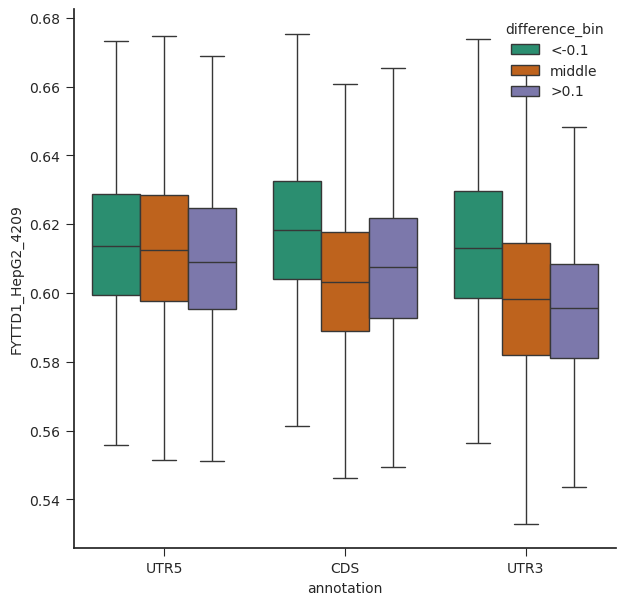

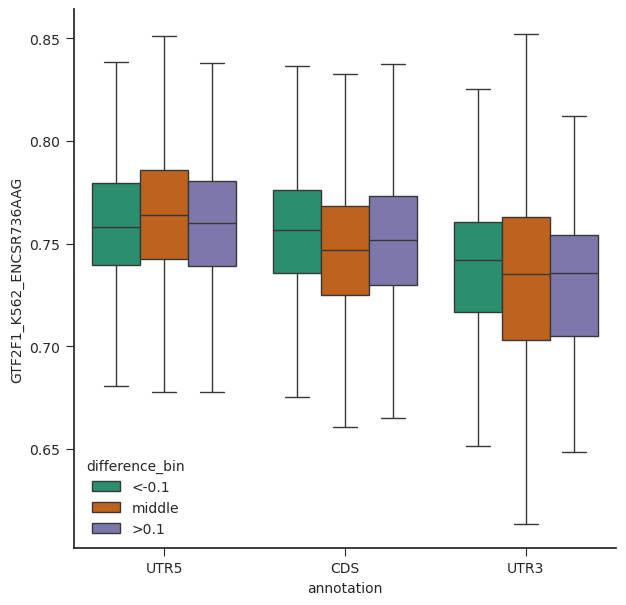

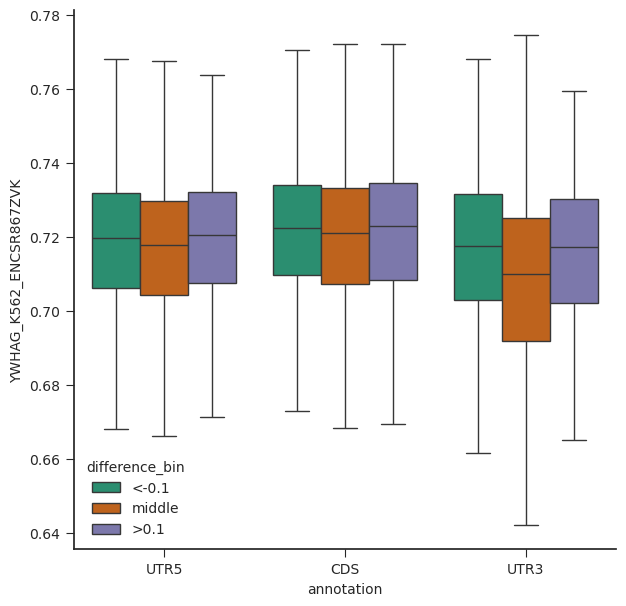

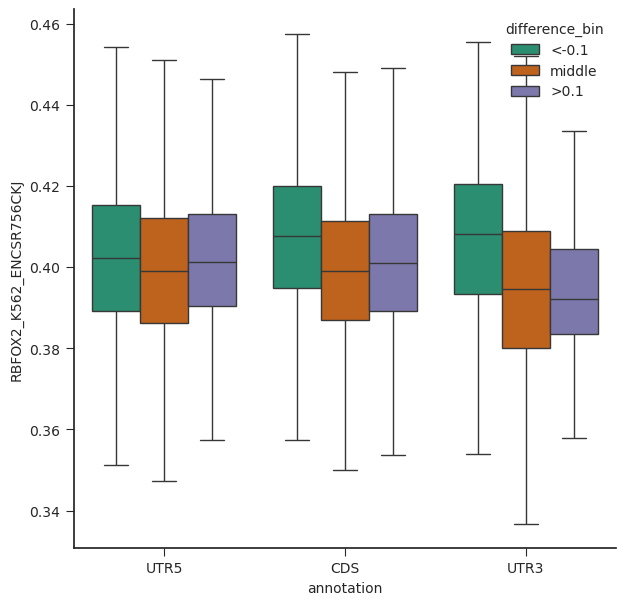

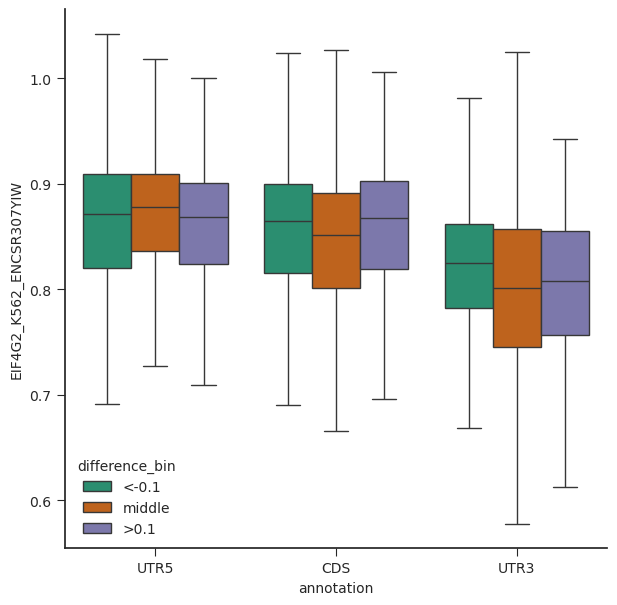

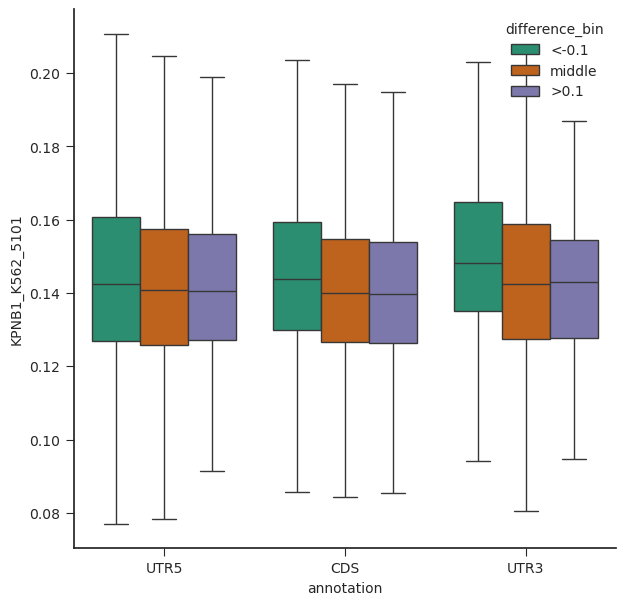

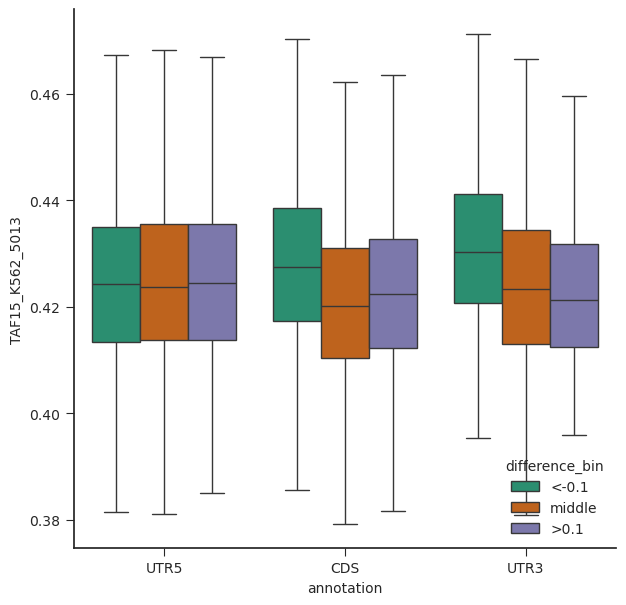

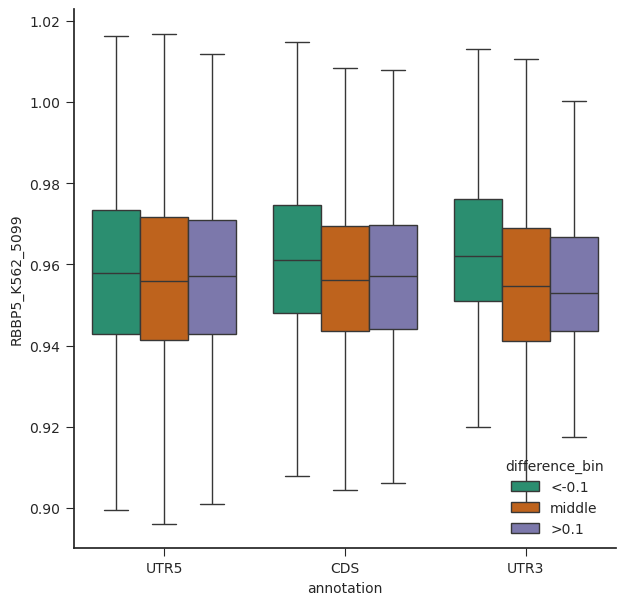

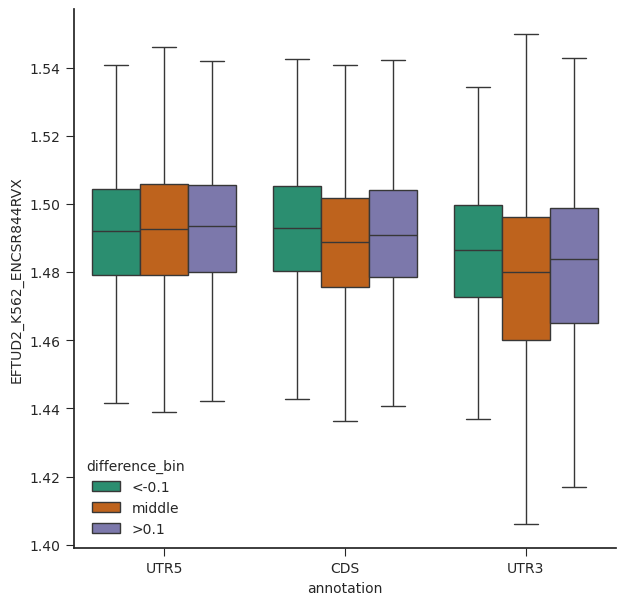

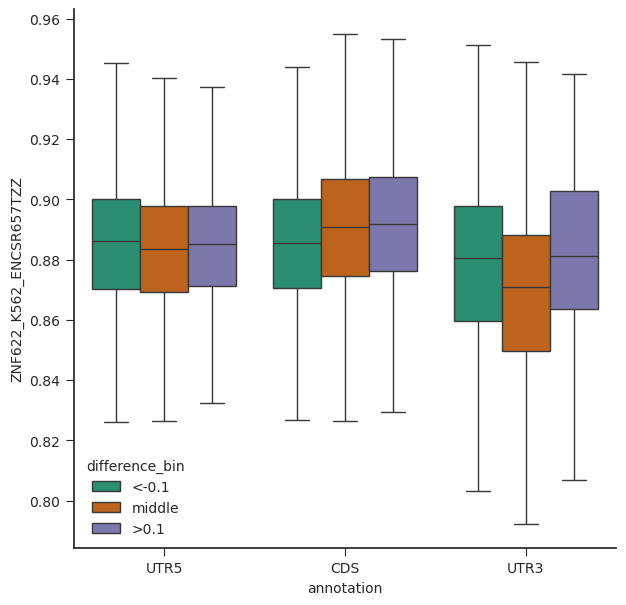

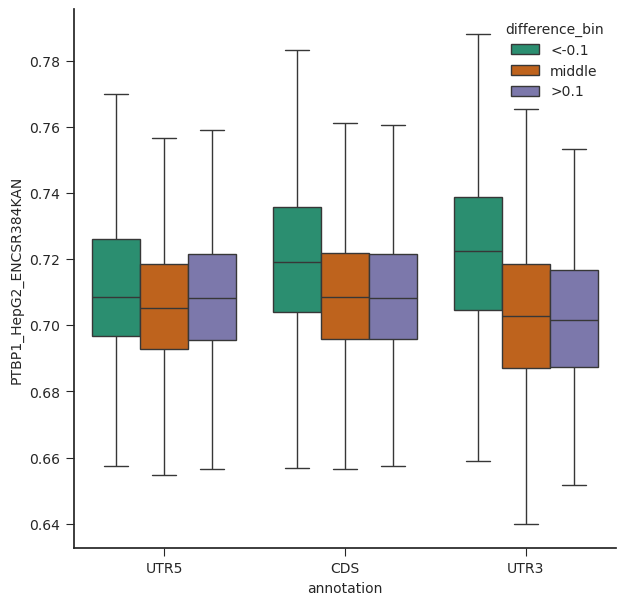

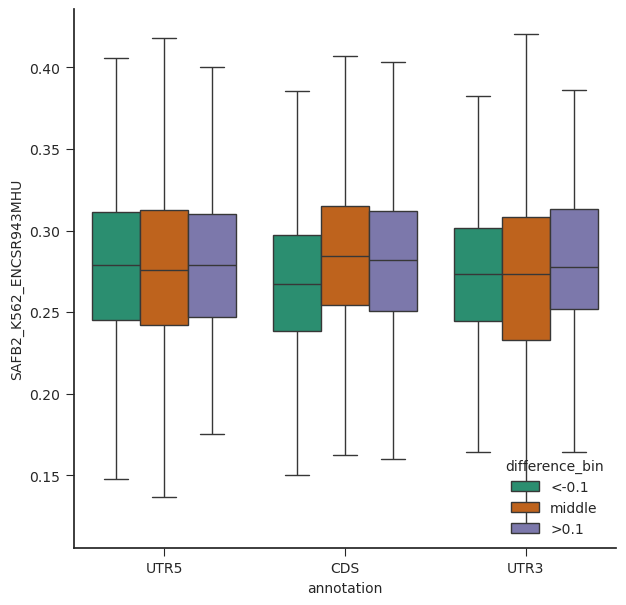

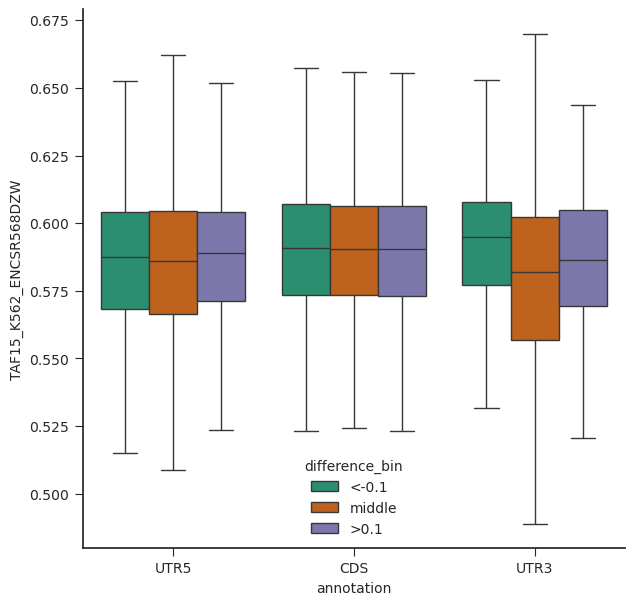

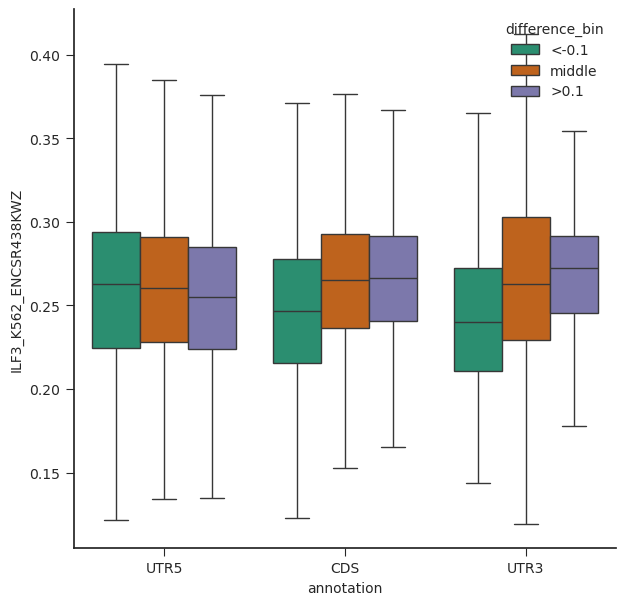

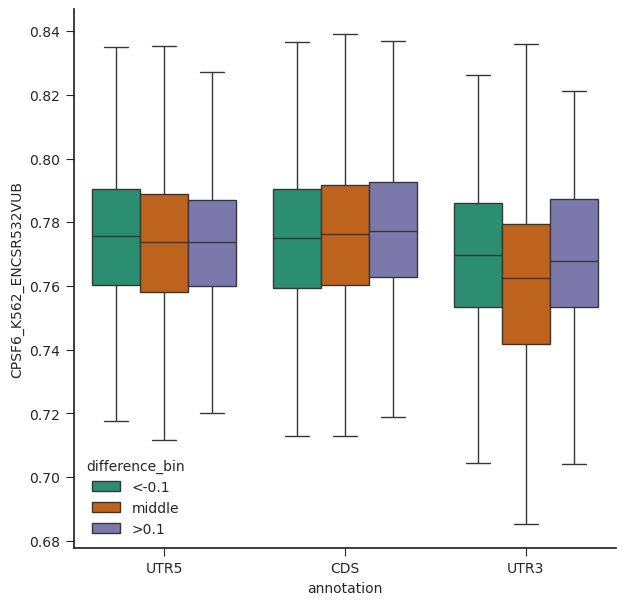

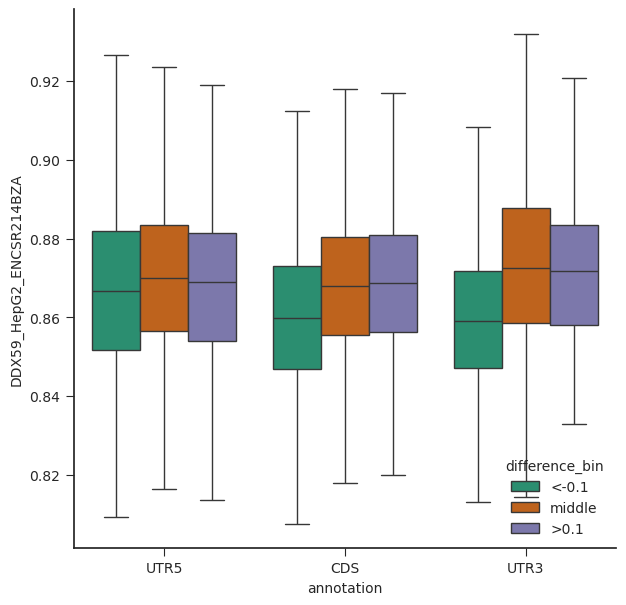

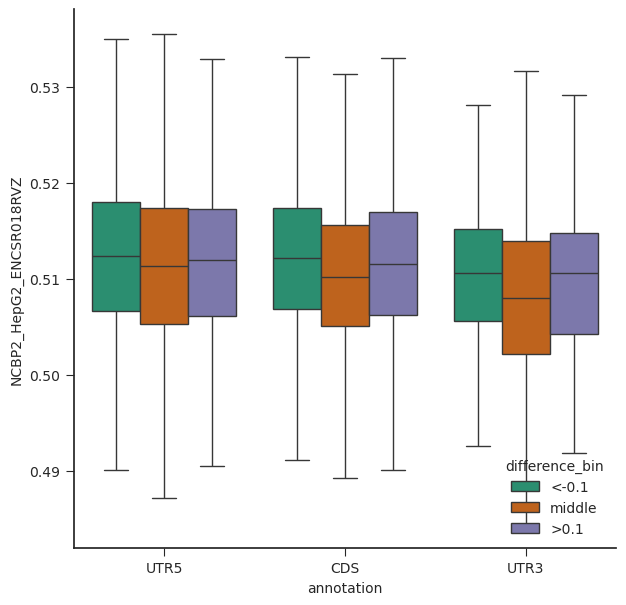

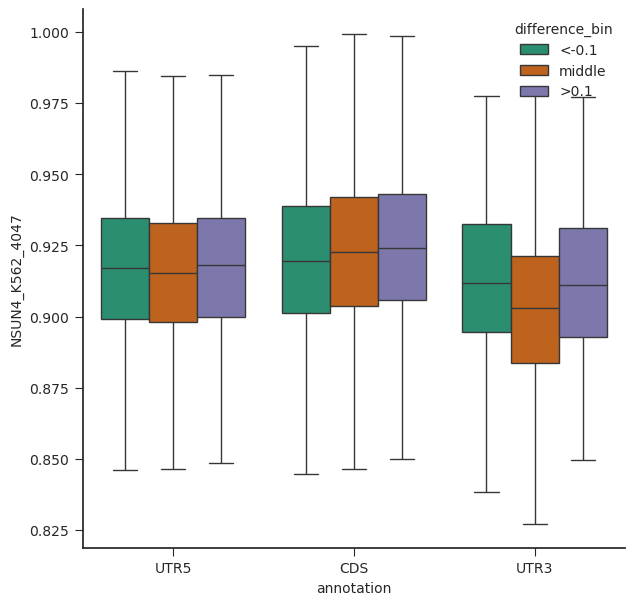

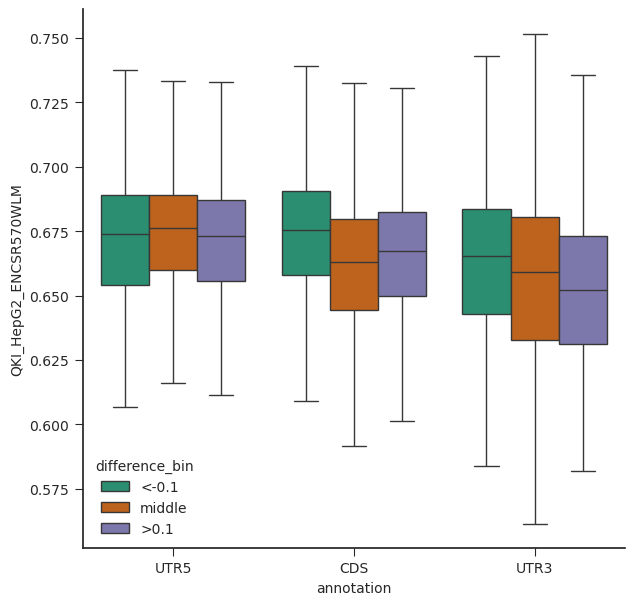

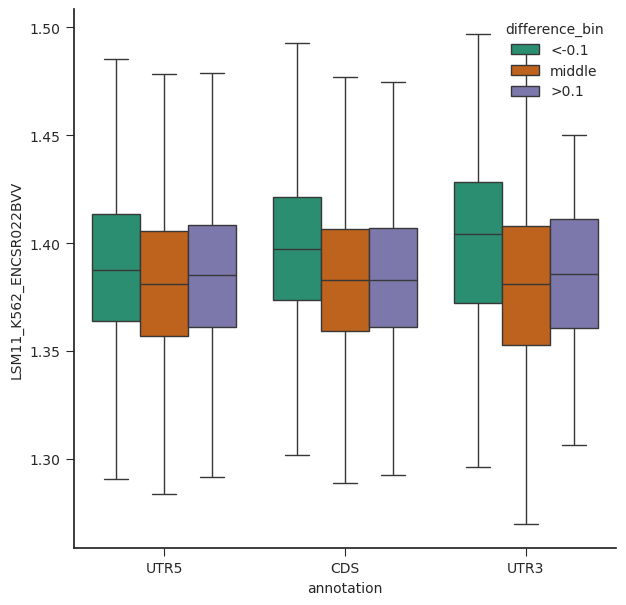

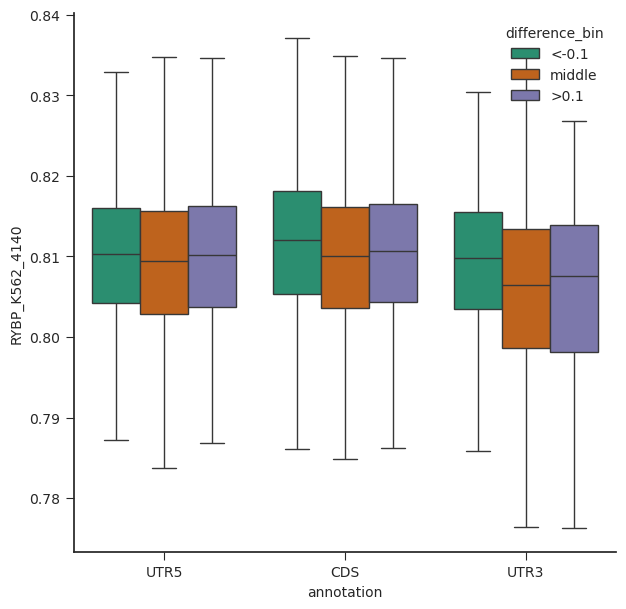

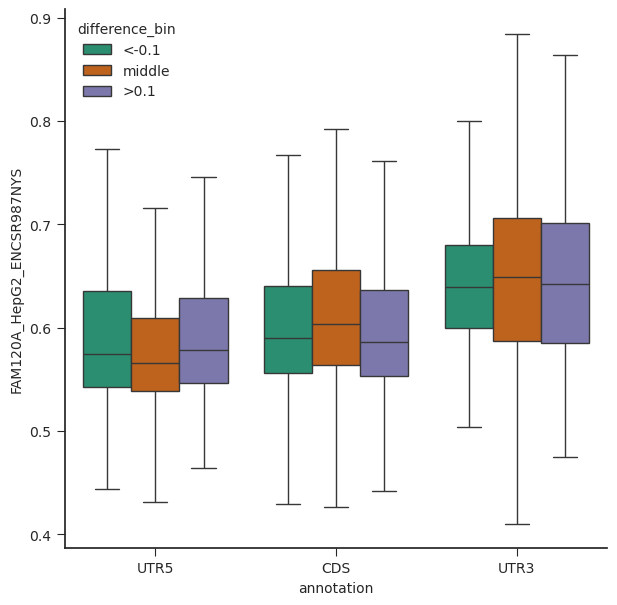

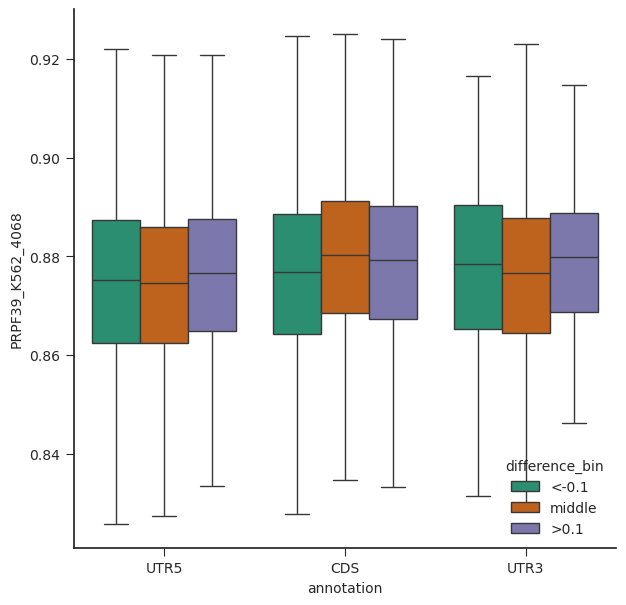

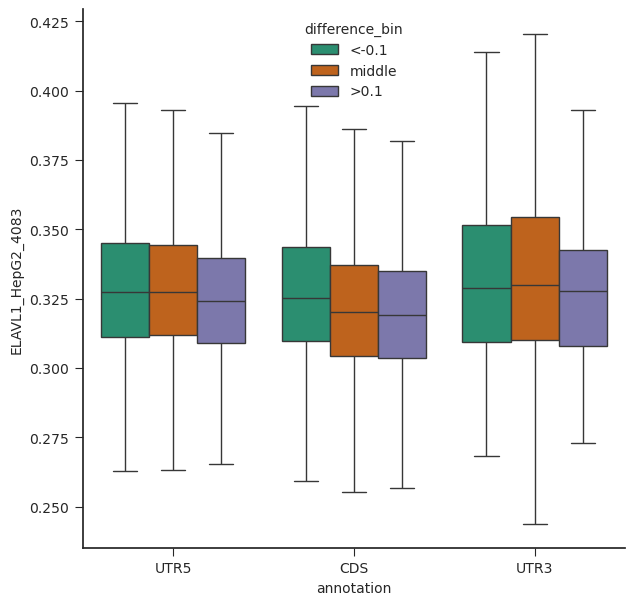

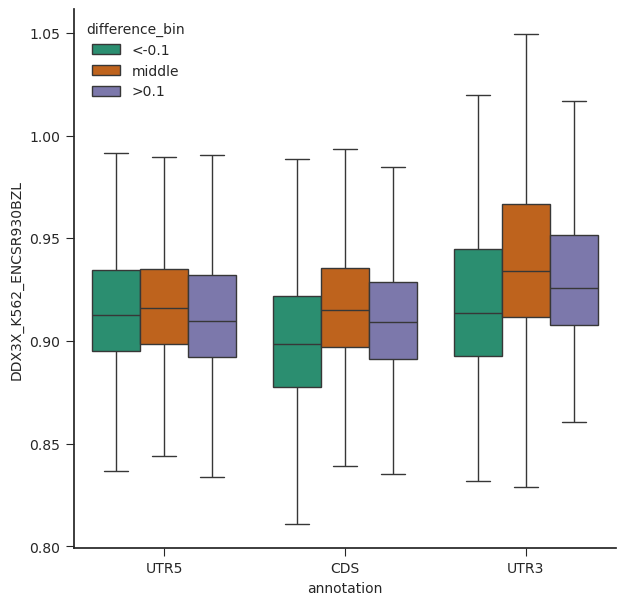

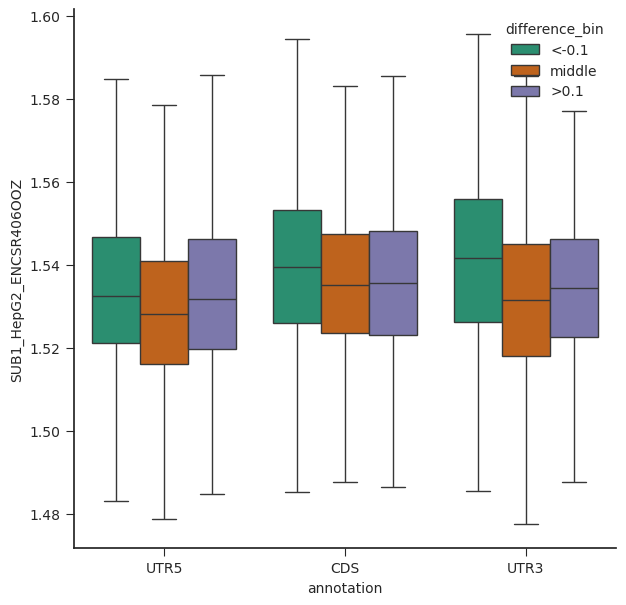

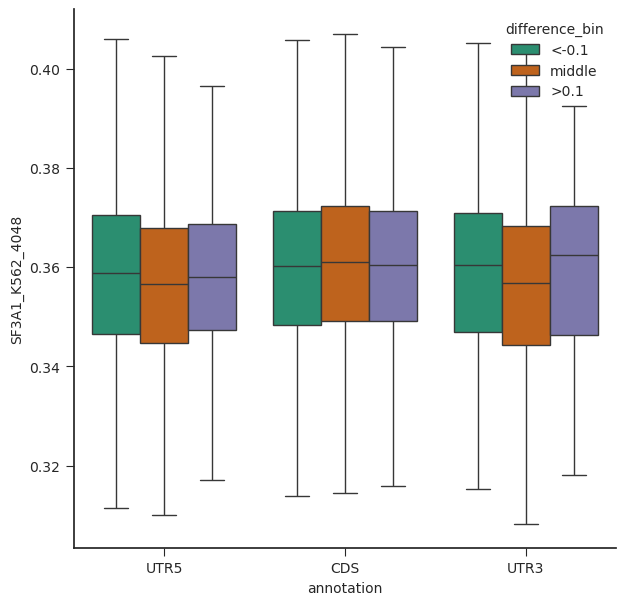

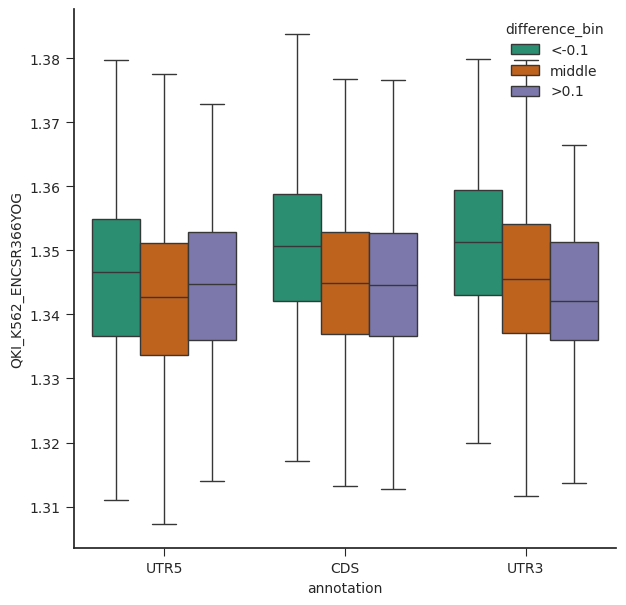

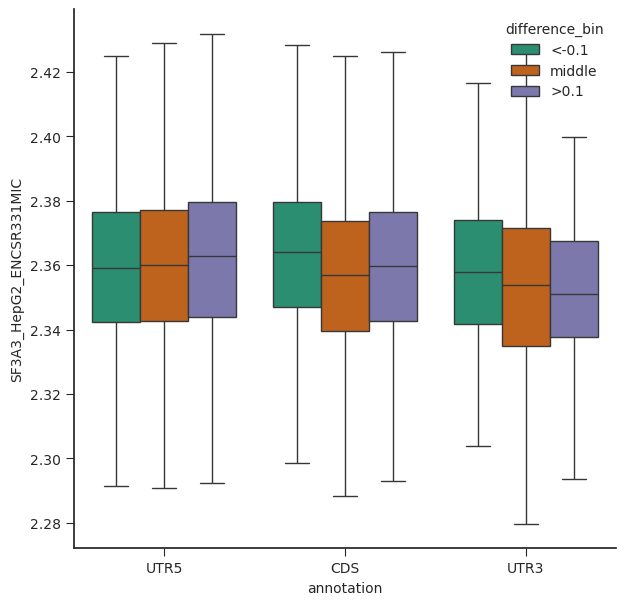

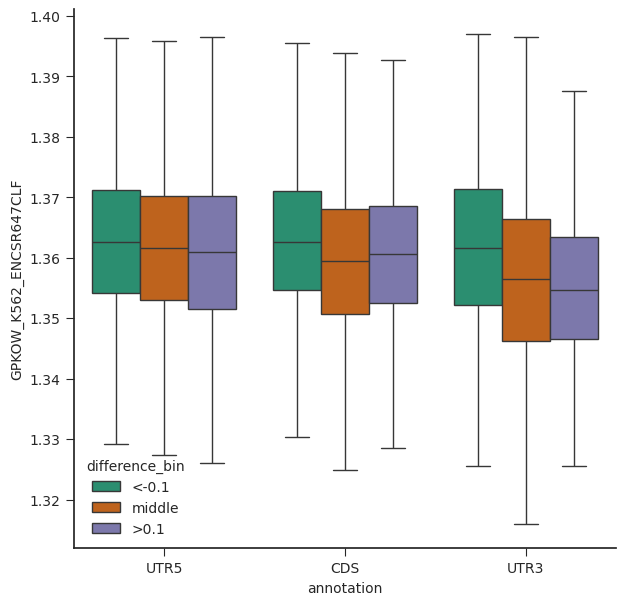

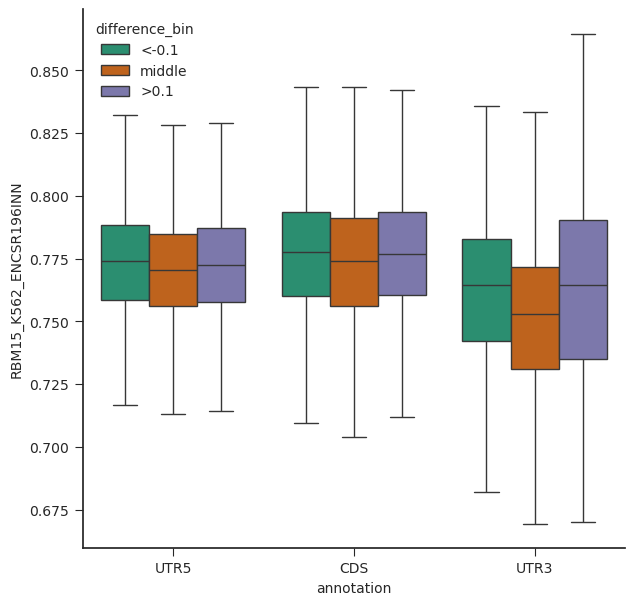

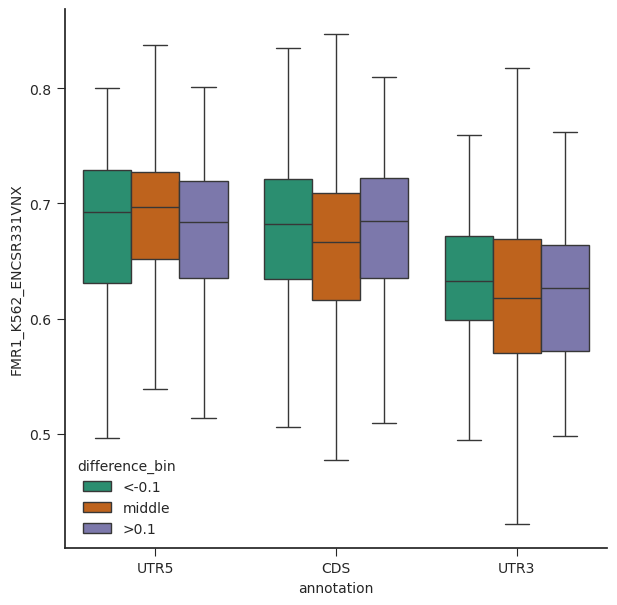

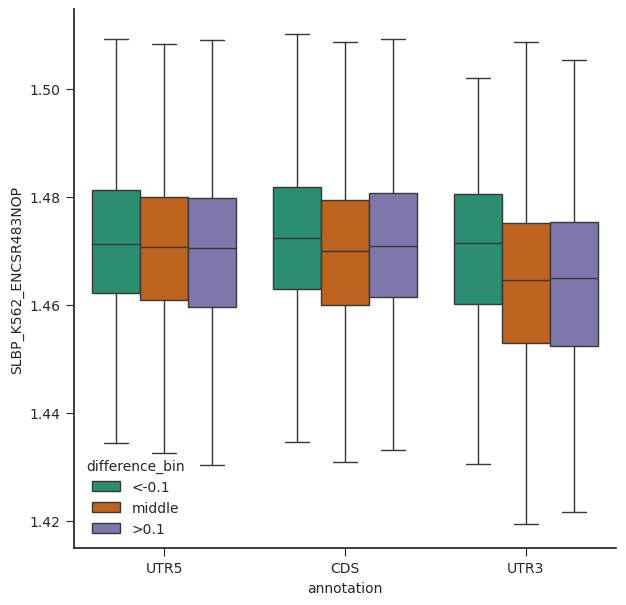

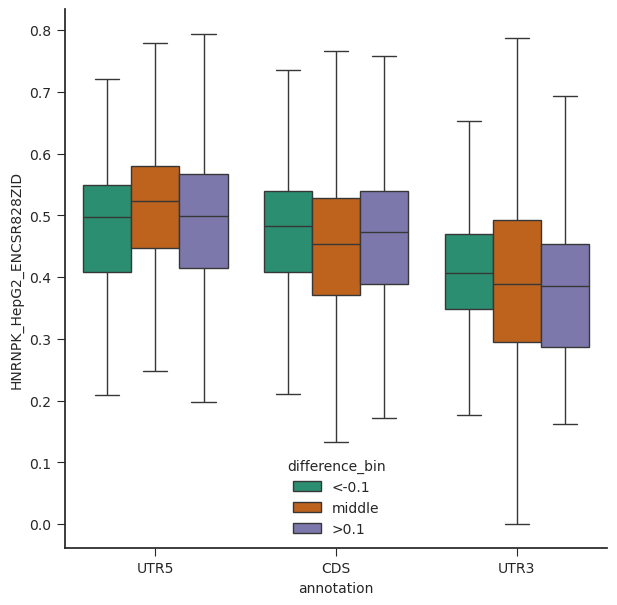

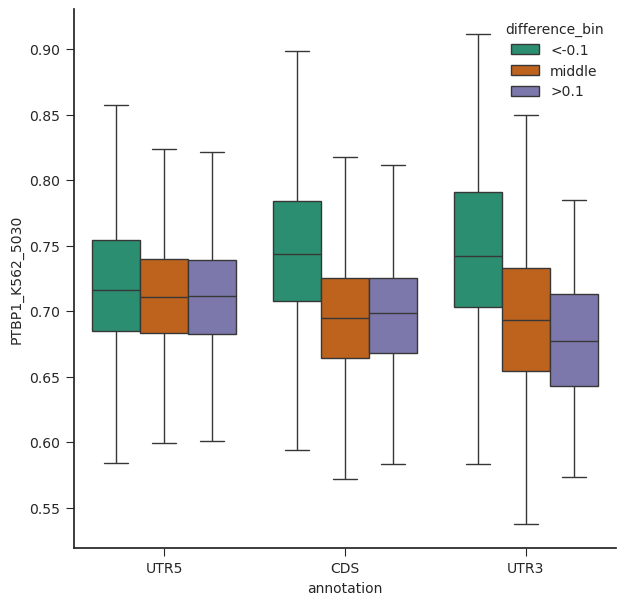

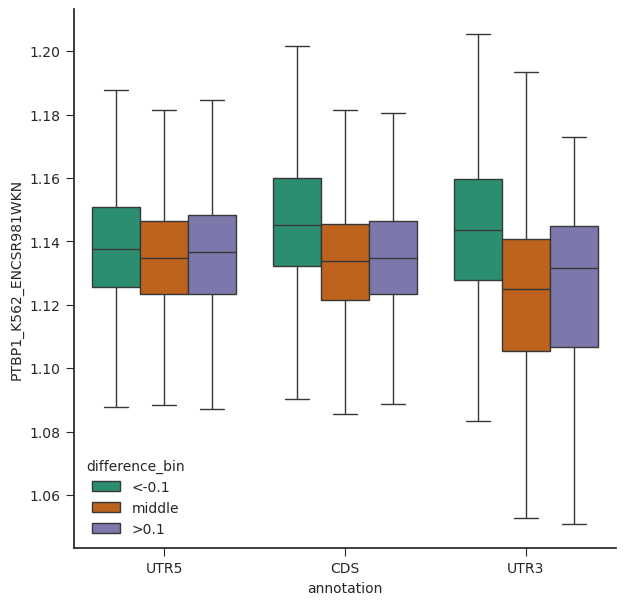

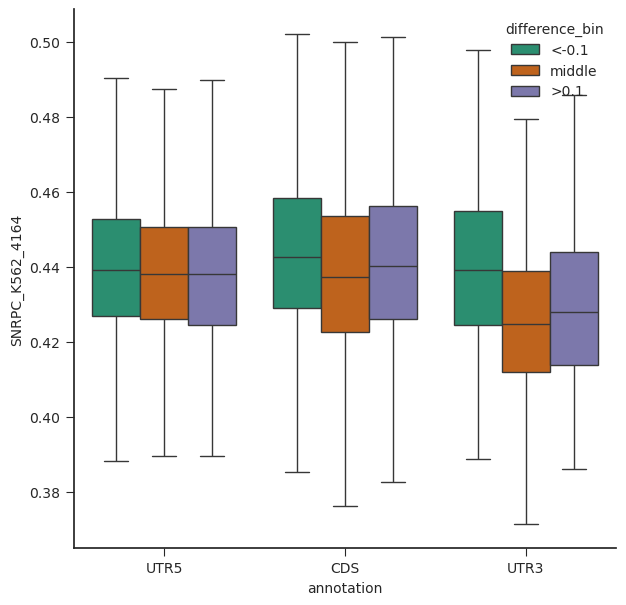

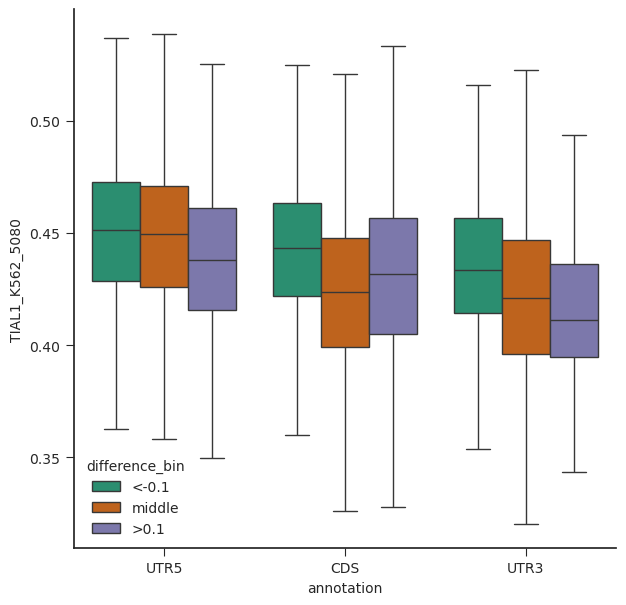

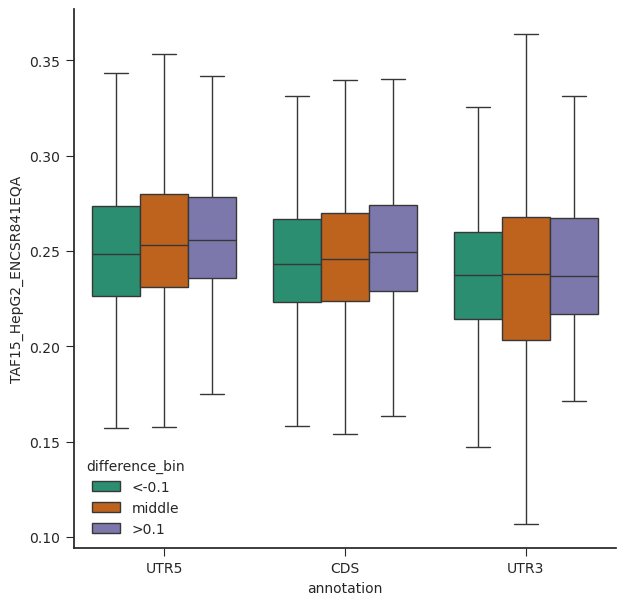

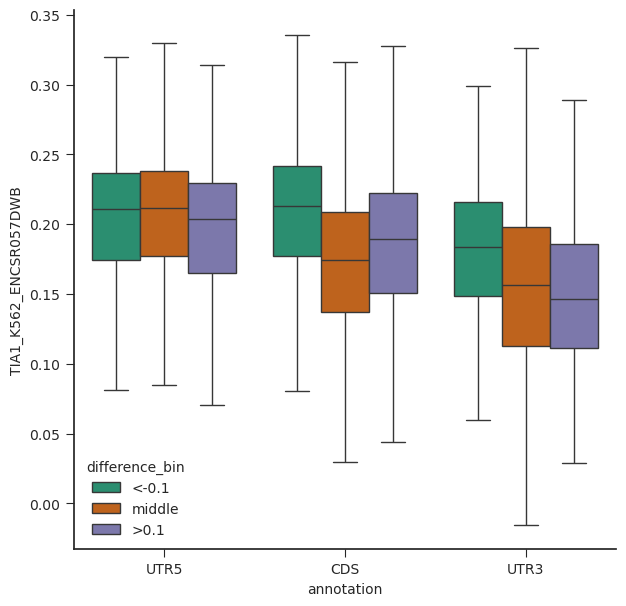

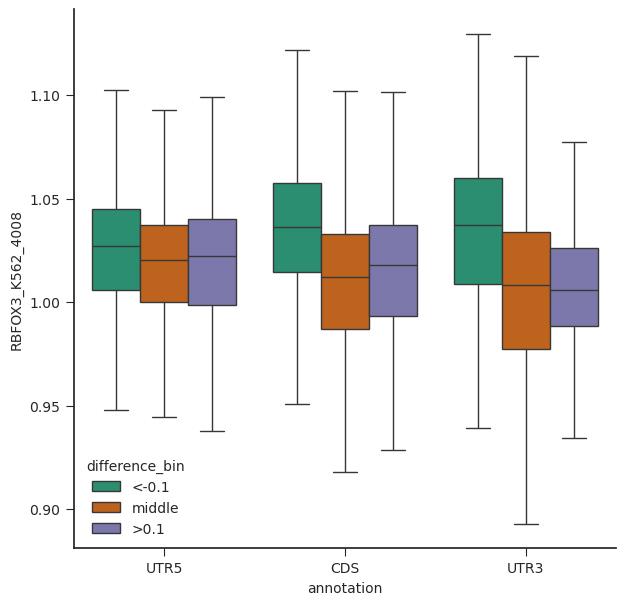

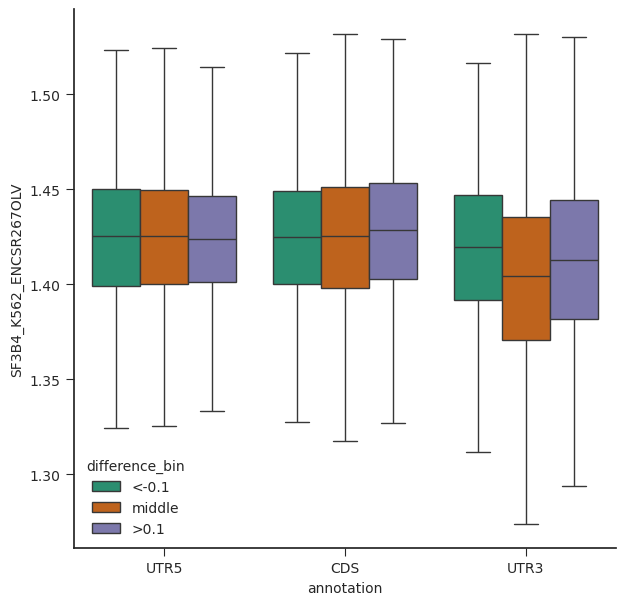

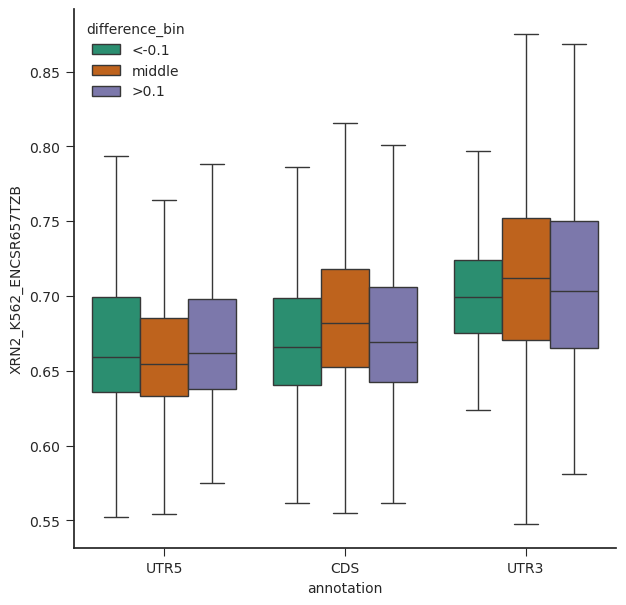

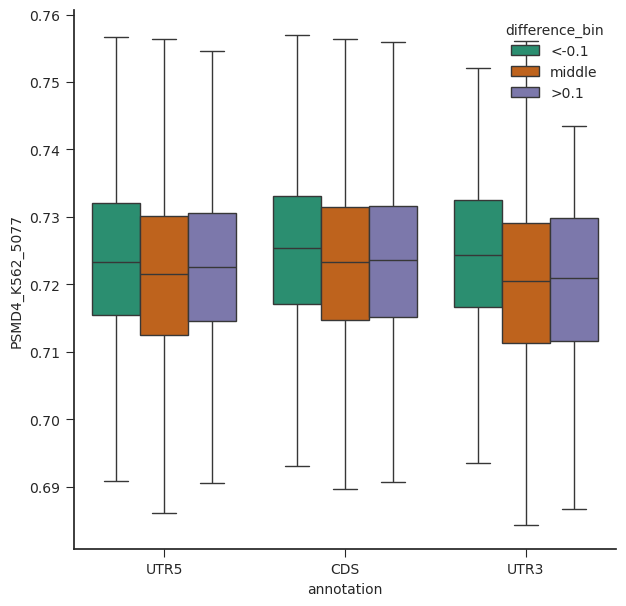

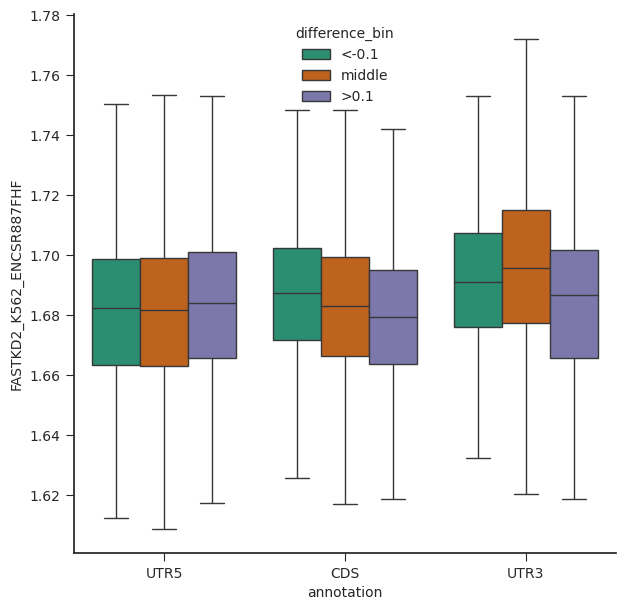

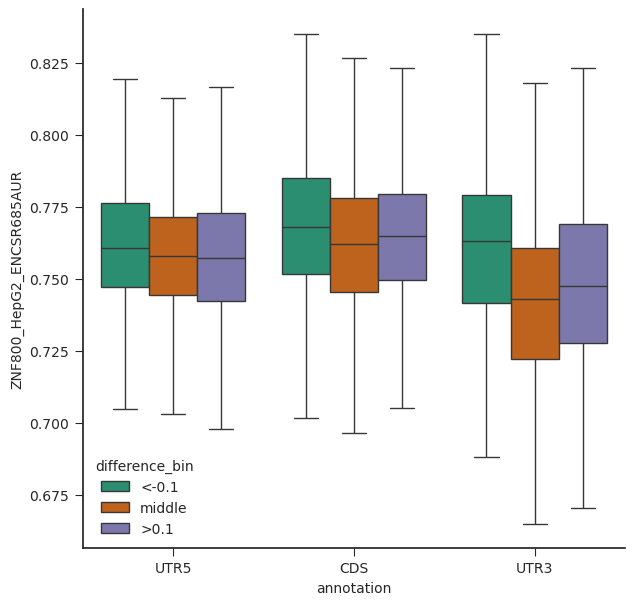

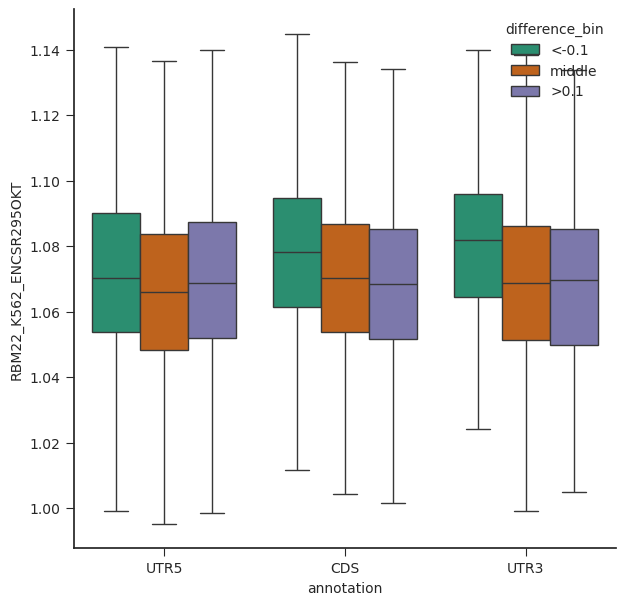

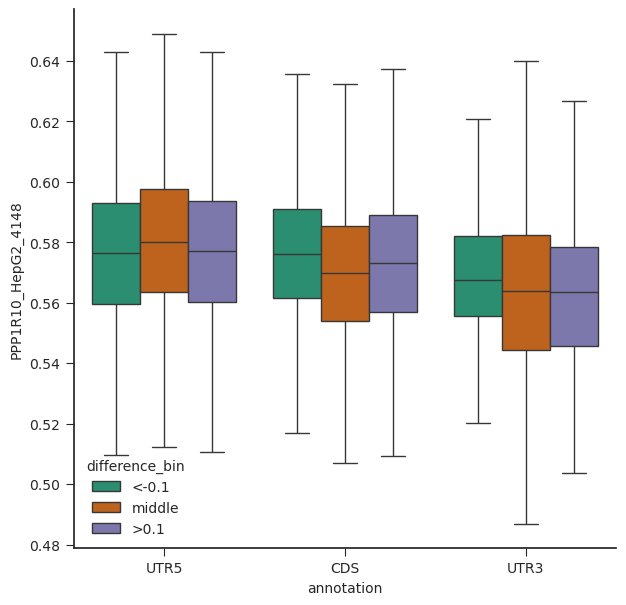

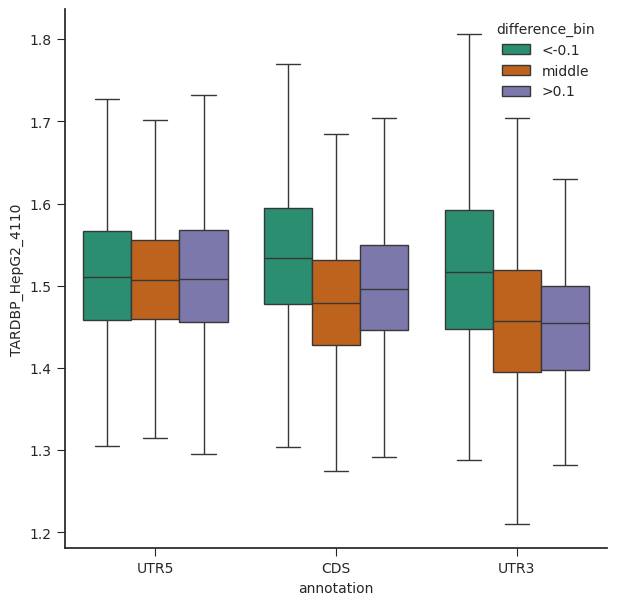

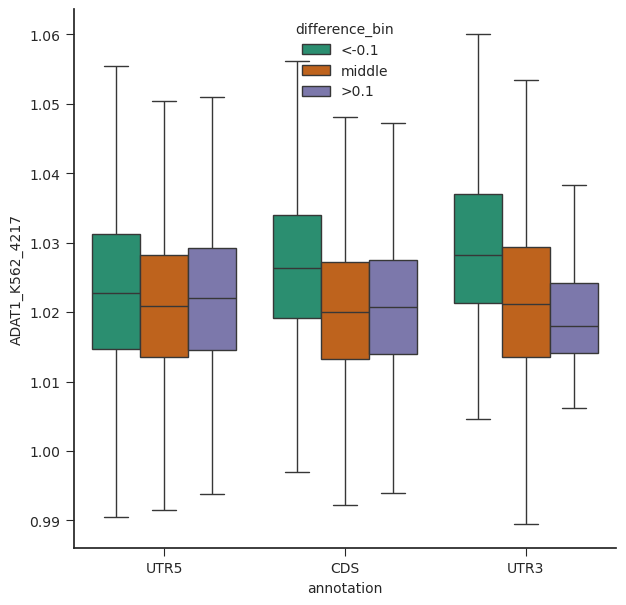

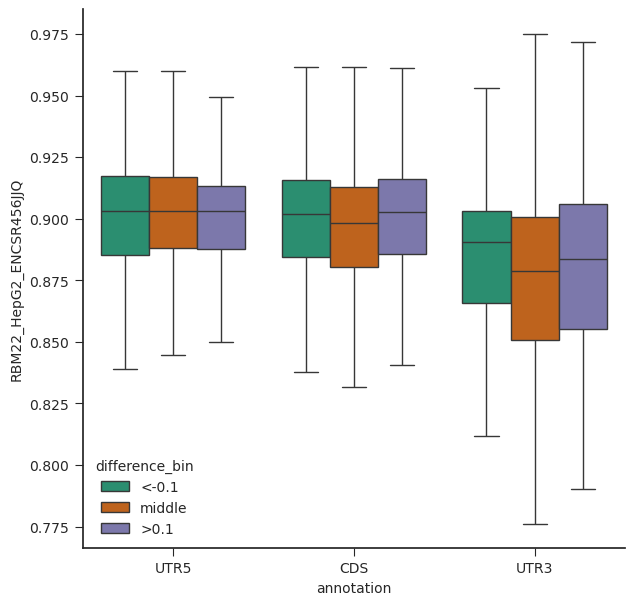

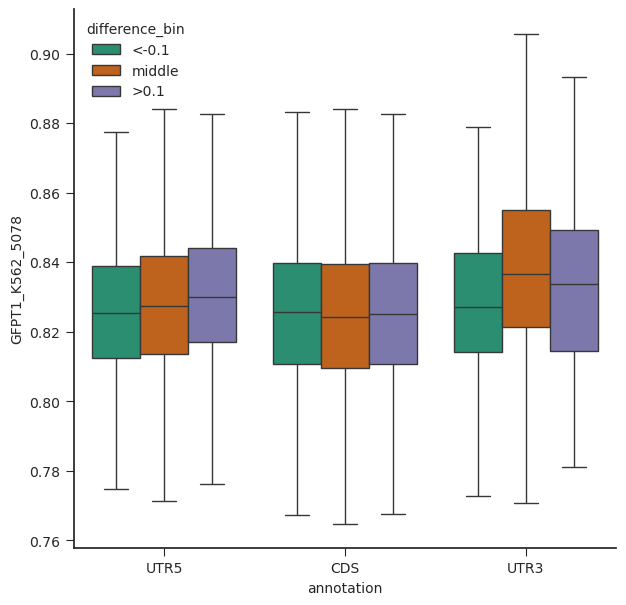

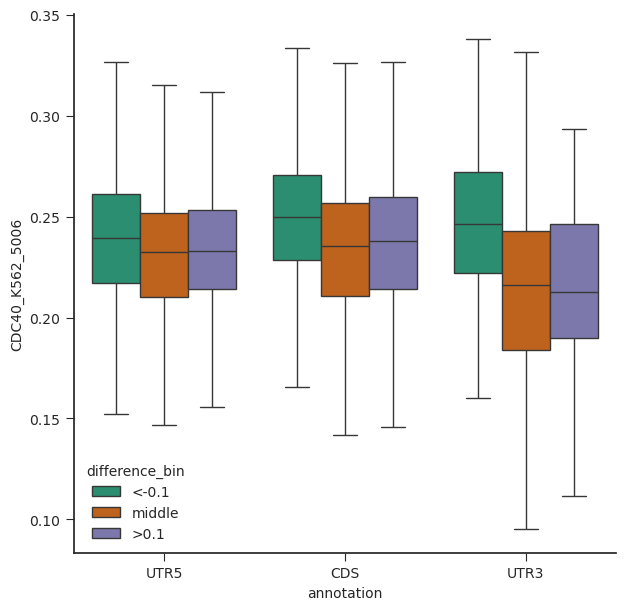

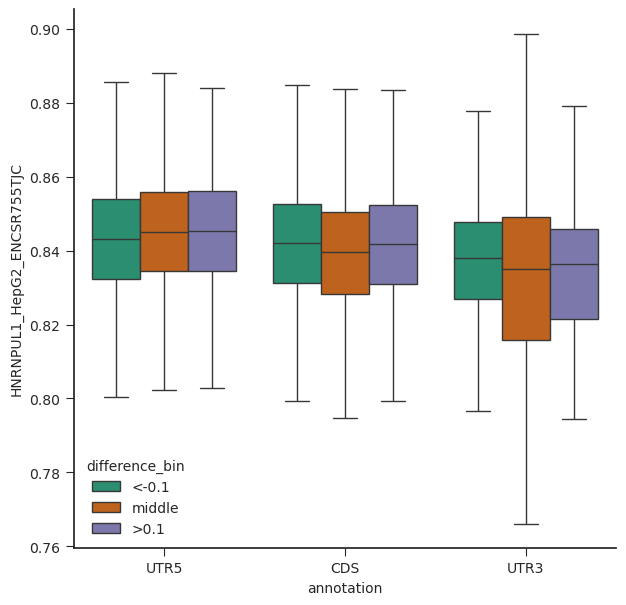

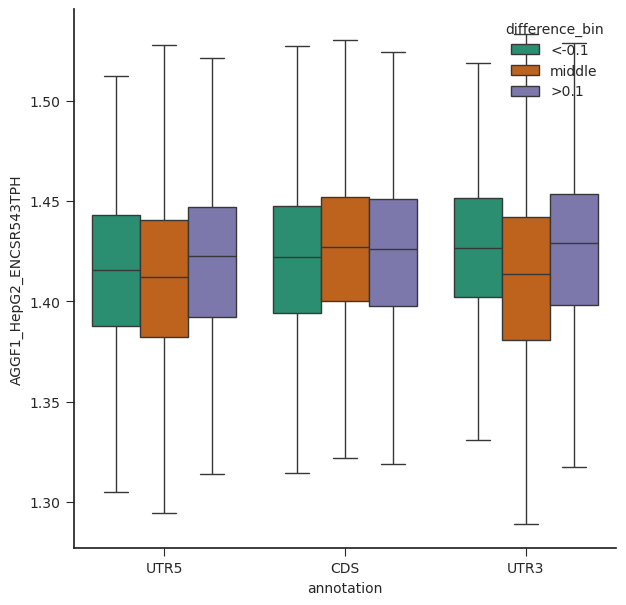

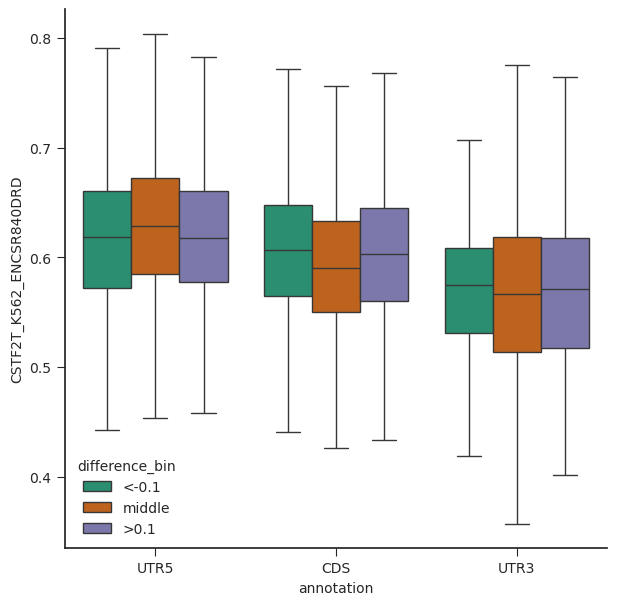

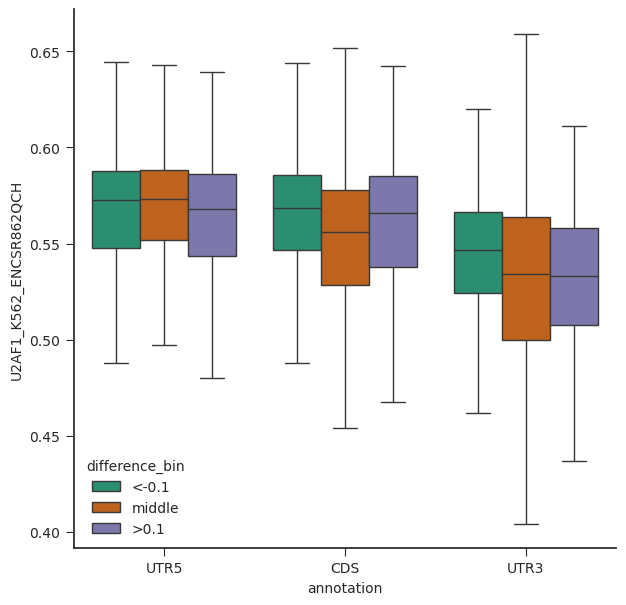

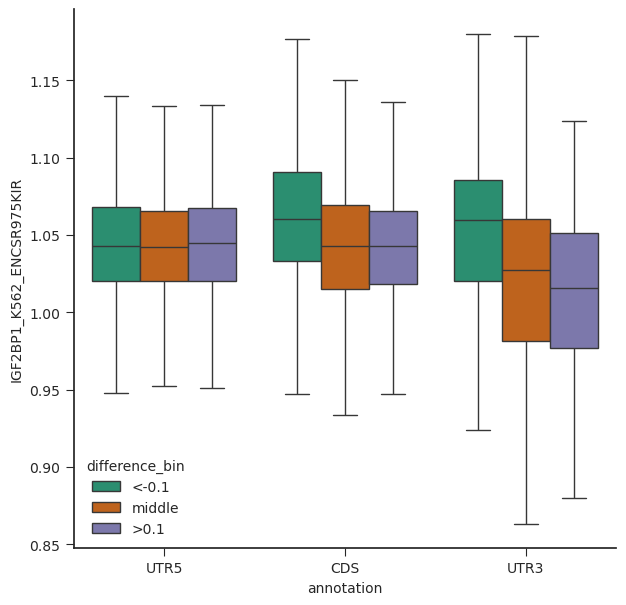

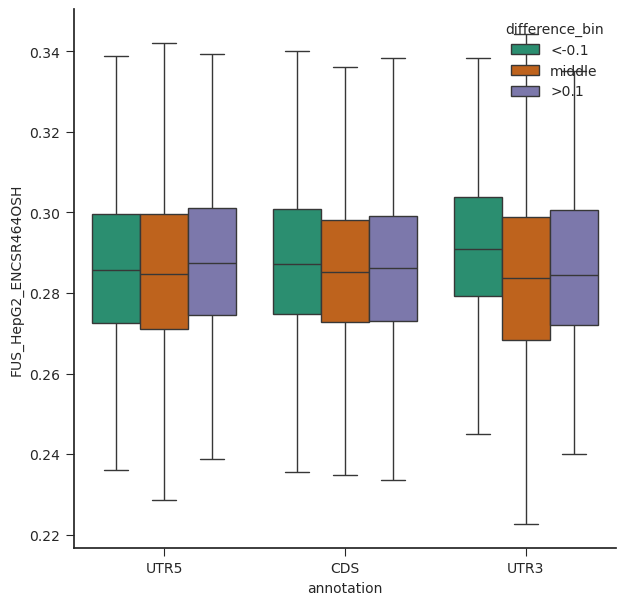

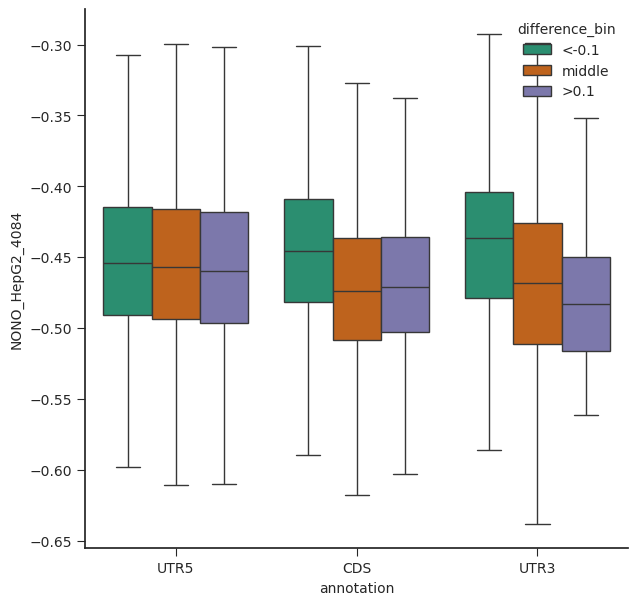

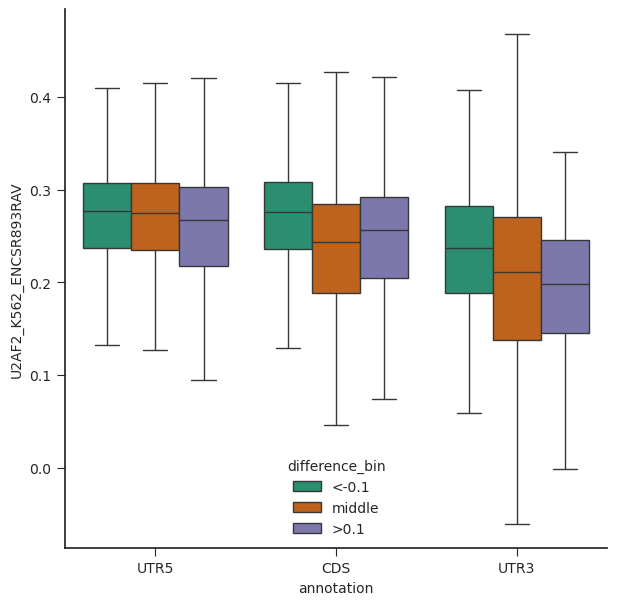

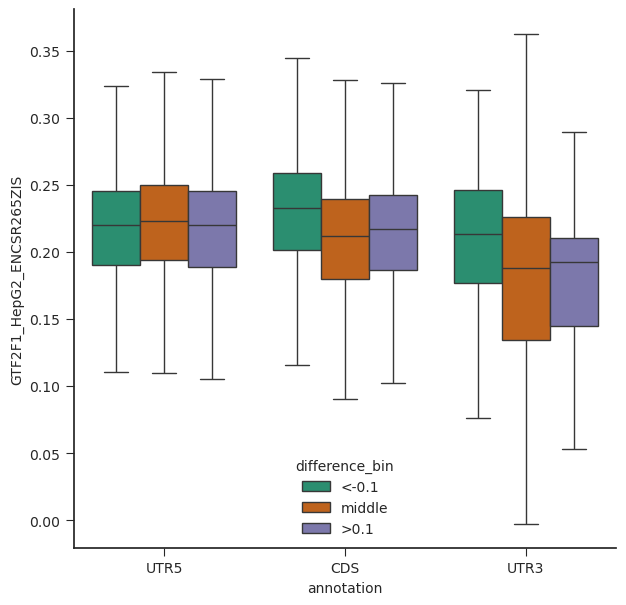

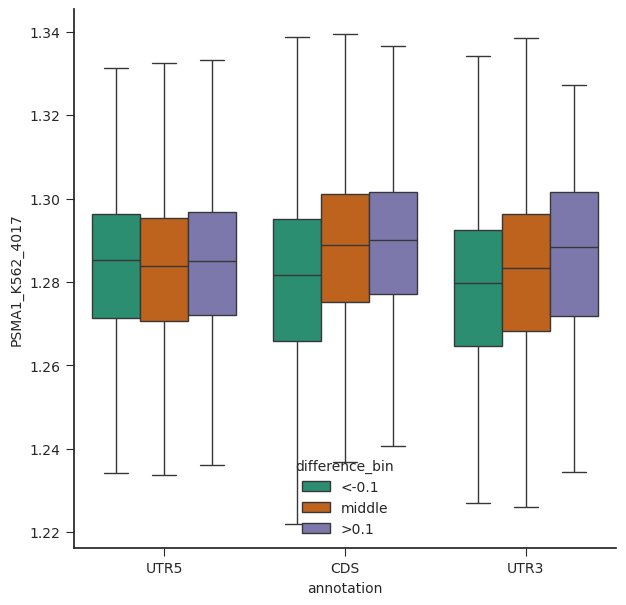

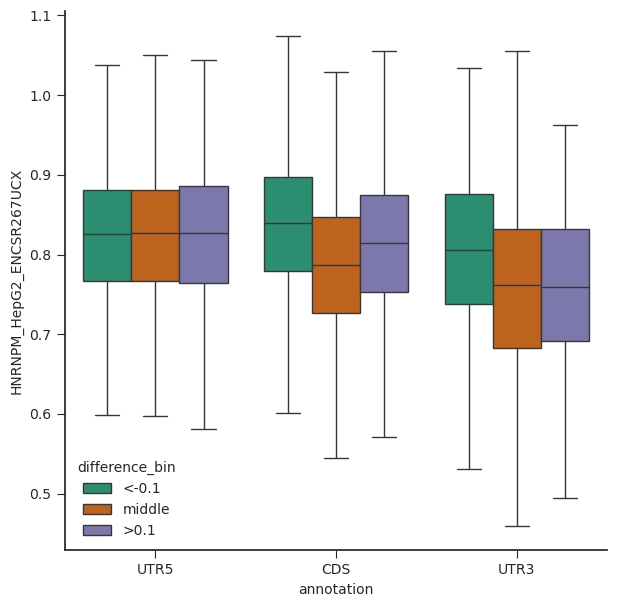

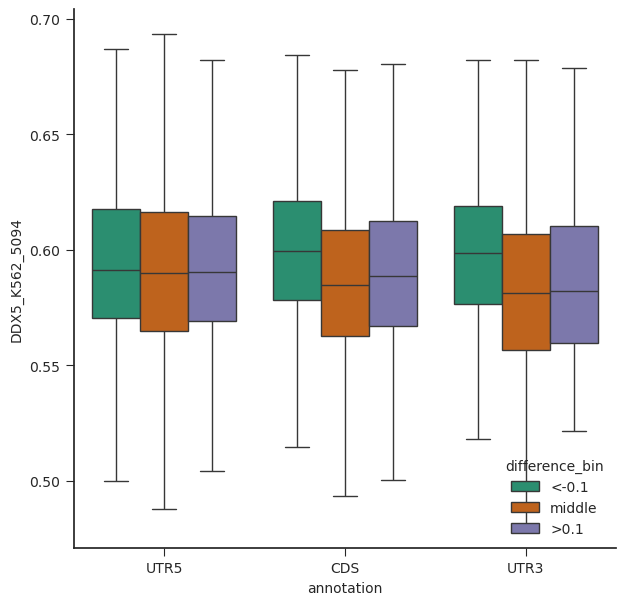

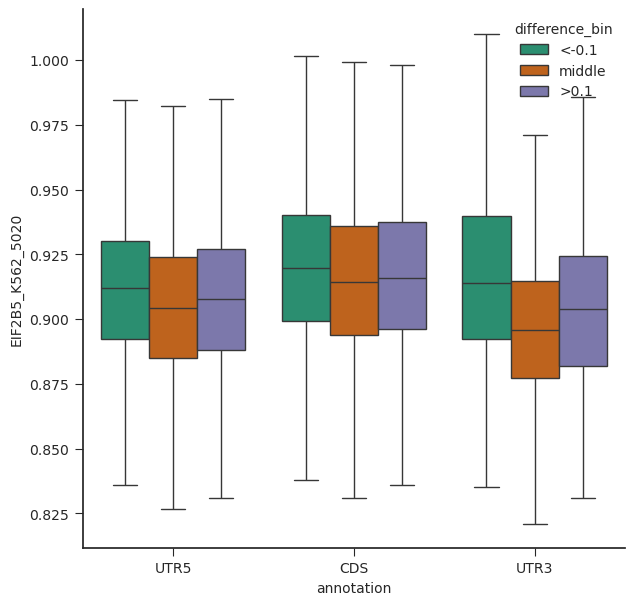

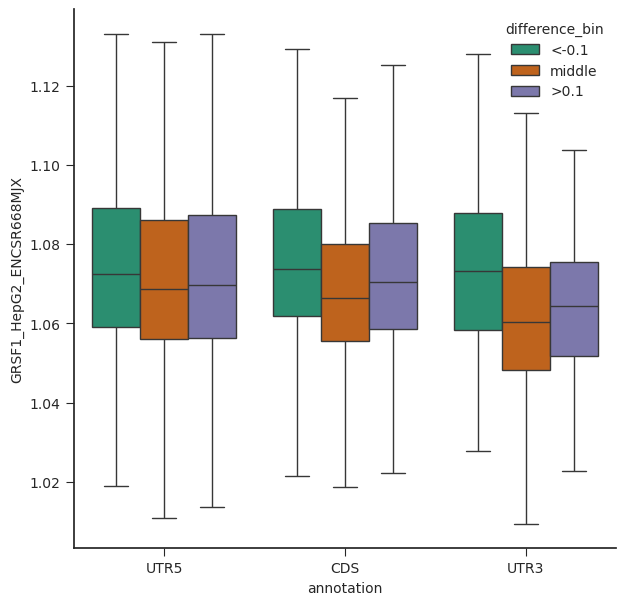

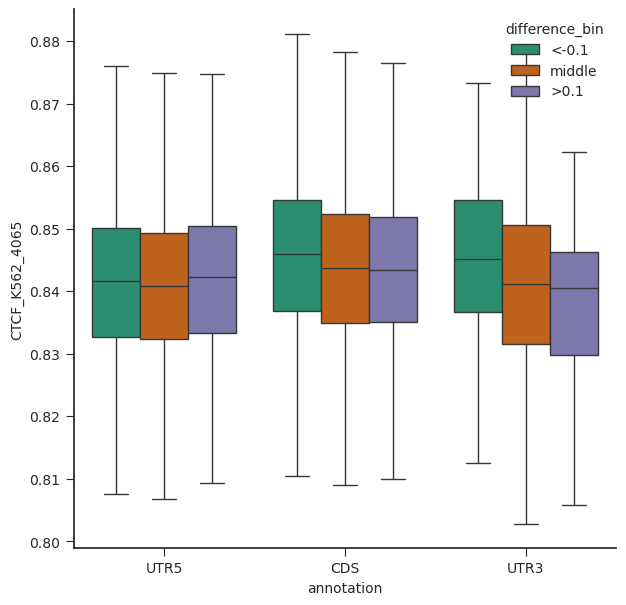

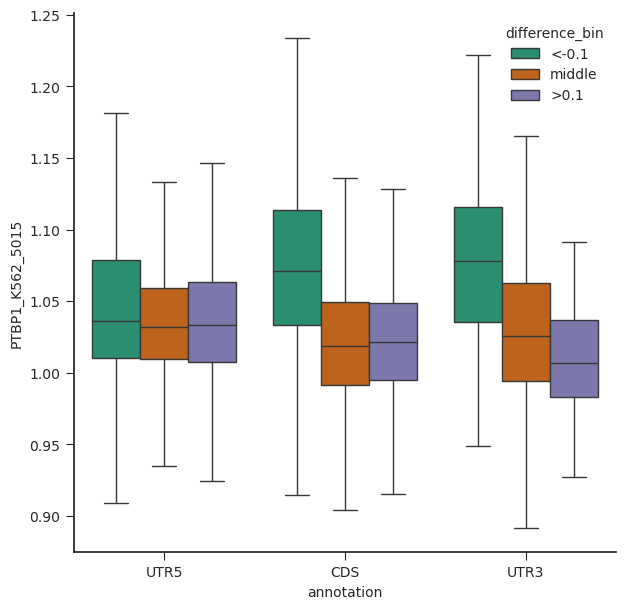

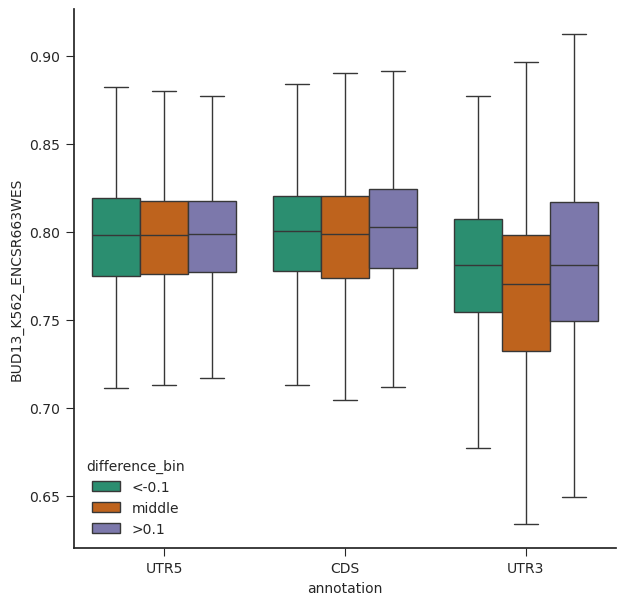

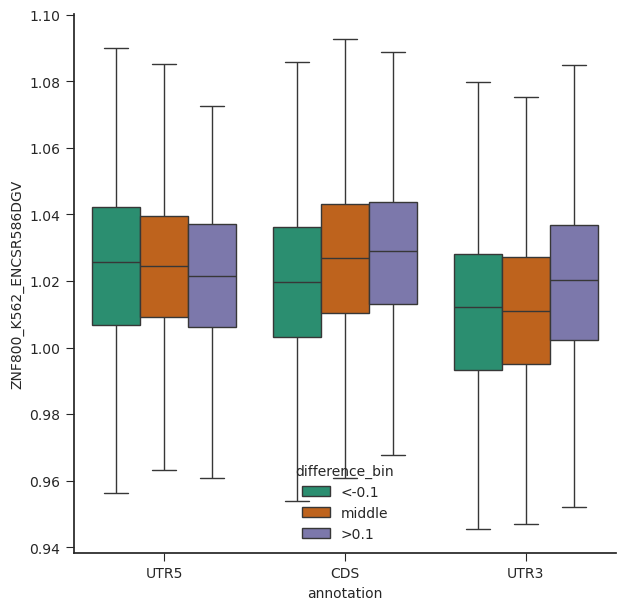

In [20]:
progress = trange(len(exp_list), position=0, leave=False)
for exp in exp_list:
    fig, ax = plt.subplots(figsize=(7,7))
    sns.boxplot(data, x = 'annotation', 
                y = exp, 
                hue = 'difference_bin', 
                showfliers=False, ax=ax)
    sns.despine()
    fig.savefig(os.path.join('/tscc/nfs/home/bay001/projects/karen_synapse_20240529/permanent_data/charlene_work/box_plots', f"{exp}.boxplot.png"))
    progress.update(1)

In [21]:
stat = []
for exp in data.columns[8:-2]:
    for region in ['UTR5', 'CDS', 'UTR3']:
        for cat in ['<-0.1', '>0.1']:
            mw, pv = mannwhitneyu(data.loc[(data['annotation']==region)&
                                        (data['difference_bin']==cat),
                                        exp], 
                                        data.loc[(data['annotation']==region)&
                                        (data['difference_bin']=='middle'),
                                        exp], alternative='greater')
            stat.append([mw, pv, exp, cat, region])
        
    

In [22]:
stat = pd.DataFrame(stat, columns = ['MannwhitneyU', 'pvalue', 'RBPNet_model', 'category', 'annotation'])

In [23]:
stat['RBP_official']=stat['RBPNet_model'].map(annotation.set_index('id')['RBP_official'])
stat['is_SynGo'] = stat['RBP_official'].isin(syngo['hgnc_symbol'])
stat.to_csv(outdir / 'neural_network_enrichment_human_30bp_region.csv')

In [24]:
data.to_csv(outdir / 'neural_network_scores_human_30bp.csv.gz')